In [1]:
import csv
import pandas as pd
import os
import re
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from scipy import odr
import matplotlib.colors as mcolors
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS, CSS4_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids
from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [2]:
class Night: #Each observing night is initialized as a Night object
    def __init__(self, file_path, night_number):
        #each attribute is declared here first, even if value is assigned later
        self.path = file_path #file path of obs night
        self.obs_night = night_number #each night is assigned a number, the first night is night 0
        self.image_data = None #the image data for the night
        self.headers = None #the night's headers
        self.wcs = None #world coordinate system transformation matrix
        self.readout_noise = None #detector readout noise
        self.aligned = None #aligned image data
        self.template = None #template frame
        self.references = None #reference sources
        self.obs_filter = None #observation filter
        self.no_obs_images = None #number of images in night

    def initialize_frames(self):
        science_dir = sorted(glob.glob(self.path + '/*')) #pulls data files using glob
        hdus = [fits.open(image, ignore_missing_simple=True) for image in science_dir] #opens each fits image
        self.image_data = [image[0].data for image in hdus] #pulls image data from file
        self.headers = [image[0].header for image in hdus] #pulls header data from file.
        self.wcs = WCS(self.headers[0]) #gets wcs transformation, each night should only have one unique transformation
        self.readout_noise = self.headers[0]['RDNOISE'] #pulls readout noise from header. Readout noise is detector based and should be the same across nights taken with same equipment but do this just in case.
        self.mjd_times = []
        self.date_times = []
        self.date = []
        self.start_times = []
        for header in self.headers:
            self.mjd_times.append(header['MJD-OBS']) #Modified Julian Date (date+start time)
            self.date_times.append(header['DATE-OBS']) #Date/Start time (YYYY-MM-DD:HH:MM:SS in UTC)
            self.date.append(header['DAY-OBS']) #Date (YYYYMMDD)
            self.start_times.append(header['UTSTART']) #UTC start time HH:MM:SS
        try:
            self.aligned_images = self.align()
        except:
            print("Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds")
            try:
                self.aligned_images = [aa.register(image, self.image_data[0])[0] for image in self.image_data[0:]]
            except:
                print("Could not align images")
                self.aligned_images = self.image_data
                self.is_aligned = False

        self.template = np.median(self.aligned_images, axis = 0) #night template
        background = sep.Background(self.template) #sep background subtraction for source extraction
        self.references = sep.extract(self.template - background.back(),  background.globalrms*3, minarea =25, segmentation_map=False) #finds sources based on given parameters

        self.obs_filter = self.headers[0]['filter'][0] #observation filter.
        self.no_obs_images = len(self.aligned_images) #number of images in night.


    def get_info(self): #function to grab night info, useful for debugging.
        print(f"path: {self.path}, night {self.obs_night}, n_frames: {len(self.image_data)}, n_aligned: {len(self.aligned_images)}, wcs: {self.wcs}, n_ref: {len(self.references)}, filter: {self.obs_filter}")


    def align(self):
        reference_pixels = np.array([[100, 200], [1500, 1500], [1800, 3000]]).astype(np.float32) #these are arbitrary points spanning the image, should be done dynamically at some point
        reference_skycoords = []
        for point in reference_pixels:
            skyval = pixel_to_skycoord(point[1], point[0], wcs = self.wcs[0])
            reference_skycoords.append(skyval)
        
        target_points = []
        for i in range(len(self.image_data)):
            target_pixels = []
            for point in reference_skycoords:
                pixval = SkyCoord.to_pixel(point, wcs= self.wcs[i])
                target_pixels.append(pixval)
            target_points.append(np.array(target_pixels).astype(np.float32))


        affine_aligned = []
        for i, image in enumerate(self.image_data):
            M = cv2.getAffineTransform(reference_pixels, target_points[i])
            rows, cols = image.shape
            dst = cv2.warpAffine(image, M, (rows, cols))
            affine_aligned.append(dst.T)

        return affine_aligned

In [3]:
class Source: #initialize source object
    def __init__(self, source, count, WCS):
        self.position = pixel_to_skycoord(source['x'], source['y'], wcs= WCS).transform_to('icrs') #since pixel locations are inconsistent, store position as RA/DEC
        self.radius = (source['xmax'] - source['xmin'])/2 #source radius (size) provided by SEP
        self.source_id = count #identifying number
        self.is_reference = None #if star is reference
        self.ref_mag = None #SDSS magnitude, if available
        self.ref_mag_err = None #reference mag error
        self.inst_mags = [] #instrumnetal (our) magnitudes
        self.inst_mag_errs = [] #instrumental mag errors
        self.calibrated_mags = [] #calibrated magnitudes
        self.flagged = False #bad source flag. Will be flipped true if a source is not present in all observing nights or has negative aperture sum
        self.weights = []
        self.errors = []
        self.chi2 = None


    def query_source(self): #querry a source through the sdss database
        #we want the search to return ra, dec, mags, and mag error. region = False, returns first result of search.
        search = SDSS.query_crossid(self.position, fields = ['ra', 'dec', f'psfMag_{Nights[0].obs_filter}', f'psfMagErr_{Nights[0].obs_filter}'], radius = 15 * u.arcsec, region = False)
        if search:
            if search['type'] == "STAR": #want to make sure reference objects are Stars
                self.is_reference = True #lets us know star is a reference star
                self.ref_mag = search[f'psfMag_{Nights[0].obs_filter}'] #fill in mag and error fields:
                self.ref_mag_err = search[f'psfMagErr_{Nights[0].obs_filter}']

    def boundary_check(self, night): #checks if a star is within frame for a given night.
        source_xy = SkyCoord.to_pixel(self.position, wcs= night.wcs)
        if (night.headers[0]['NAXIS1'] - source_xy[0]) < 0 or source_xy[0] < 0 or (night.headers[0]['NAXIS2'] - source_xy[1]) < 0 or source_xy[1] < 0:
            self.flagged = True #if star is out of bounds, flags star as bad


    def aperture_photometry(self, img, nght): #does aperture photometry

        coords = SkyCoord.to_pixel(self.position, wcs = nght.wcs) #gets pixel values of source from RA DEC
        pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions

        radius_i = self.radius #inner aperture radius
        radius_o_0 = radius_i + 5 #inner annulus radius
        radius_o_1 = radius_o_0 + 5 #outer annulus radius

        source_circle = CirclePixelRegion(pcoords, radius_i) #makes region of source shape
        source_circle_mask = source_circle.to_mask()
        source_aperture = source_circle_mask.cutout(img) #gets data of source
        source_sum_unsub = np.sum(source_aperture)

        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1) #makes annulus for background subtraction
        #background_mean = ApertureStats(img, background_annulus).mean #takes mean of background annulus
        background_sum = aperture_photometry(img, background_annulus)['aperture_sum'][0]

        #source_flux_pix = source_aperture-((source_circle.area/background_annulus.area)*background_sum*source_circle_mask) #pixel wise background subtraction
        source_flux_total = np.sum(source_aperture) - (source_circle.area/background_annulus.area)*background_sum  #total flux



        readout_sum_source = source_circle.area*(nght.readout_noise**2)
        readout_sum_annulus = background_annulus.area*(nght.readout_noise**2)

        delta_n = (readout_sum_source + source_flux_total + ((source_circle.area/background_annulus.area)**2)*(readout_sum_annulus + background_sum))**(1/2)

        if source_flux_total < 0:
            print(f'source {self.source_id} aperture sum below zero')
            self.flagged = True #flags source if aperture sum turns out to be negative

        else:
            instrumental_mag = -2.5*np.log10(source_flux_total) #magnitude
            instrumental_mag_error = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total) #magntiude error
            self.inst_mags.append(instrumental_mag)
            self.inst_mag_errs.append(instrumental_mag_error)


    def add_calibrated_mag(self, mag):
        self.calibrated_mags.append(mag) #adds calibrated mag. For some reason, math comes out unexpectedly if calibration takes place in class function.

    def add_chi(self, chi):
        self.chi2 = chi

    def add_error(self, err):
        self.errors.append(err)
        self.weights.append(1/(err**2))

    def get_info(self): #prints out source info.
        print(f"ra_dec: {self.position}, Night_0_xy: {SkyCoord.to_pixel(self.position, wcs = Nights[0].wcs)} rad: {self.radius}, ref_status: {self.is_reference}, ref_mag: {self.ref_mag}, inst_mag_avg:{np.mean(self.inst_mags)}, cal_mag_avg: {np.mean(self.calibrated_mags)}, flagged: {self.flagged}, ID: {self.source_id}, Chi2: {self.chi2}")

    def __iter__(self): #for writing out csv files
        return iter([self.position, self.is_reference, self.ref_mag, self.chi2, self.flagged, self.source_id, self.calibrated_mags])

In [4]:
class InputData: # Checks the input data of all stars
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_idx = []
        self.ra = []
        self.dec = []
        self.mag = []

    def load_data(self):
        for file_name in os.listdir(self.folder_path): # Loop through all files within the input data folder
            if file_name.endswith('.txt'): # Read the txt files only
                file_path = os.path.join(self.folder_path, file_name)
                df = pd.read_csv(file_path)
                # Ensure the DataFrame has the necessary columns
                if all(col in df.columns for col in ['ra', 'dec', 'mag']):
                    # Store the data along with the file name
                    index = int(''.join(filter(str.isdigit, file_name)))
                    self.file_idx.append(index) # Get the name of the file in case python does not read according to usual order
                    self.ra.append(df['ra'].values)
                    self.dec.append(df['dec'].values)
                    self.mag.append(df['mag'].values)
                else:
                    print(f"Skipping file {file_name}: Missing required columns.")

    def sort_data(self):
        sorted_indices = sorted(range(len(self.file_idx)), key=lambda i: self.file_idx[i])
        sorted_numbers = [self.file_idx[i] for i in sorted_indices]
        sorted_ra = [self.ra[i] for i in sorted_indices]
        sorted_dec = [self.dec[i] for i in sorted_indices]
        sorted_mag = [self.mag[i] for i in sorted_indices]

        self.file_idx = sorted_numbers
        self.ra = sorted_ra
        self.dec = sorted_dec
        self.mag = sorted_mag

In [5]:
def lin_model(p, x): #define a standard linear model for ODR fitting. Part of calibration.
    return p[0] * x + p[1]

def ODR(x_data, y_data):
    x_bar = np.mean(x_data)
    y_bar = np.mean(y_data)

    s_xx = 1/len(x_data) * np.sum((x_data - x_bar)**2)
    s_yy = 1/len(y_data) * np.sum((y_data - y_bar)**2)
    s_xy = 1/len(x_data) * np.sum((x_data - x_bar) * (y_data - y_bar))

    b_0 = (s_yy - s_xx + np.sqrt((s_yy - s_xx)**2 + 4*s_xy**2))/(2 * s_xy)
    b_1 = y_bar - b_0 * x_bar

    return [b_0, b_1]

In [6]:
# primary_dir = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #main file directory; directory containing folders for each night.
primary_dir = sorted(glob.glob("/Users/wendy/Desktop/Pipeline/Simulation_codes/Simulations/Sim 2/star_field/*")) #main file directory; directory containing folders for each night.
Nights = [Night(directory, dir_number) for dir_number, directory in enumerate(primary_dir)] #initializes each night as a Night object
for night in Nights:
    night.initialize_frames() #see initialize_frames() in Night class definitions

Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds
Unable to align using affine transform. WCS matrix may be unavailble or points out of image bounds


In [7]:
Sources = [Source(source, count, Nights[0].wcs) for count, source in enumerate(Nights[0].references)] #initializes sources based off first night's list. This ensures proper source tracking
print(f'{len(Sources)} stars detected')
for source in Sources:
    source.query_source() #see query_source() in source class definitions

95 stars detected


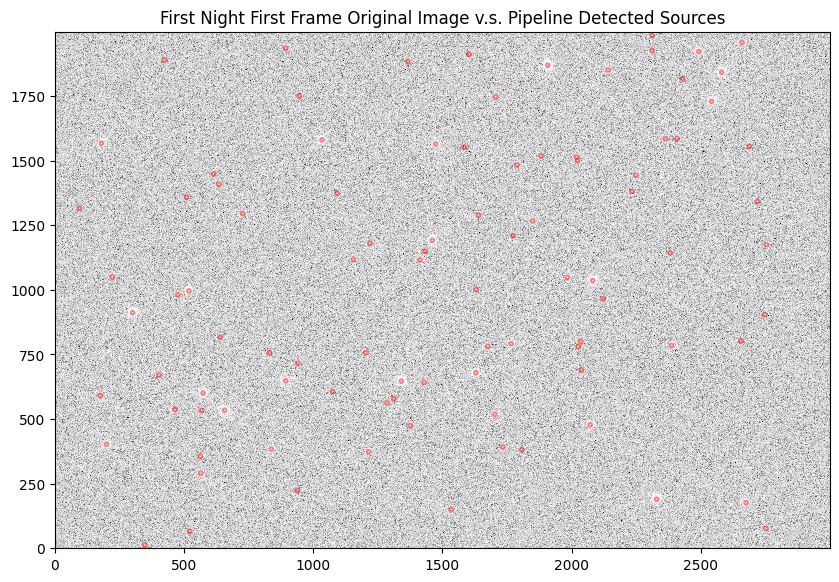

In [8]:
# Compare the 1st night image and the source detected to see potential differences
first_night_image = Nights[0].image_data[0]
normalization = ImageNormalize(first_night_image, interval=ZScaleInterval(), stretch=SqrtStretch())

plt.figure(figsize=(10,8))
plt.imshow(first_night_image, cmap='Greys_r', origin='lower', norm=normalization, interpolation = 'nearest')

x_pos = []
y_pos = []
for count, source in enumerate(Nights[0].references):
    x_pos.append(source['x'])
    y_pos.append(source['y'])
positions = np.transpose((x_pos,y_pos))
apertures = CircularAperture(positions, r=7.0)
apertures.plot(color='red', lw=1.5, alpha=0.5)
        
plt.title('First Night First Frame Original Image v.s. Pipeline Detected Sources')
plt.show()

In [9]:
night_array = [] #this is to help organize plotting later.
mag_thresh = 15 #magnitude threshold for calibrating sources.
for night in Nights: #for each night, iterates through every source for each image.
    for image in night.aligned_images:
        for source in Sources:
            source.boundary_check(night) #see boundary_check() in source class definition
            if source.flagged == False:
                source.aperture_photometry(image, night)  #see aperture_photometry() in source class definition
        night_array.append(night.obs_night)

source 34 aperture sum below zero


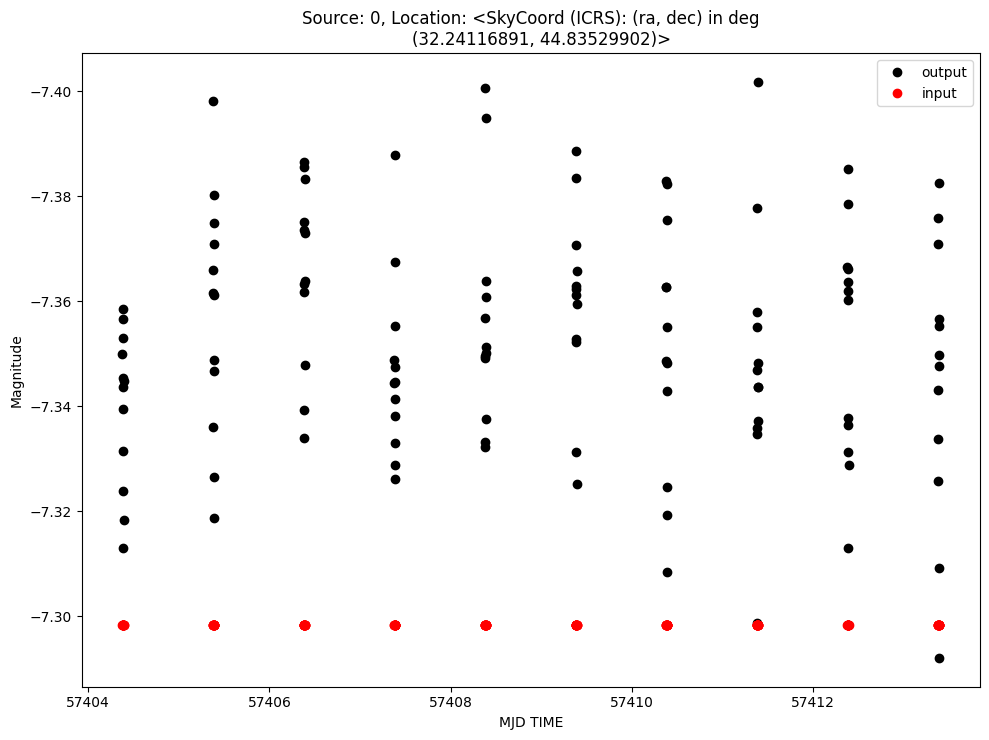

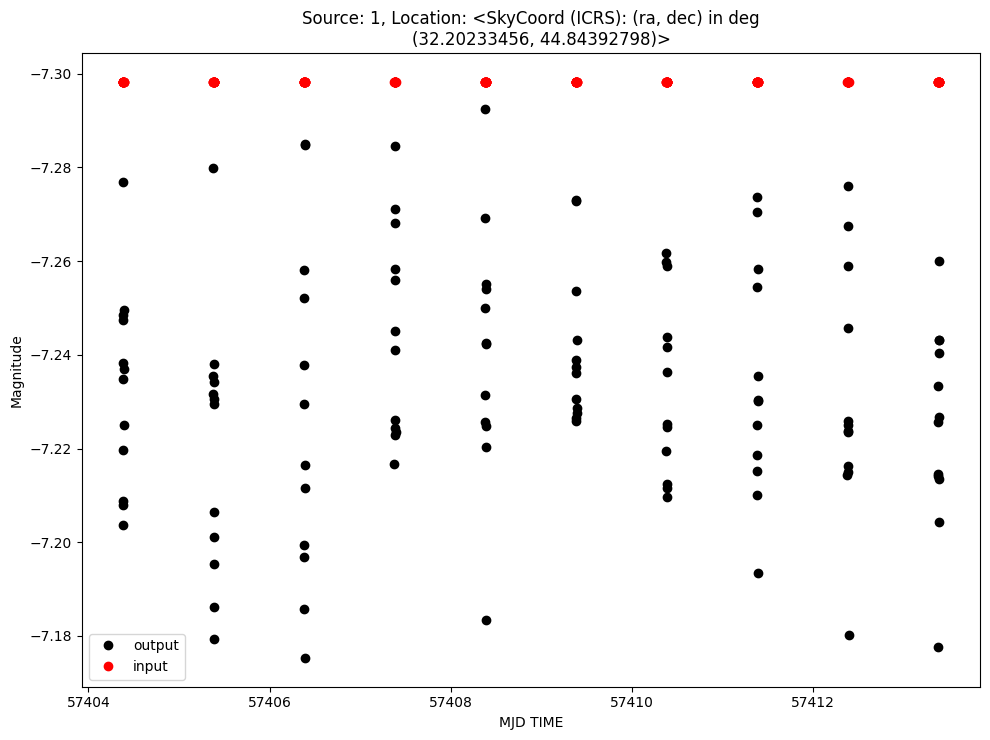

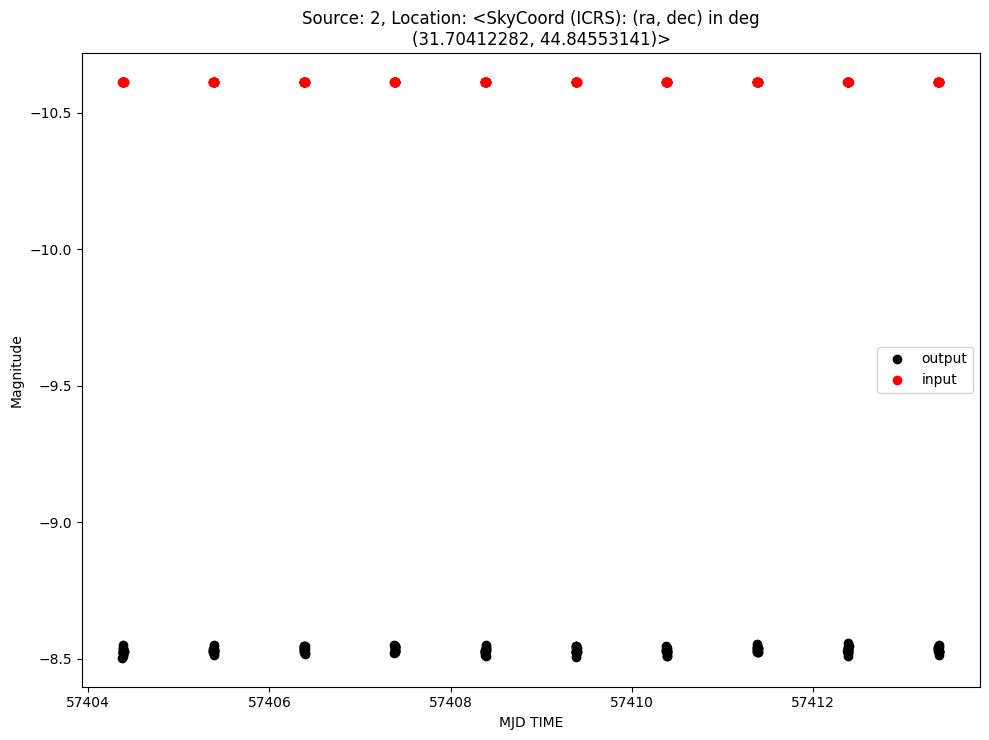

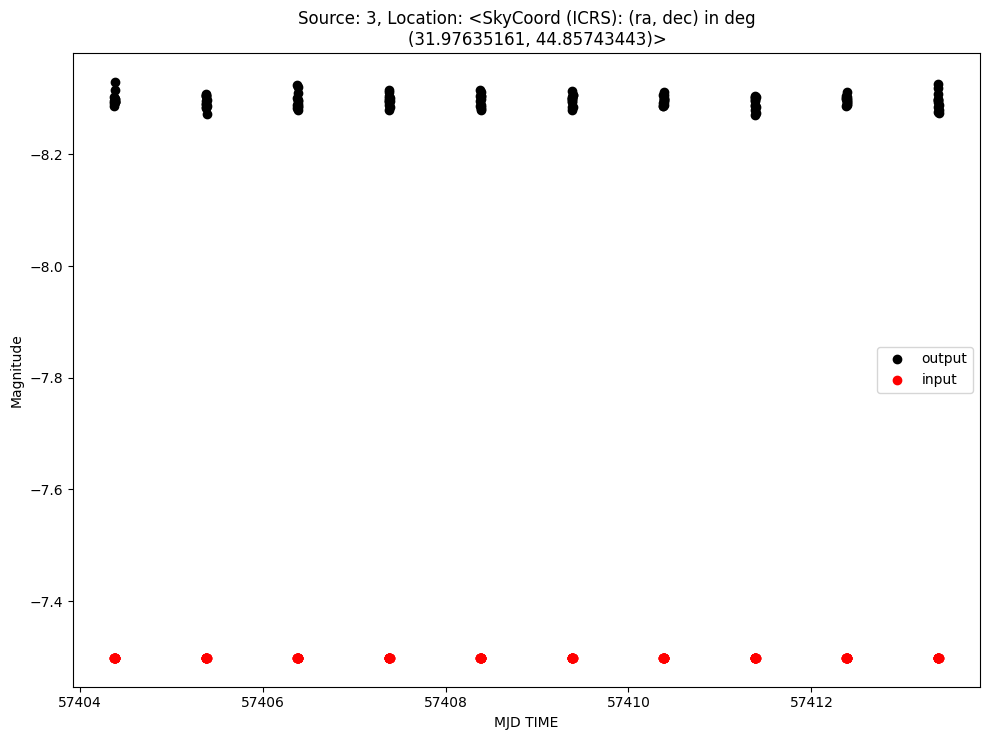

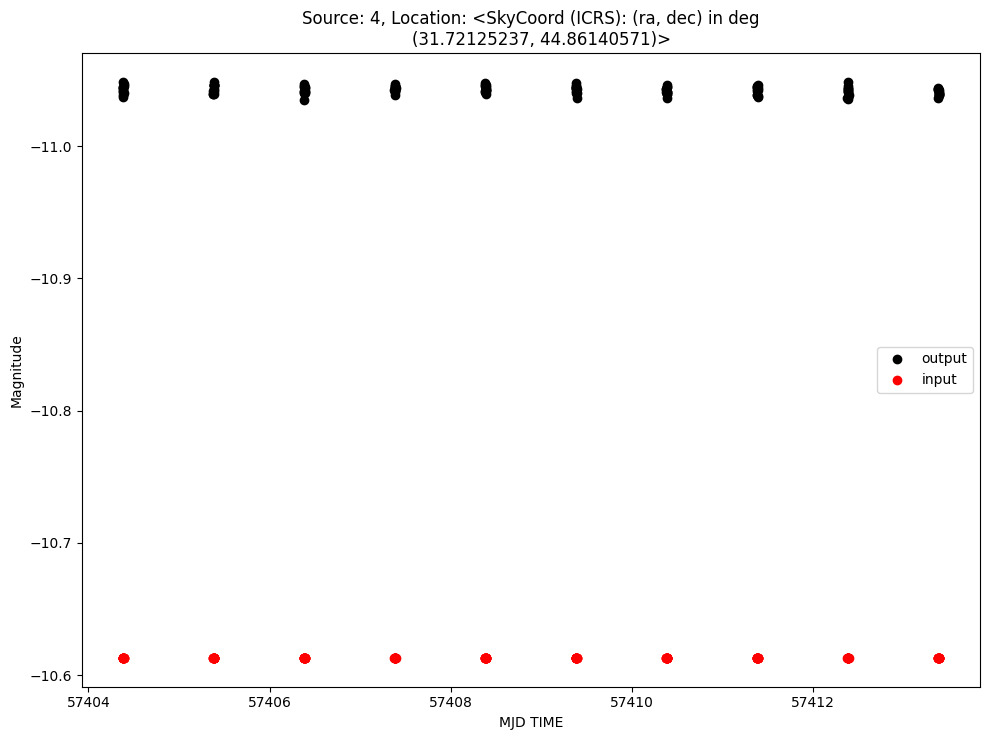

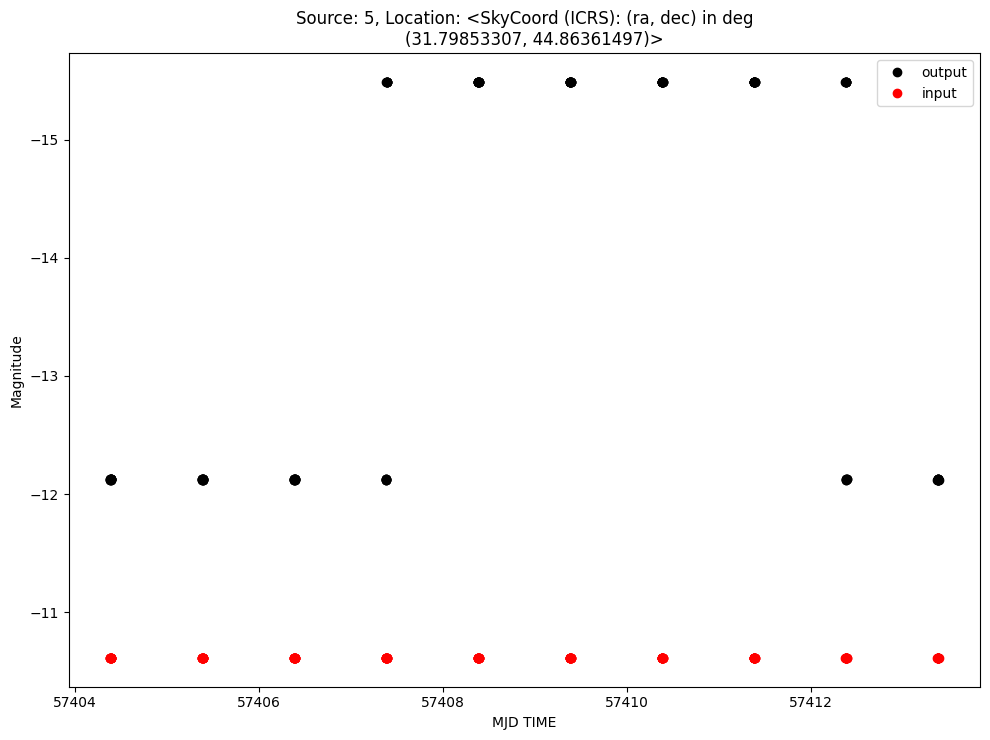

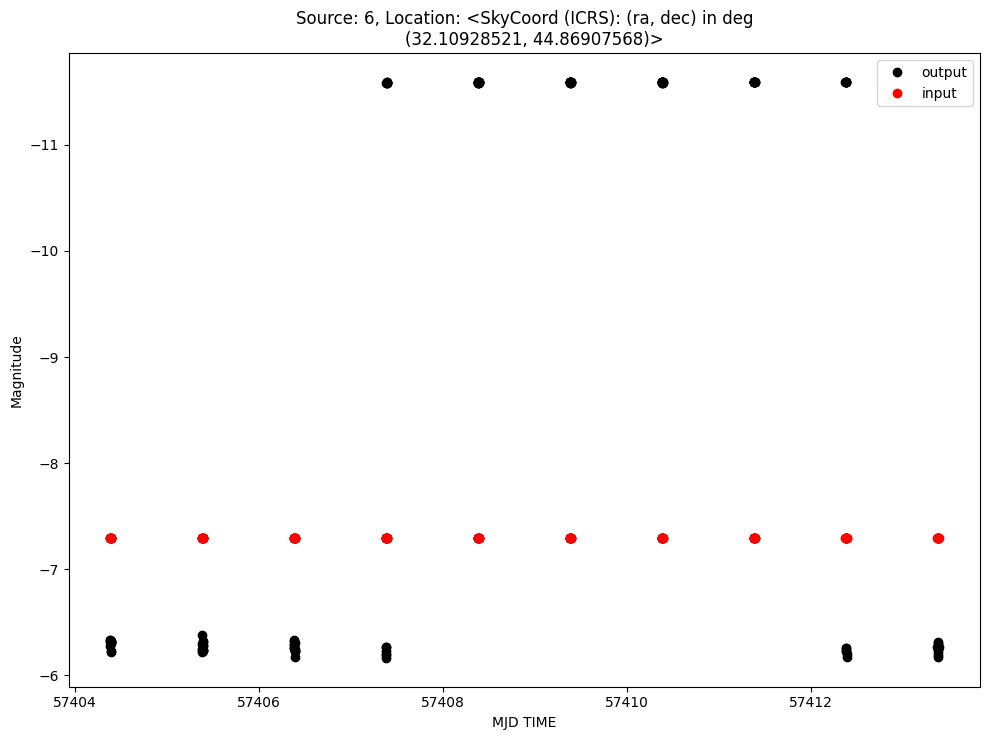

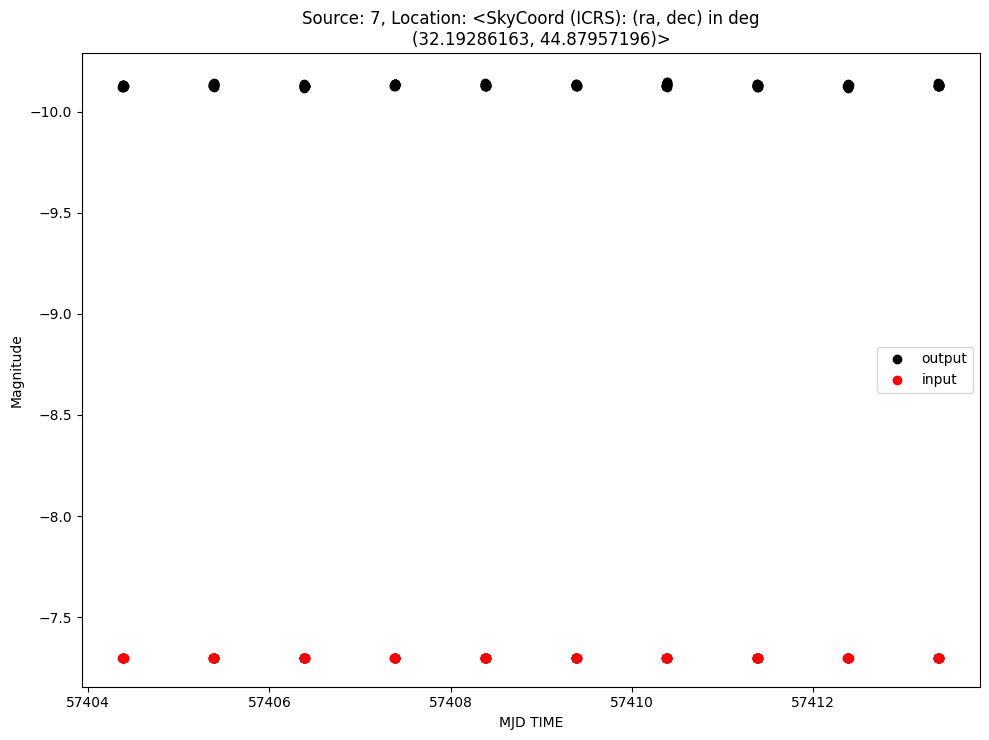

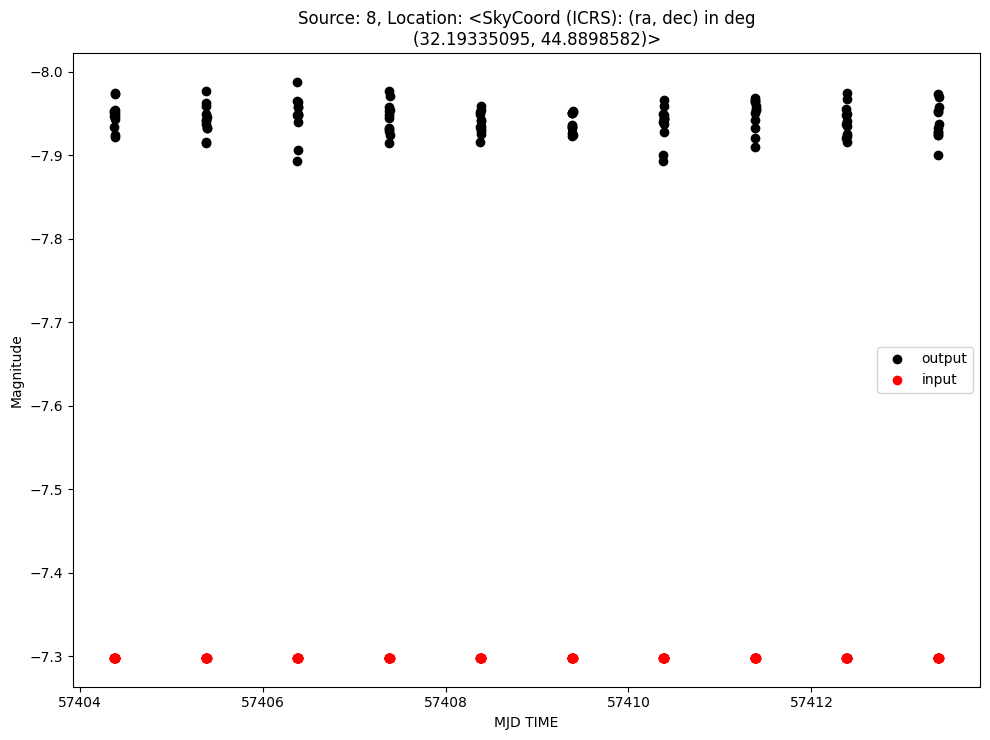

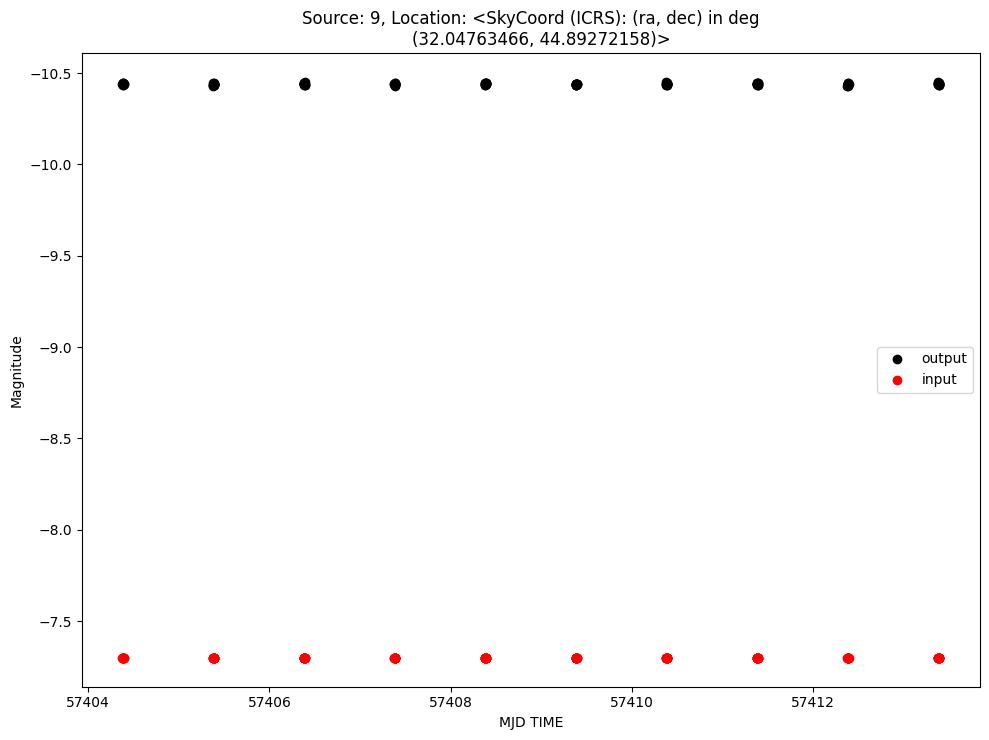

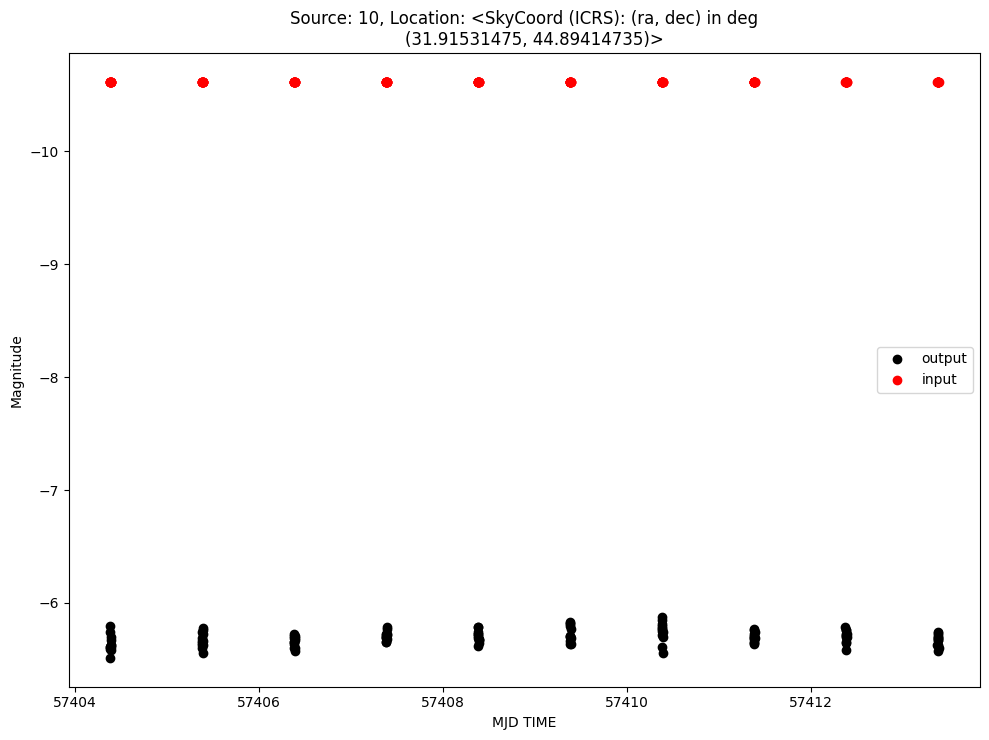

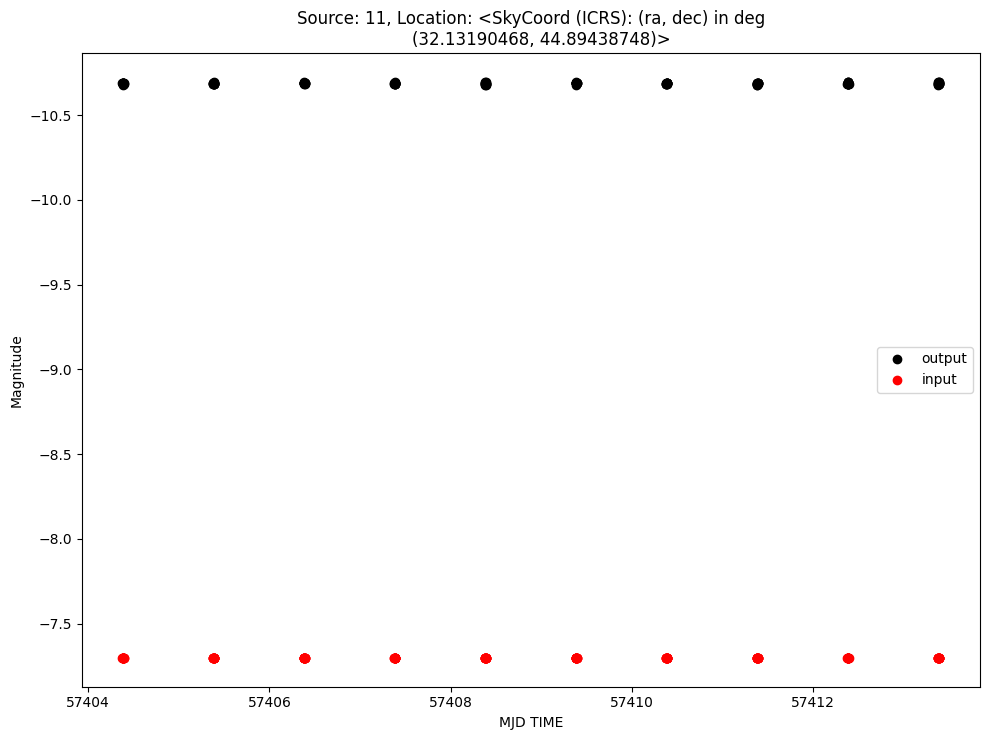

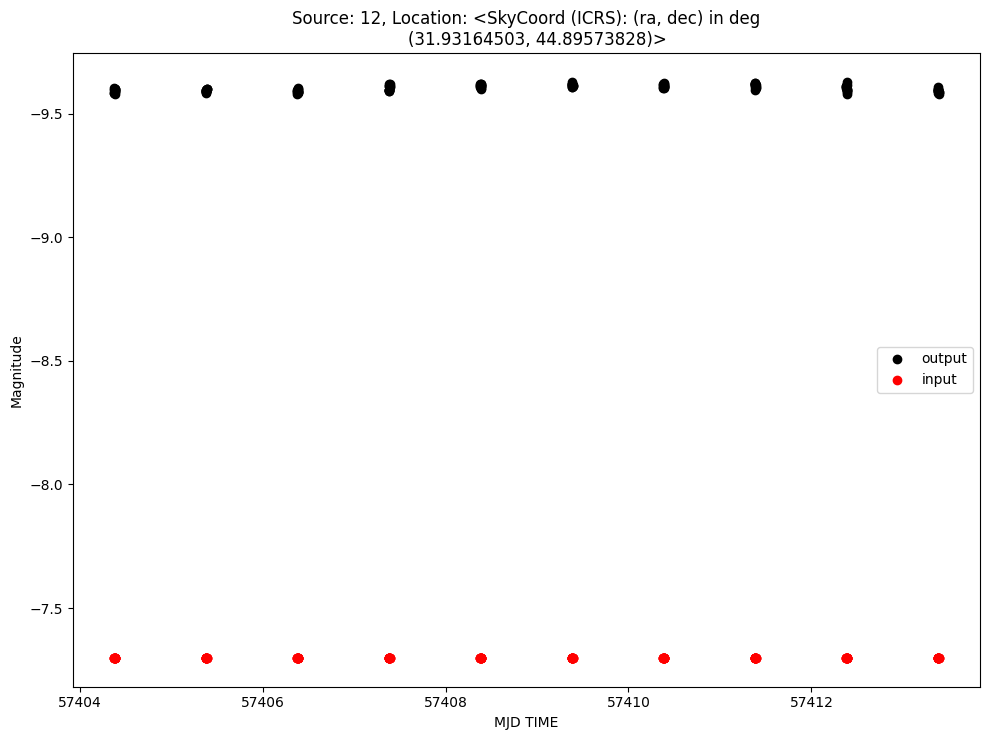

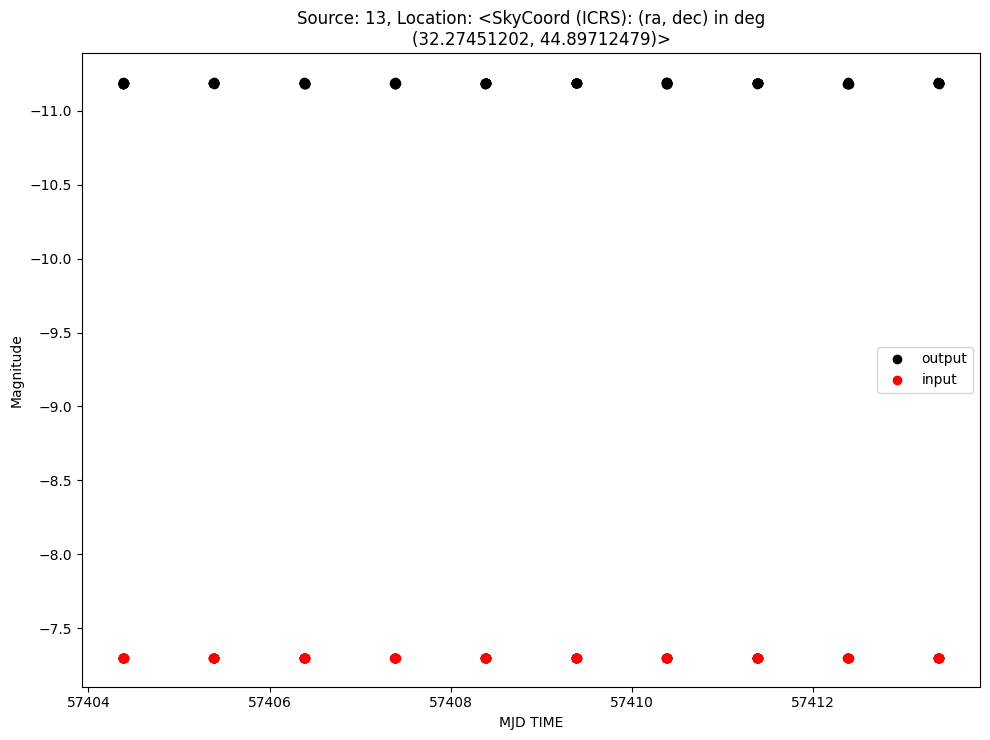

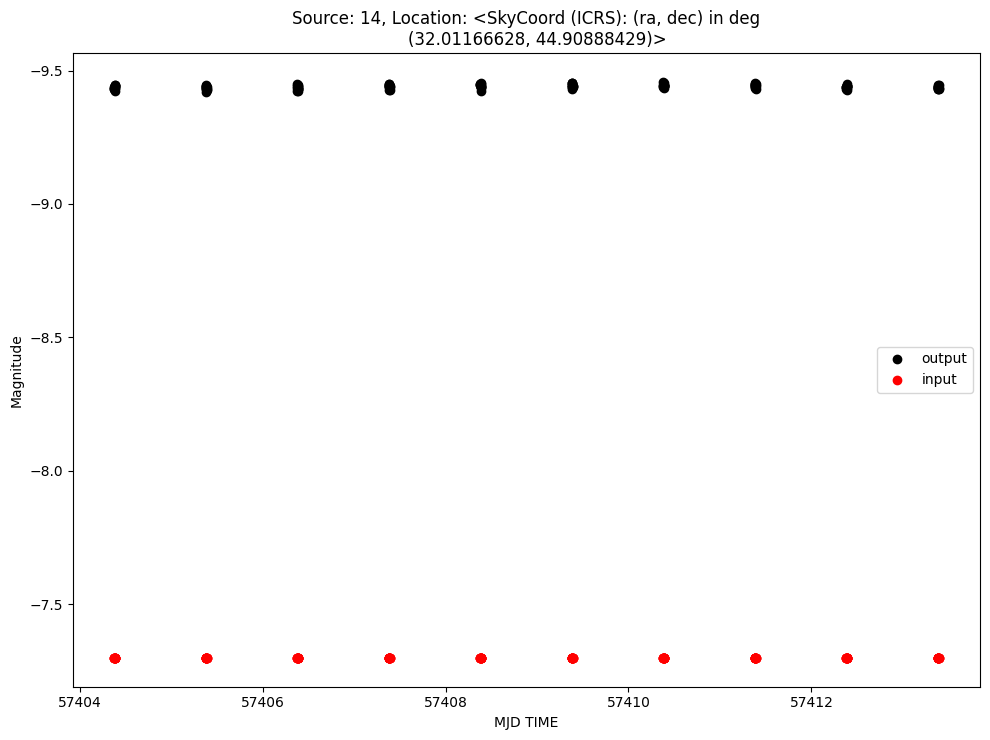

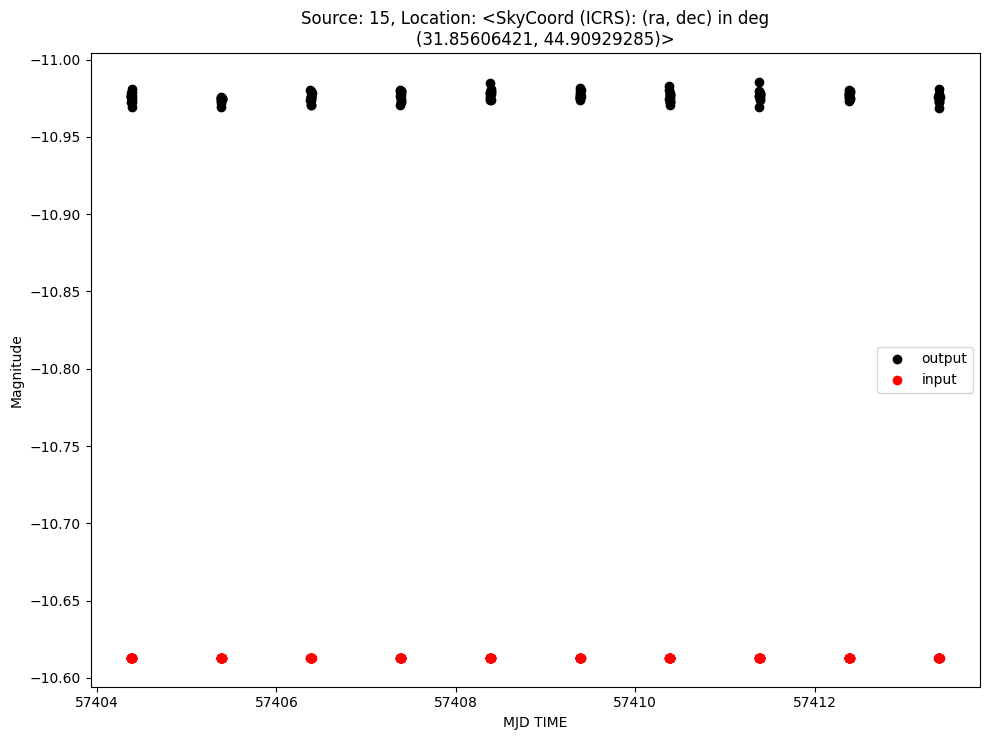

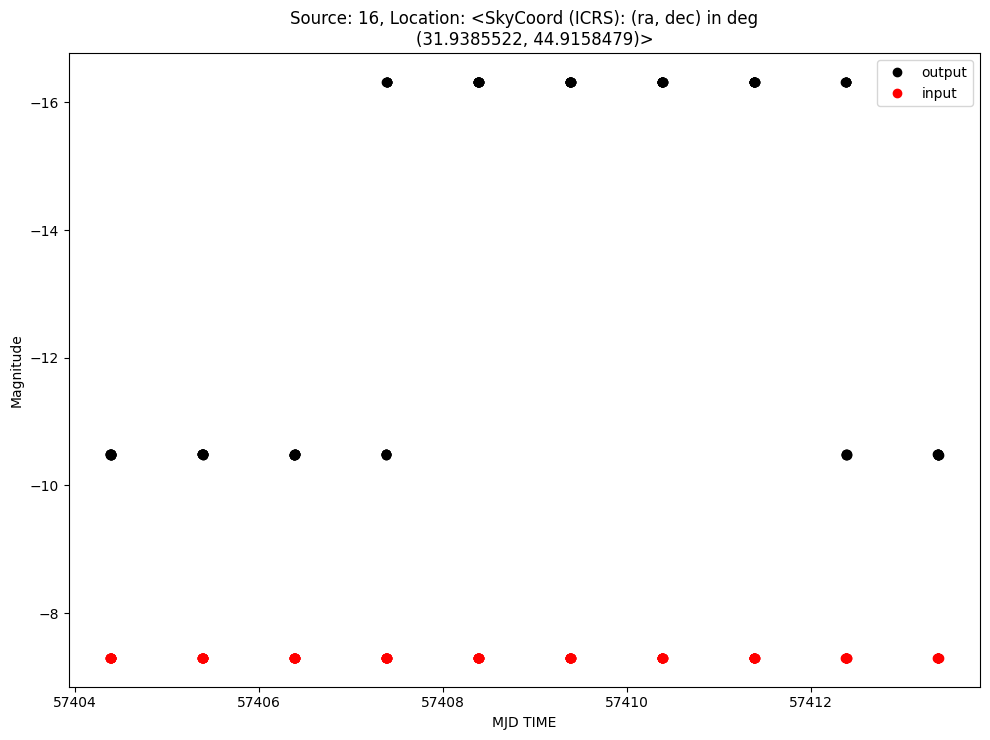

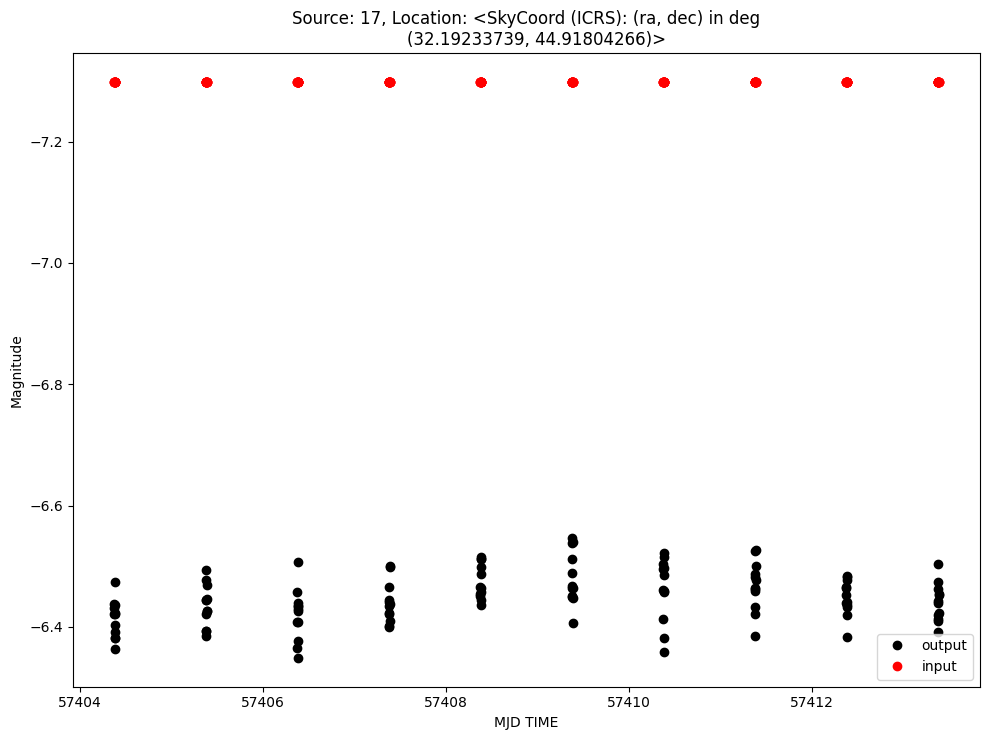

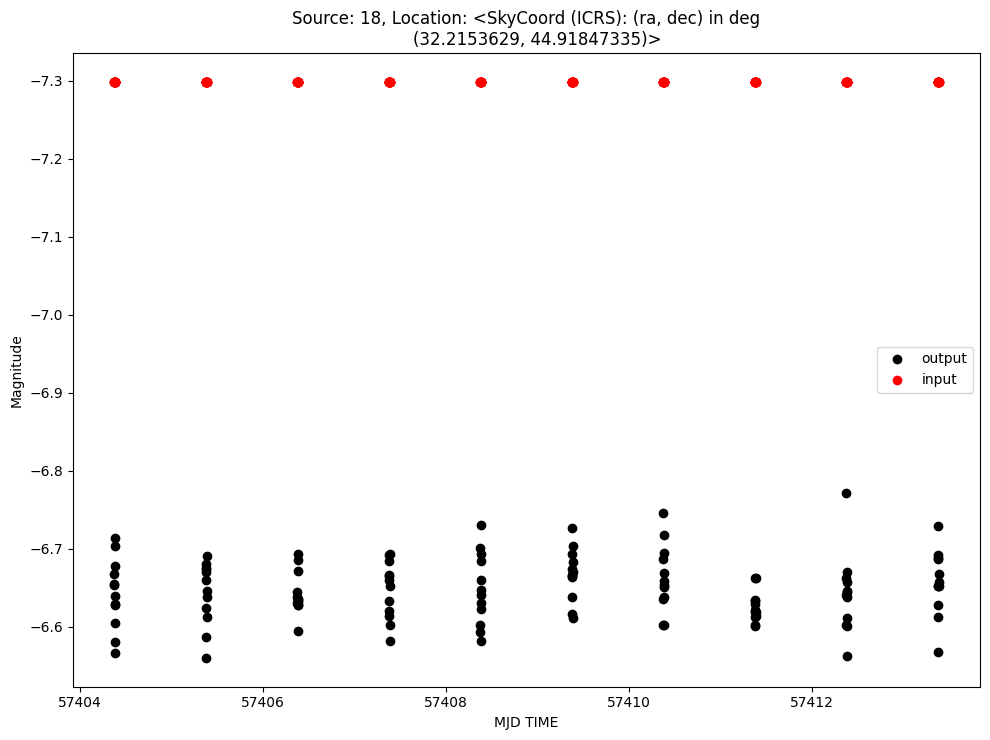

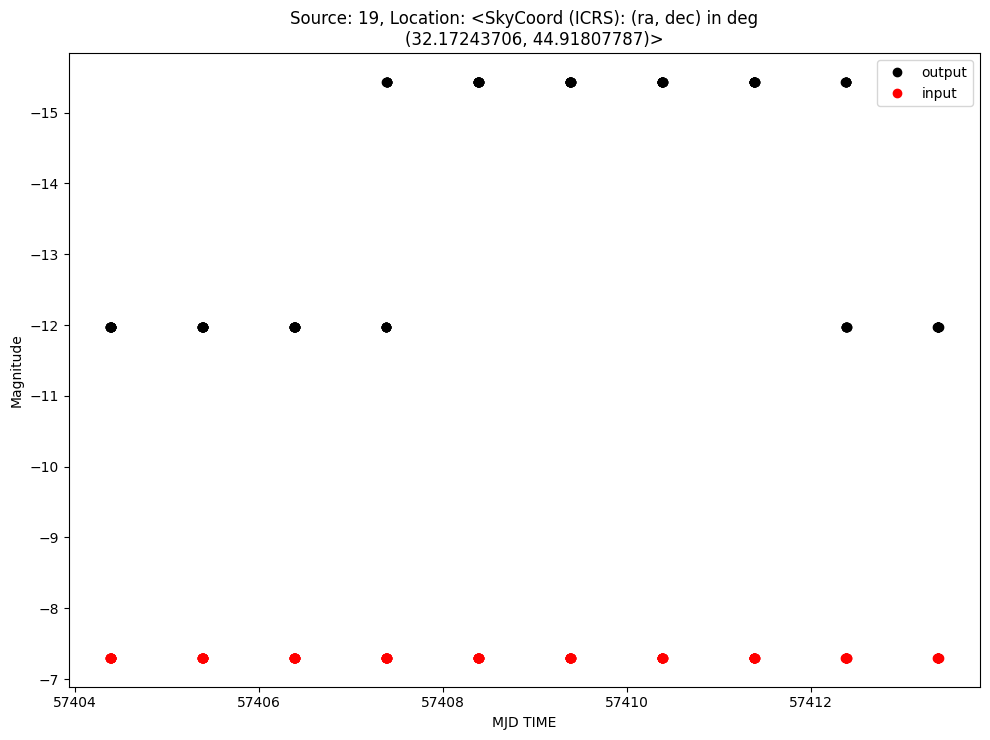

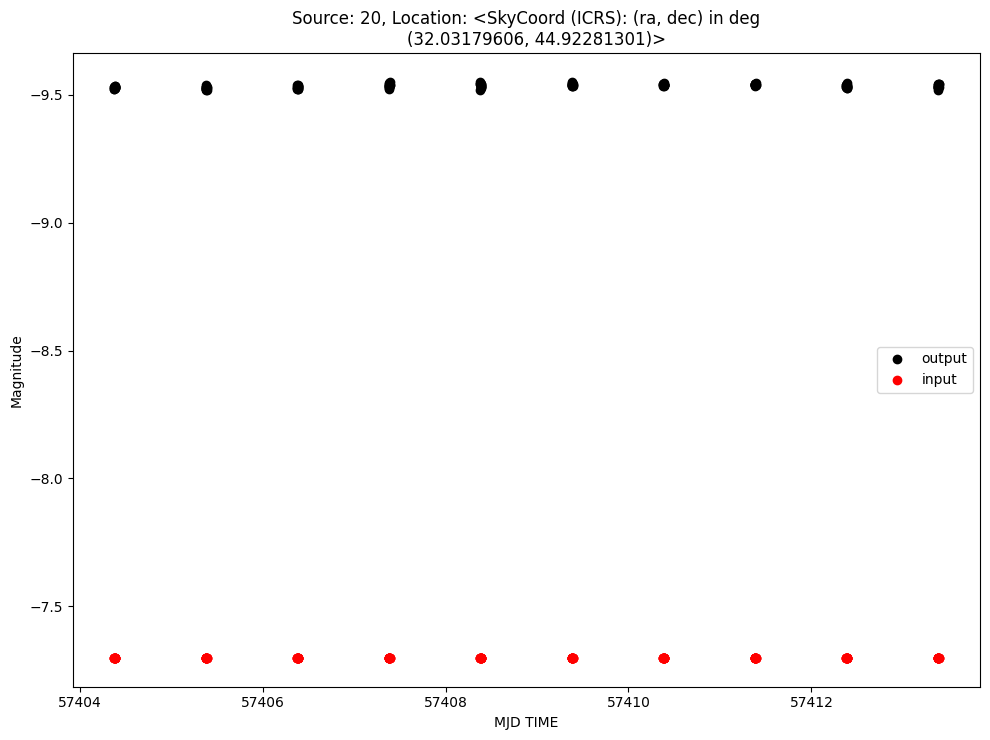

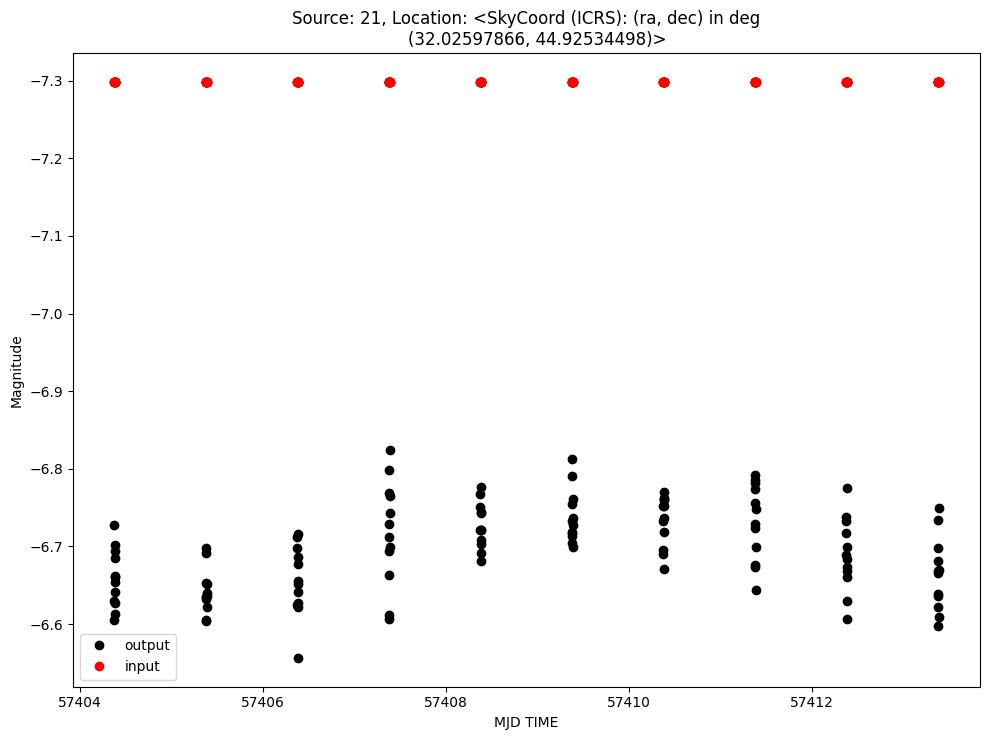

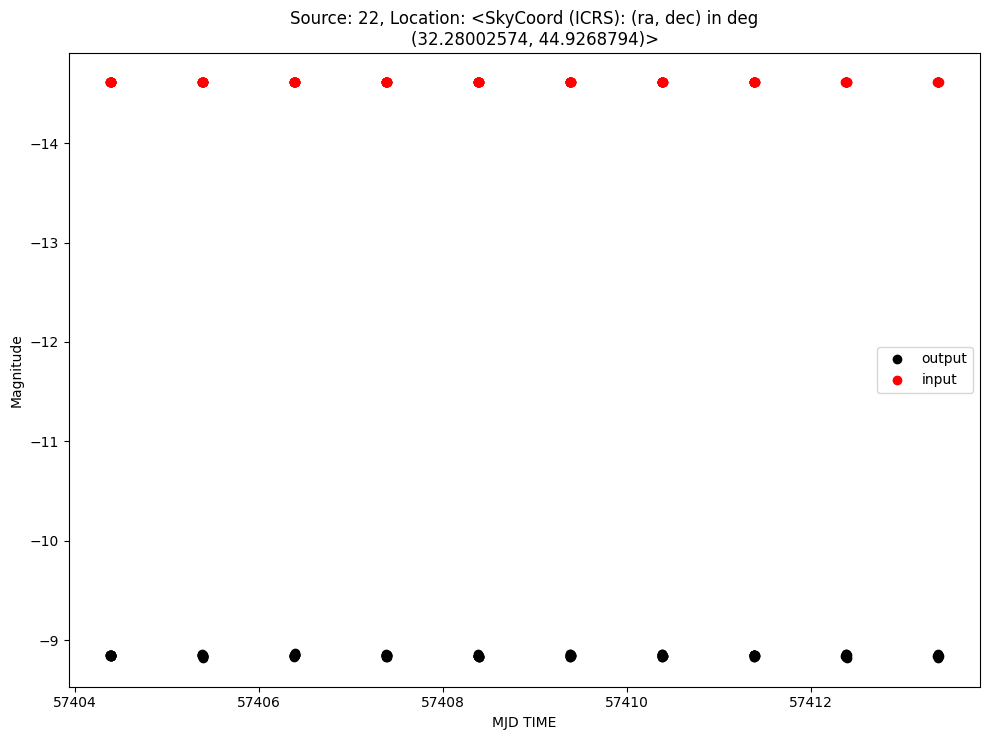

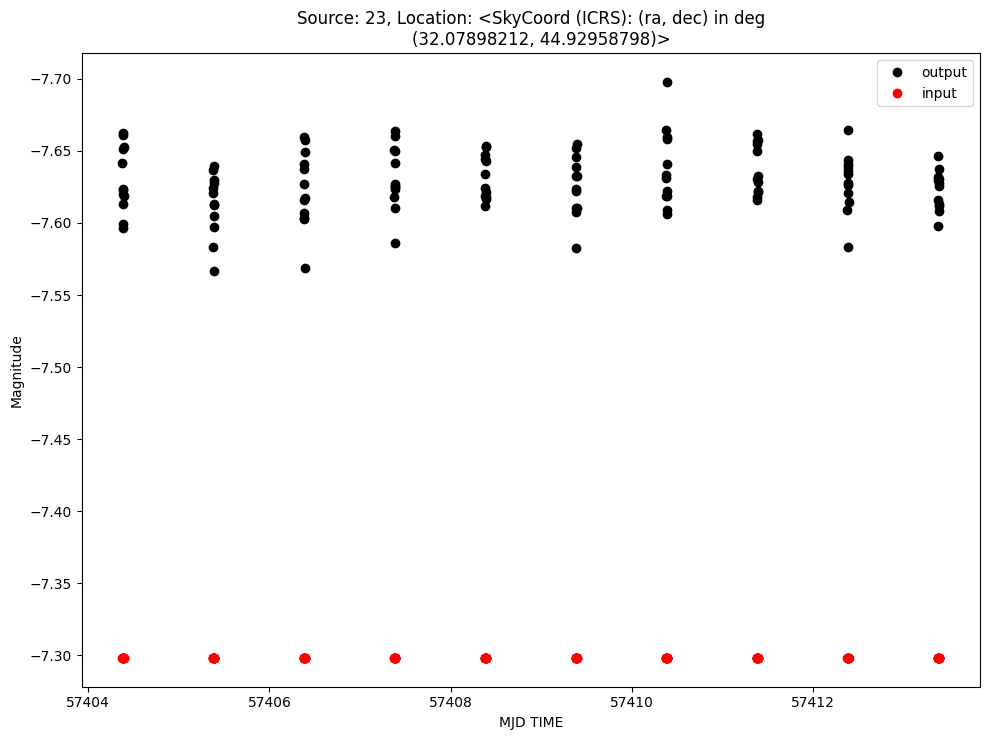

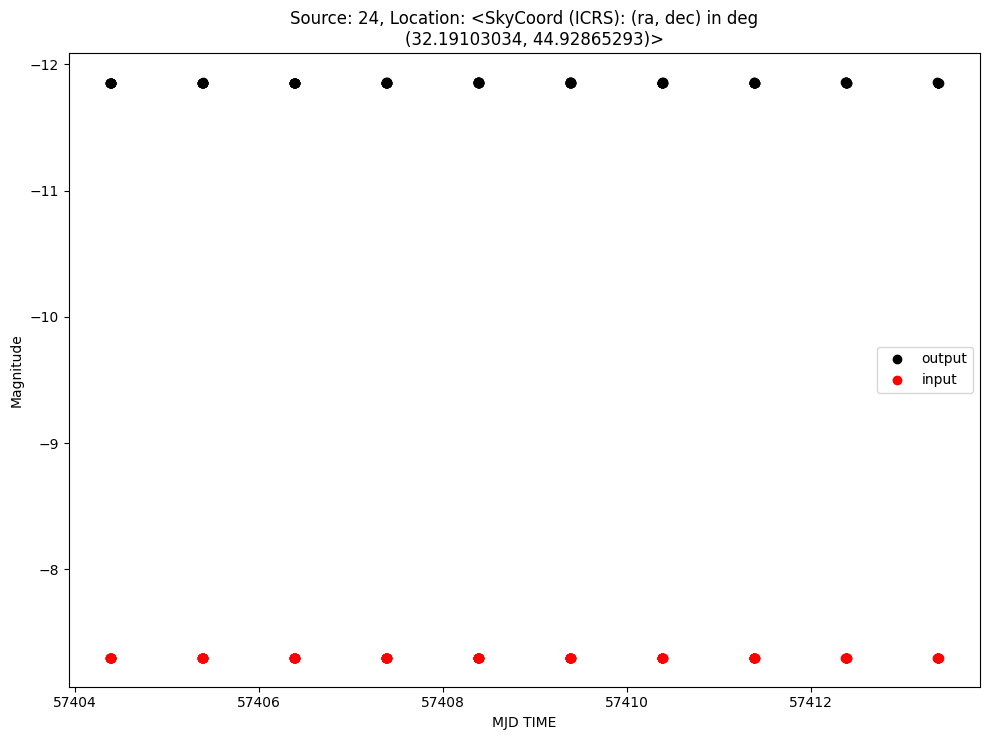

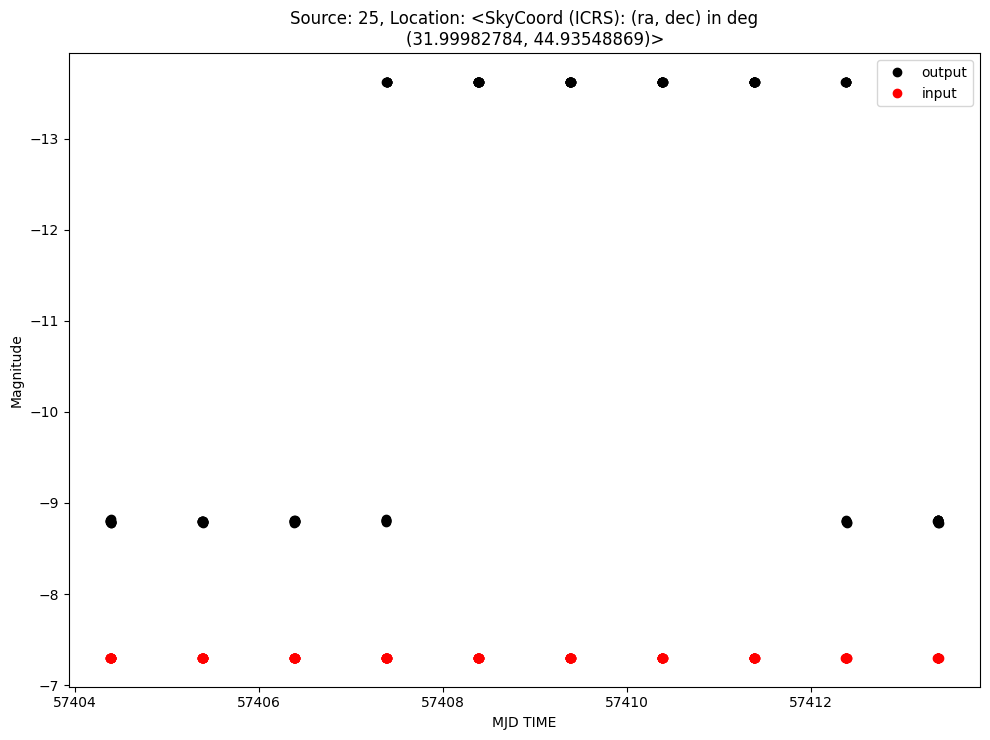

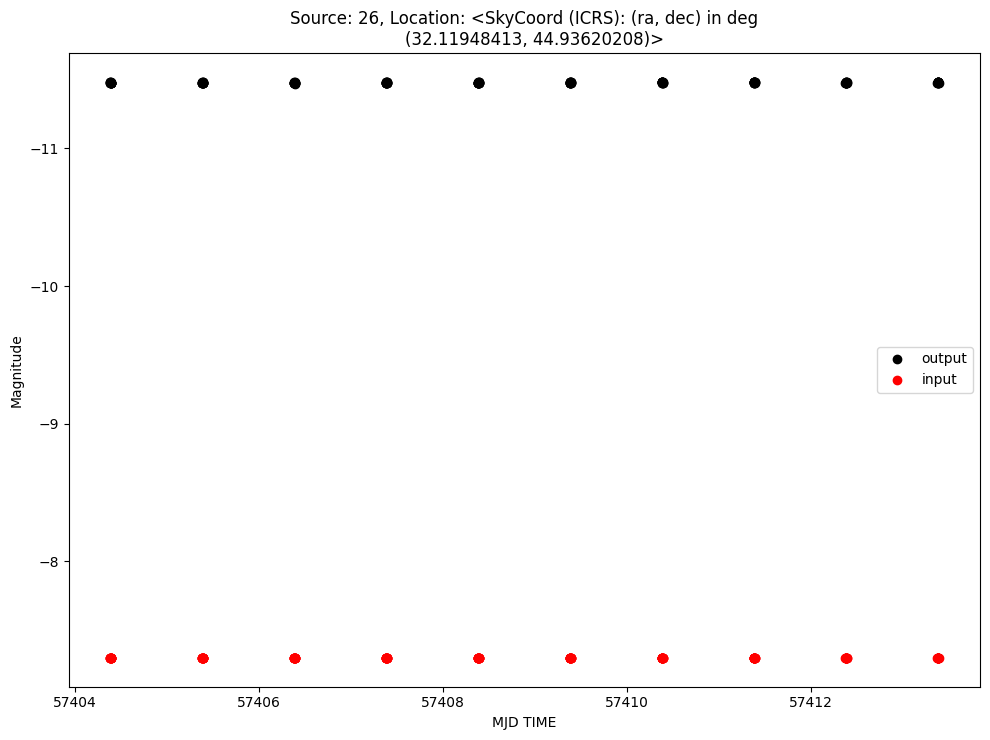

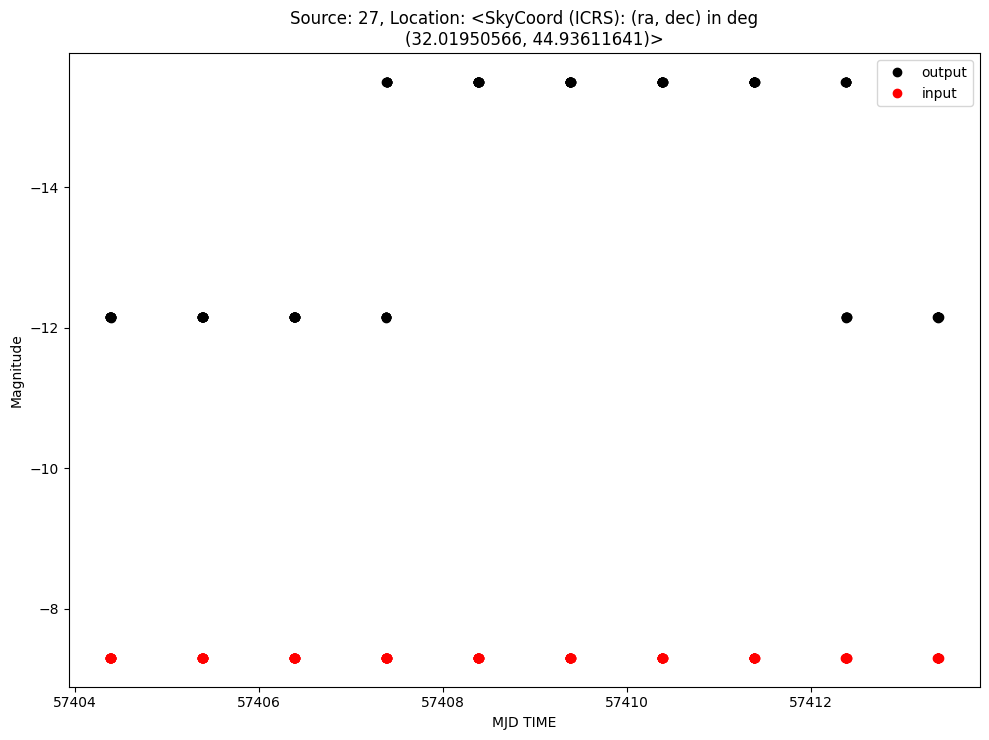

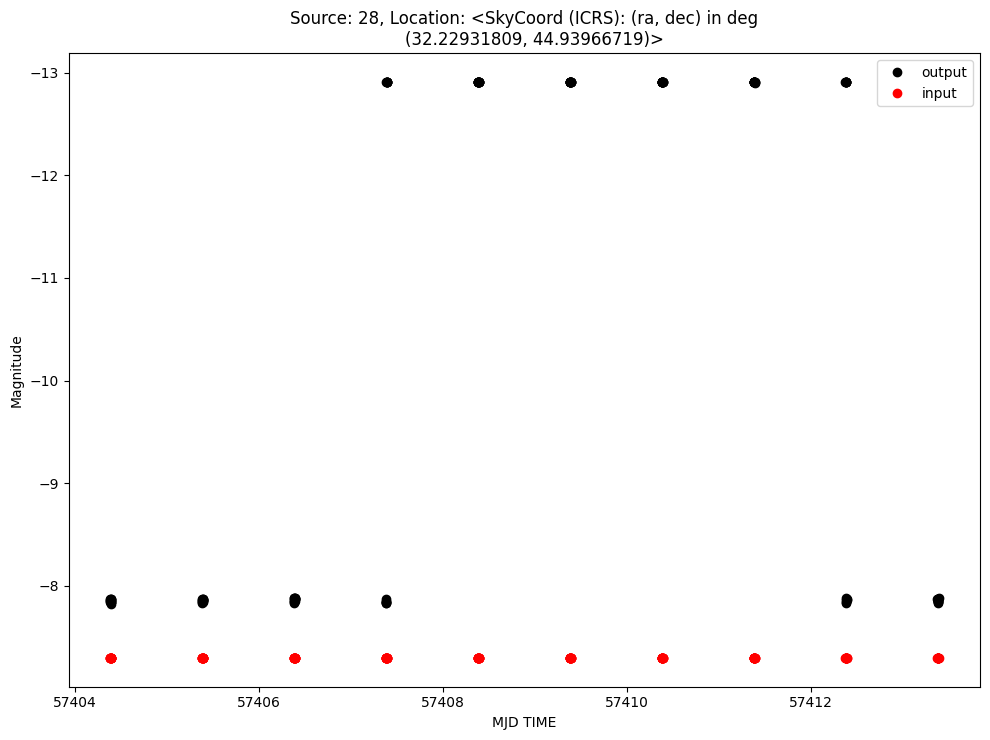

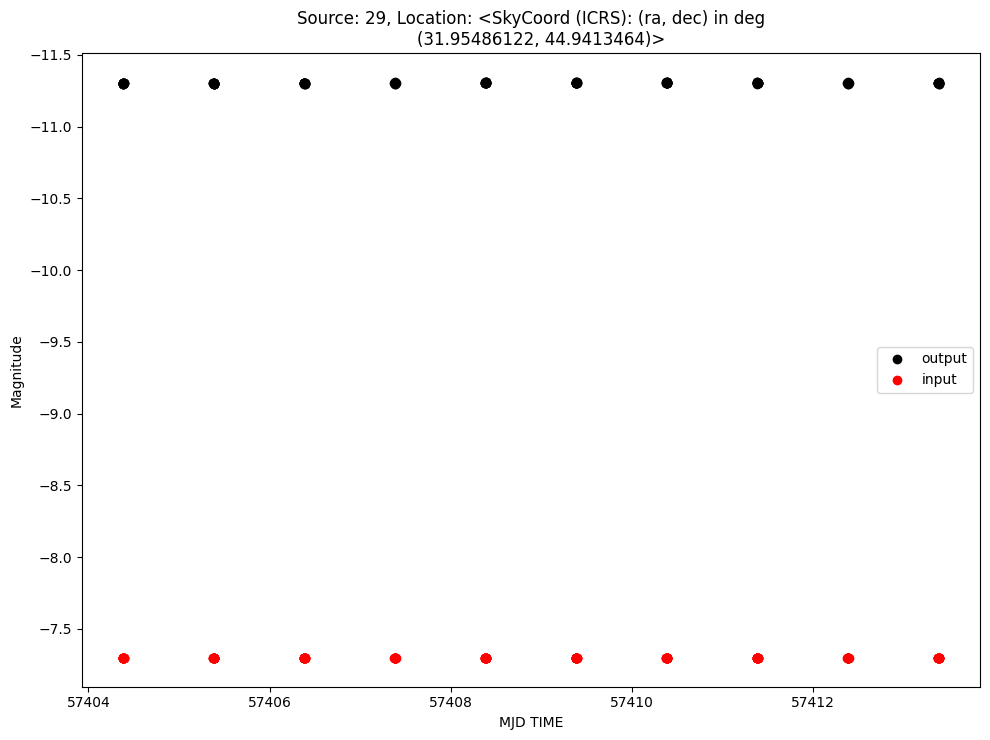

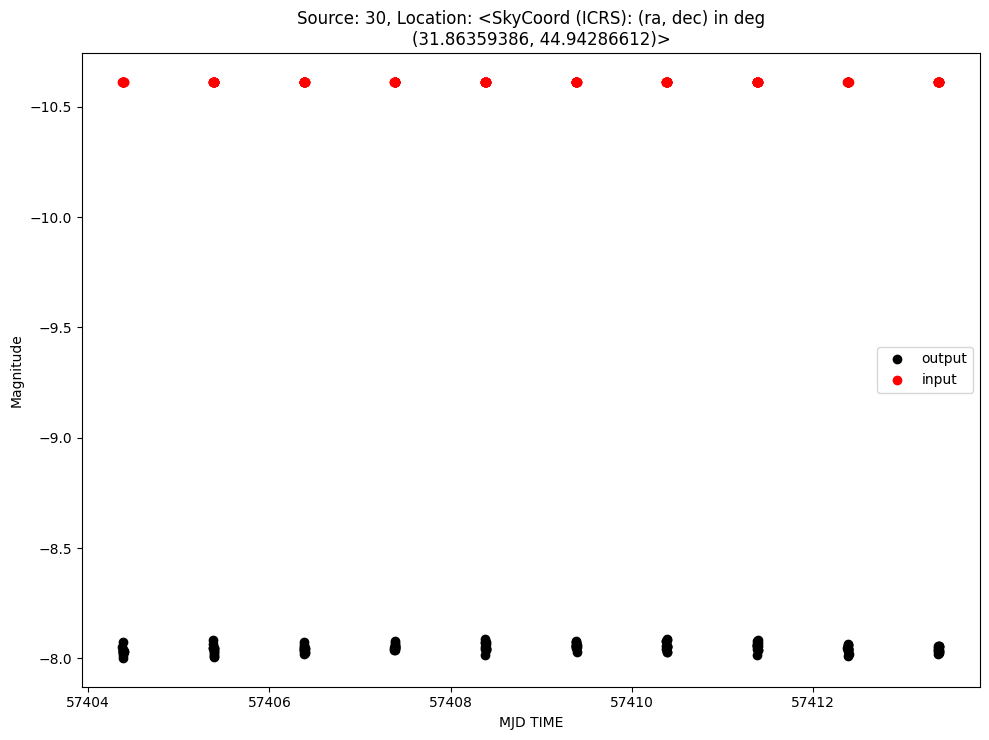

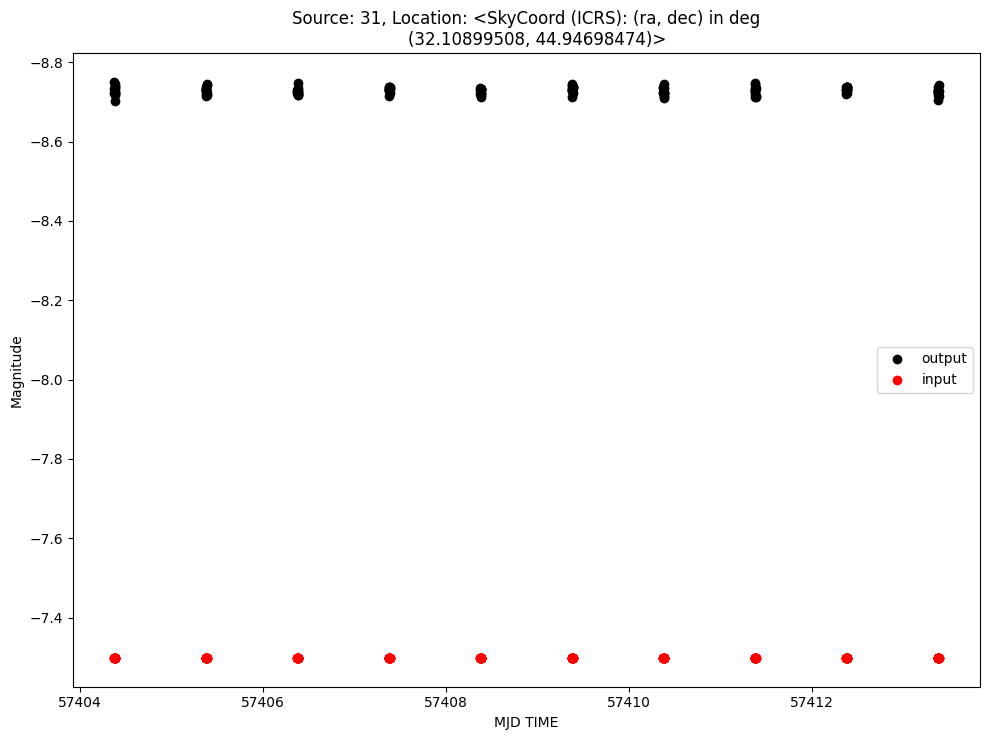

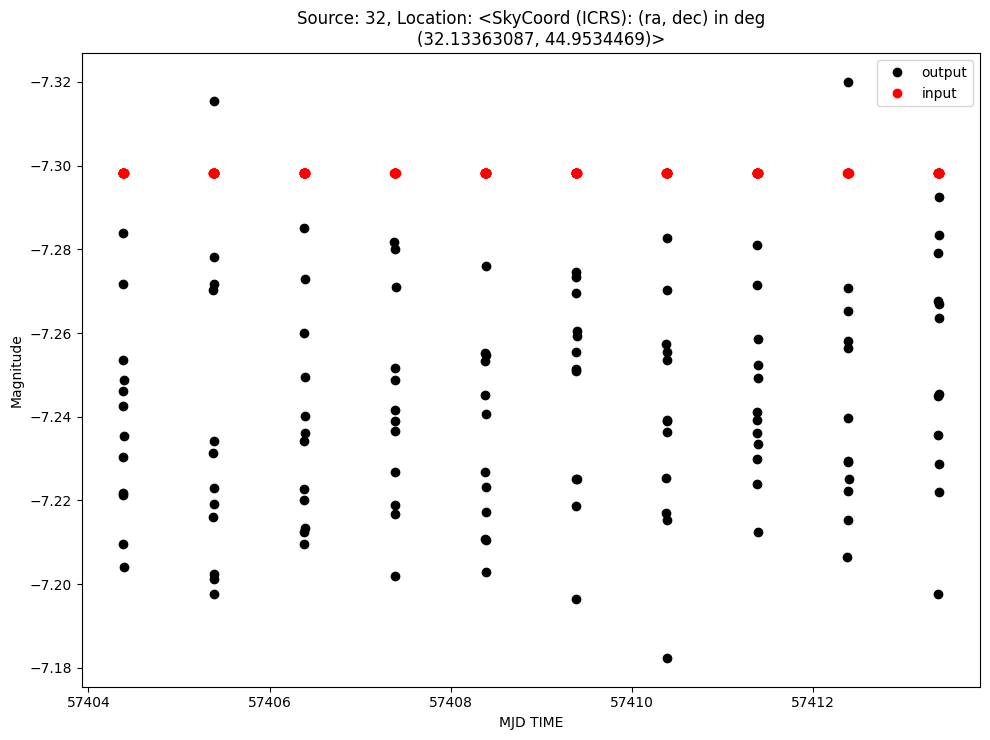

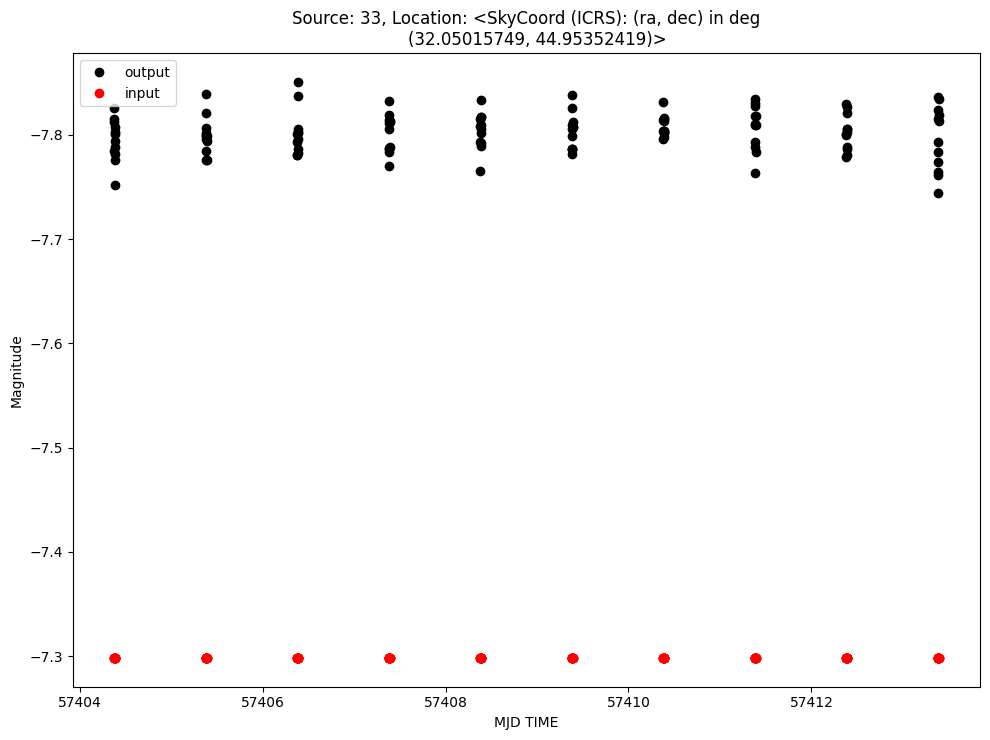

IndexError: list index out of range

In [13]:
# Compare the simulation magnitude and pipeline detected magnitude
Inputdata = InputData("/Users/wendy/Desktop/Pipeline/Simulation_codes/Simulations/Sim 2/data")
Inputdata.load_data()
Inputdata.sort_data()

dummy = []
for night in Nights:
    time = night.mjd_times # Make sure the input data and the analyzed image match up
    dummy.append(time)
flattened_array = np.array(dummy).flatten()
flattened_list = flattened_array.tolist()
sorted_indices = sorted(range(len(flattened_list)), key=lambda i: flattened_list[i])
mjd_times = [flattened_list[i] for i in sorted_indices]

frame_ra = Inputdata.ra[0] # Gets the input ra of all stars in frame 1, for simplicity the position of all stars are fixed though all frames
frame_dec = Inputdata.dec[0] # Gets the input dec of all stars in frame 1, for simplicity the position of all stars are fixed though all frames
frame_mag = Inputdata.mag  # Gets the input mag of all stars in all frames

distance_threshold = 0.2 # Two stars are considers to be the same if their distance is below this value

for source in Sources: # For one star in all detected sources
    source_position = source.position # Get the star's ra and dec
    detected_ra = source_position.ra.deg # make sure it's pure number
    detected_dec = source_position.dec.deg # make sure it's pure number

    source_mag = source.inst_mags # Get the star's mag through all frames
    sorted_output_mag = [source_mag[i] for i in sorted_indices] # Make sure the order of the mag list is correct
    sorted_input_mag = [] 

    for x, y in zip(frame_ra, frame_dec): # find the index of the star in input dataframe
        distance = np.sqrt((x - detected_ra)**2 + (y - detected_dec)**2)
        if distance <= distance_threshold:
            star_index = np.where(frame_ra == x)
    for mags in frame_mag:
        star_mag = mags[star_index]
        sorted_input_mag.append(star_mag - 33.4)
        
    plt.figure(figsize=(10,7.5))
    plt.title(f"Source: {source.source_id}, Location: {source.position}")
    plt.plot(mjd_times, sorted_output_mag, linestyle="", marker="o", color="black", label = "output")
    plt.plot(mjd_times, sorted_input_mag, linestyle="", marker="o", color="red", label = "input")
    plt.xlabel("MJD TIME")
    plt.ylabel(f"Magnitude")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.legend()
    plt.show()

In [11]:
slopes = []
zeros = []
slope_errs = []
zero_errs = []

counter = 0

for night in Nights:
    for image in night.aligned_images:
        instrumental_magnitudes = [s.inst_mags[counter] for s in Sources if s.flagged != True]
        reference_magnitudes = instrumental_magnitudes
        jk_params = np.zeros((len(instrumental_magnitudes), 2))
        for i in range(len(instrumental_magnitudes)):
            x_sample = np.append(instrumental_magnitudes[:i], instrumental_magnitudes[i+1:])
            y_sample = np.append(reference_magnitudes[:i], reference_magnitudes[i+1:])
            jk_params[i] = ODR(x_sample, y_sample)

        mean_params = np.mean(jk_params, axis = 0)
        sig_params = np.std(jk_params, axis = 0)

        slopes.append(mean_params[0])
        zeros.append(mean_params[1])
        slope_errs.append(sig_params[0])
        zero_errs.append(sig_params[1])

        counter += 1
        

In [12]:
for source in Sources:
    if source.flagged != True:
        for i in range(0, len(slopes)):
            mag = (source.inst_mags[i]*slopes[i] + zeros[i])
            # final_err = np.sqrt((slopes[i]* source.inst_mags[i])**2 * ((slope_errs[i]/slopes[i])**2 + (source.inst_mag_errs[i]/source.inst_mags[i])**2) + zero_errs[i]**2)
            final_err = source.inst_mag_errs[i]
            source.add_calibrated_mag(mag)
            # print(final_err)
            source.add_error(final_err)

print(len(source.calibrated_mags))

120


120


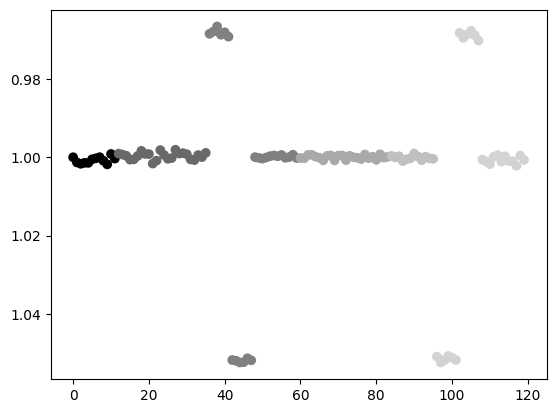

In [13]:
color_arr = np.array(sorted(CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c)))))
l = np.arange(0, len(source.calibrated_mags))

median_curves = []
for night in Nights:
    median_mags = []
    index_l = len(night.image_data)*night.obs_night
    index_h = len(night.image_data)*(1+night.obs_night)
    for source in Sources:
        if source.flagged != True:
            median_mags.append(source.calibrated_mags[index_l:index_h])
    median_curve = np.median(median_mags, axis = 0)/np.median(median_mags)
    median_curves.append(median_curve)
med_curve = np.concatenate(median_curves)

print(len(med_curve))

plt.scatter(l, med_curve, c = color_arr[np.array(night_array)])
plt.gca().invert_yaxis()
plt.show()

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.24116891, 44.83529902)>, Night_0_xy: (array(347.43437993), array(11.5304184)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.35236855239498, cal_mag_avg: -7.35236855239498, flagged: False, ID: 0, Chi2: None
None
[0.15066744856694136, 0.14838454760275302, 0.14746300086483966, 0.15064309103898801, 0.14980266552728205, 0.1483340294025161, 0.1496502139467075, 0.1505275282086927, 0.148422629485374, 0.15006989756829953]


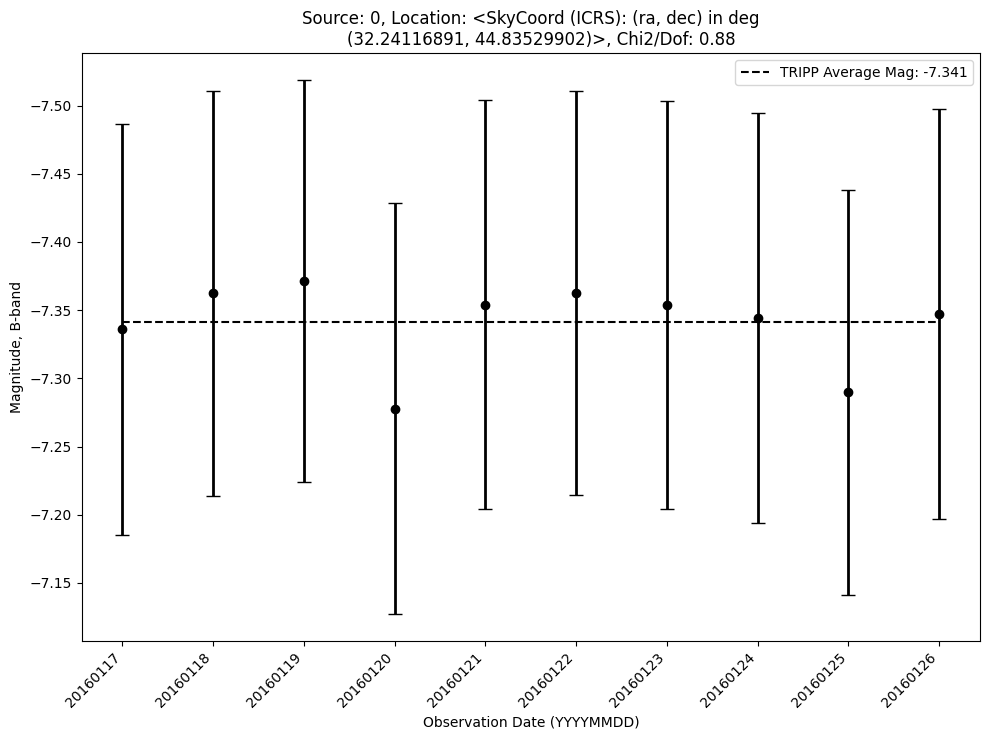

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.20233456, 44.84392798)>, Night_0_xy: (array(521.51221048), array(65.52074346)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.233254826987802, cal_mag_avg: -7.233254826987802, flagged: False, ID: 1, Chi2: None
None
[0.16602751586631925, 0.16689755157168168, 0.16795646815115445, 0.1649607966220561, 0.16505408519368203, 0.1659065792792333, 0.16678313233988504, 0.16686896080484187, 0.16775997014162727, 0.16748564378313574]


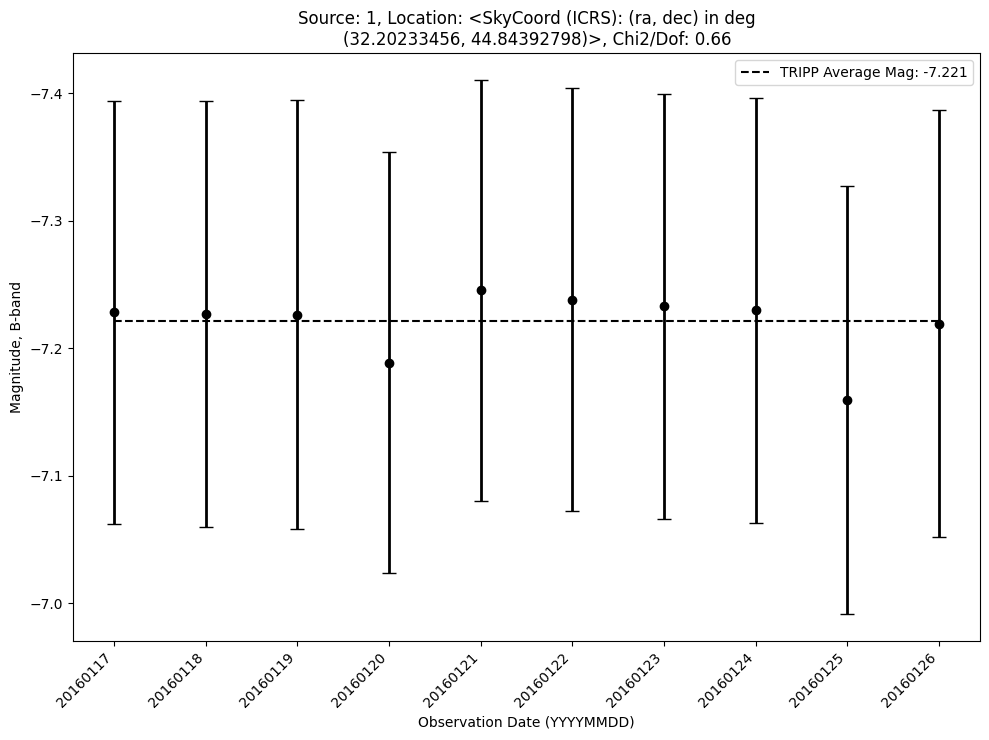

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.70412282, 44.84553141)>, Night_0_xy: (array(2752.52340674), array(76.49412699)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.531957792118341, cal_mag_avg: -8.531957792118341, flagged: False, ID: 2, Chi2: None
None
[0.07811918093043188, 0.077839418492374, 0.07731823229046855, 0.07741409187578999, 0.07794933738703219, 0.07800130324977078, 0.0778983700994014, 0.07732360746777373, 0.07759806762117073, 0.07766586777530354]


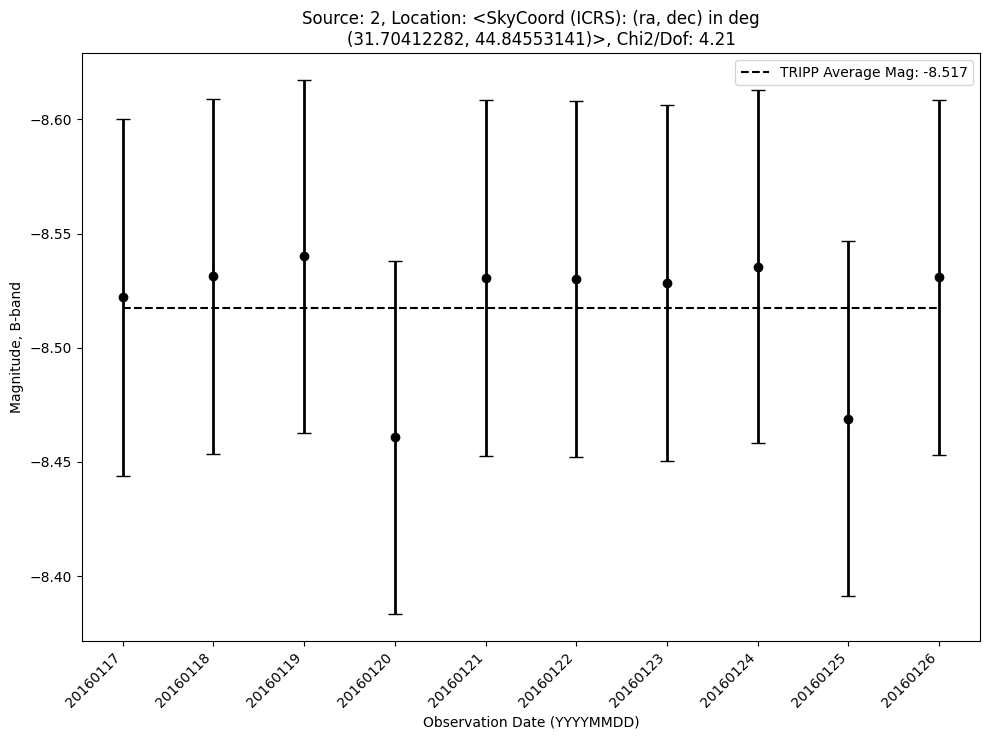

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.97635161, 44.85743443)>, Night_0_xy: (array(1533.47974797), array(149.5137707)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.296229942378018, cal_mag_avg: -8.296229942378018, flagged: False, ID: 3, Chi2: None
None
[0.0800433649633566, 0.0802072531711155, 0.08015384666793718, 0.07993044319119956, 0.07990424706814066, 0.07972174449905362, 0.07987868138790058, 0.08023459724090193, 0.07980730188051424, 0.0800360130310247]


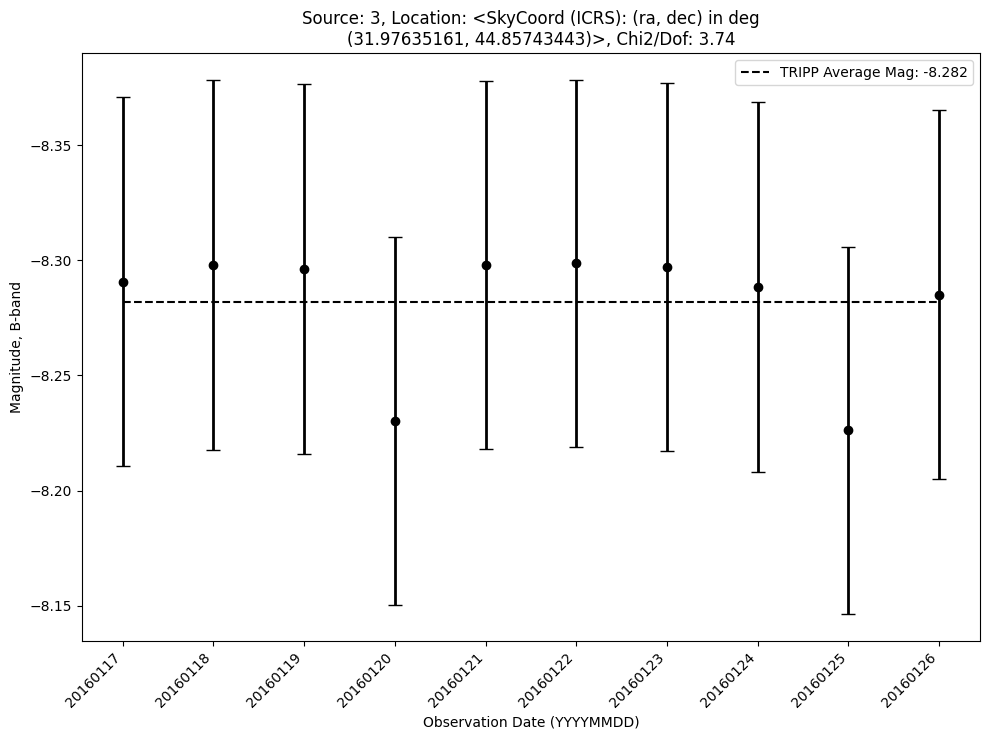

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.72125237, 44.86140571)>, Night_0_xy: (array(2675.49216501), array(176.49727642)) rad: 13.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.042548515364027, cal_mag_avg: -11.042548515364027, flagged: False, ID: 4, Chi2: None
None
[0.019611919327587015, 0.019604839451240128, 0.01964703519110727, 0.019622778525939938, 0.01962879004871773, 0.0196121419867119, 0.019653438576209437, 0.01963299164026052, 0.019650241314260464, 0.019673027056719142]


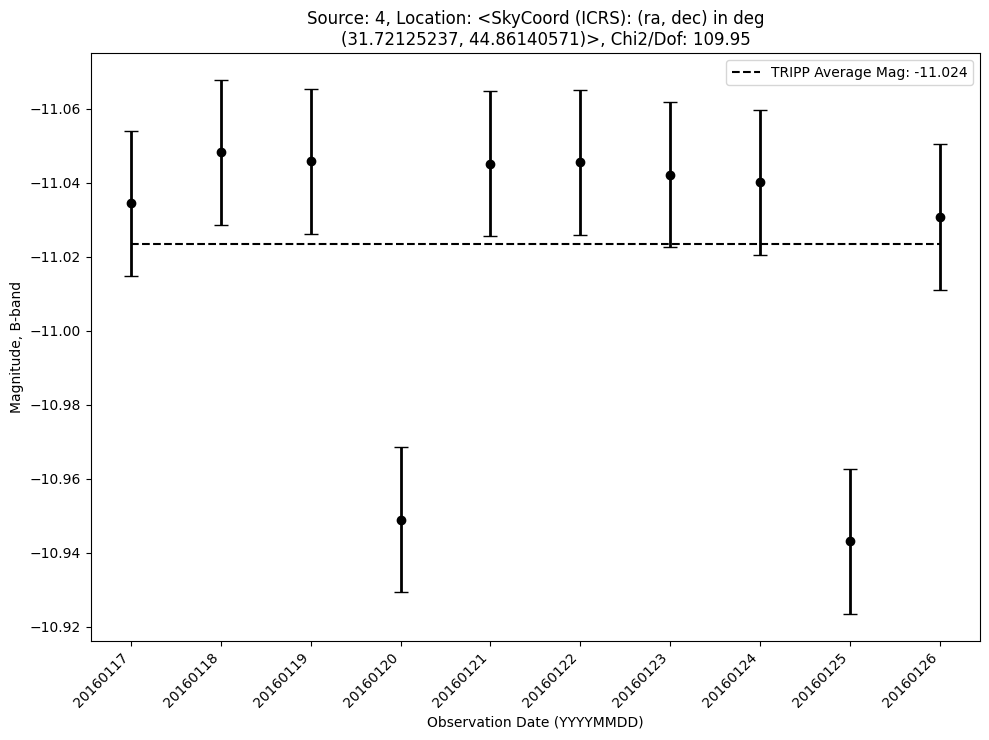

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.79853307, 44.86361497)>, Night_0_xy: (array(2329.493325), array(189.49576023)) rad: 19.5, ref_status: None, ref_mag: None, inst_mag_avg:-13.806146736212872, cal_mag_avg: -13.806146736212872, flagged: False, ID: 5, Chi2: None
None
[0.011917783872929778, 0.011913734450773983, 0.011919127769041759, 0.00644031724353782, 0.0010137592372759766, 0.001013791550724671, 0.0010137872179719377, 0.001013848236517588, 0.006452608778689693, 0.011925199539015975]


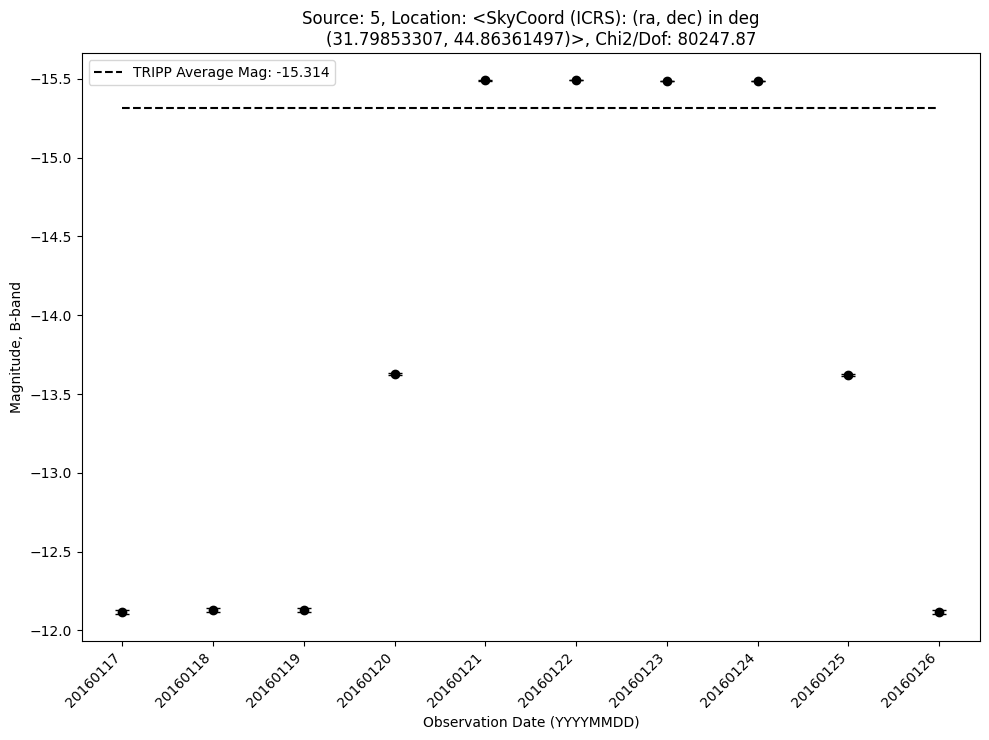

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.10928521, 44.86907568)>, Night_0_xy: (array(938.44299621), array(223.46836317)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.925459436651385, cal_mag_avg: -8.925459436651385, flagged: False, ID: 6, Chi2: None
None
[0.2920788909034505, 0.3061739743686117, 0.30635254938601625, 0.155341610202907, 0.0056820287590650335, 0.005680025870385028, 0.005682847150138025, 0.005679830832494383, 0.15648741622275567, 0.30483056045042967]


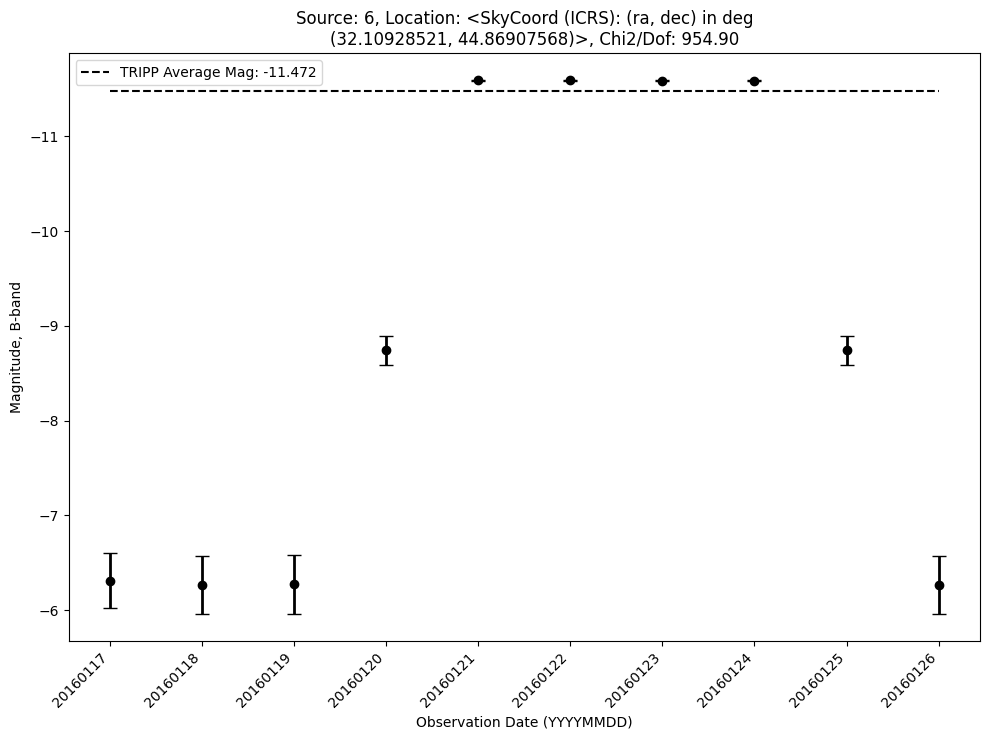

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.19286163, 44.87957196)>, Night_0_xy: (array(564.51316043), array(290.53027462)) rad: 11.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.130121005022469, cal_mag_avg: -10.130121005022469, flagged: False, ID: 7, Chi2: None
None
[0.03437477604347208, 0.03422863782062874, 0.03437846752713889, 0.0342140045971832, 0.034328134793224094, 0.034294728109465135, 0.03423635083793351, 0.034356712436266534, 0.034435621506193004, 0.034333440683108216]


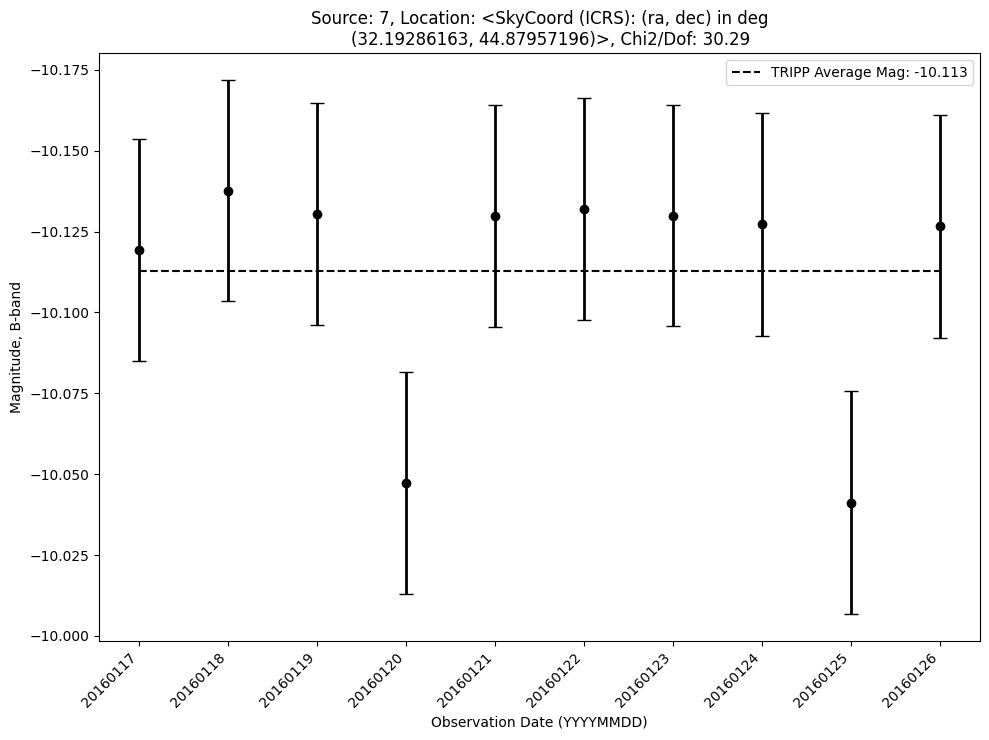

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.19335095, 44.8898582)>, Night_0_xy: (array(562.49108012), array(355.50187438)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.943106850035703, cal_mag_avg: -7.943106850035703, flagged: False, ID: 8, Chi2: None
None
[0.10874036141975921, 0.10946767244537121, 0.10873136579756293, 0.1090002479605854, 0.10980009606367917, 0.11007080706114061, 0.10929883492102471, 0.10819212212357326, 0.10965689040413704, 0.11010997473524367]


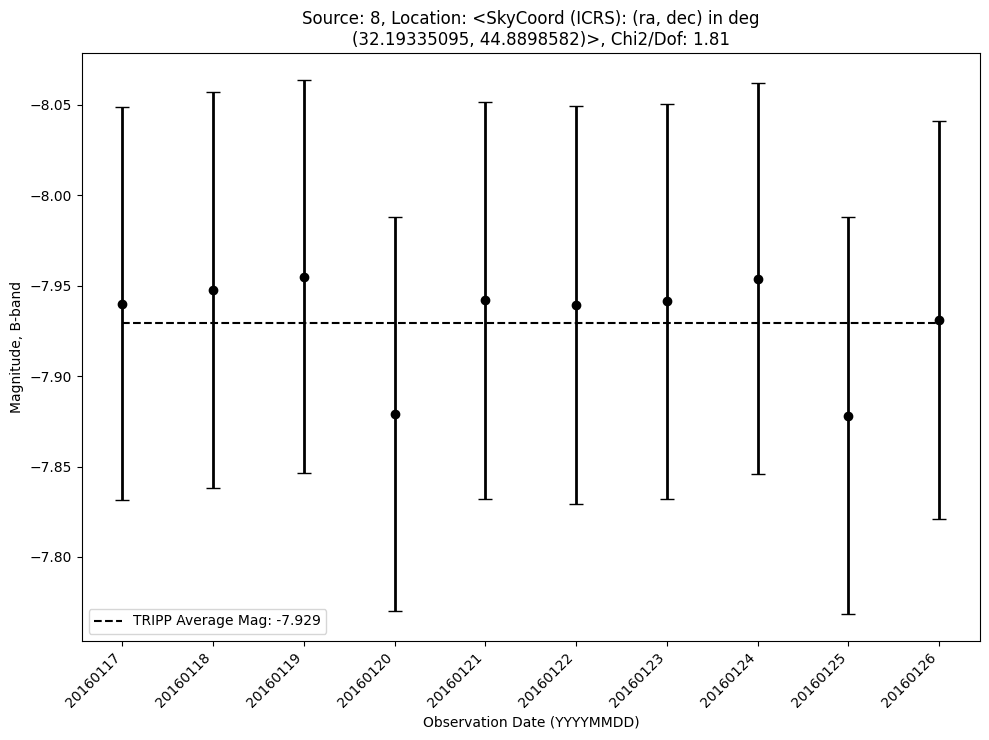

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.04763466, 44.89272158)>, Night_0_xy: (array(1214.51690798), array(372.49067146)) rad: 12.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.440488321743407, cal_mag_avg: -10.440488321743407, flagged: False, ID: 9, Chi2: None
None
[0.028937281788285373, 0.02898267453774149, 0.02888113773556269, 0.028896294998212054, 0.028910142601956734, 0.028954664283840952, 0.02893415349248603, 0.028897160847203267, 0.02893816657025888, 0.02887703919555149]


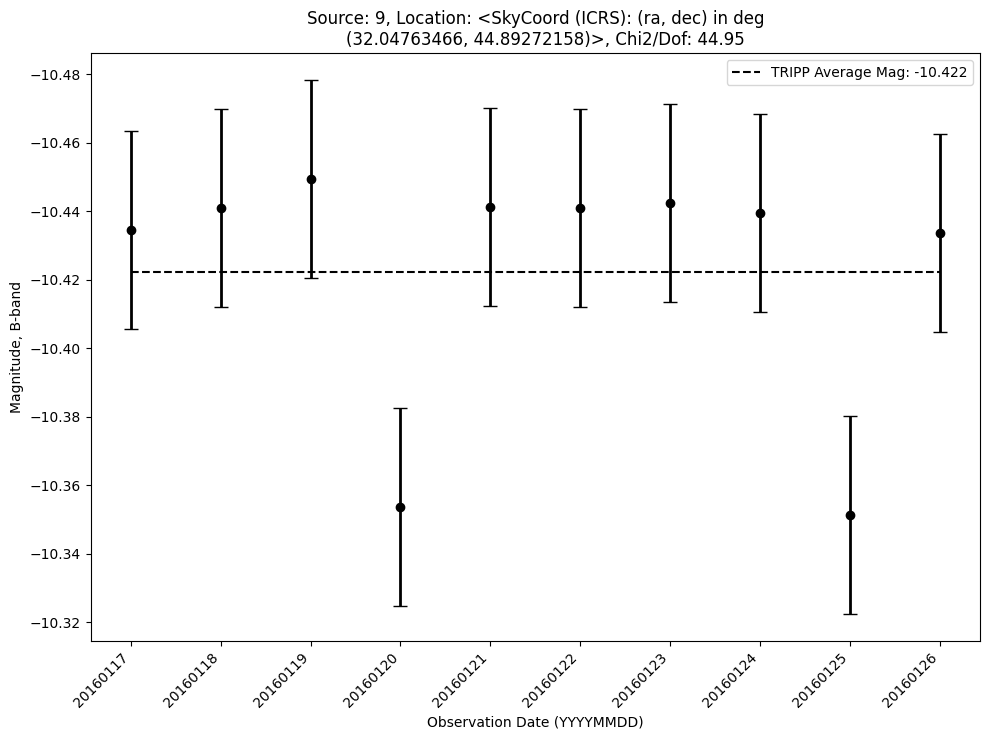

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.91531475, 44.89414735)>, Night_0_xy: (array(1806.54812725), array(381.5143845)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.694059954469156, cal_mag_avg: -5.694059954469156, flagged: False, ID: 10, Chi2: None
None
[0.3876047233028373, 0.37261374981771633, 0.37244671865973034, 0.35770887332360374, 0.36127079766359915, 0.35822691111251026, 0.3411737358297834, 0.3620445241075516, 0.3563318698629412, 0.36686092237551726]


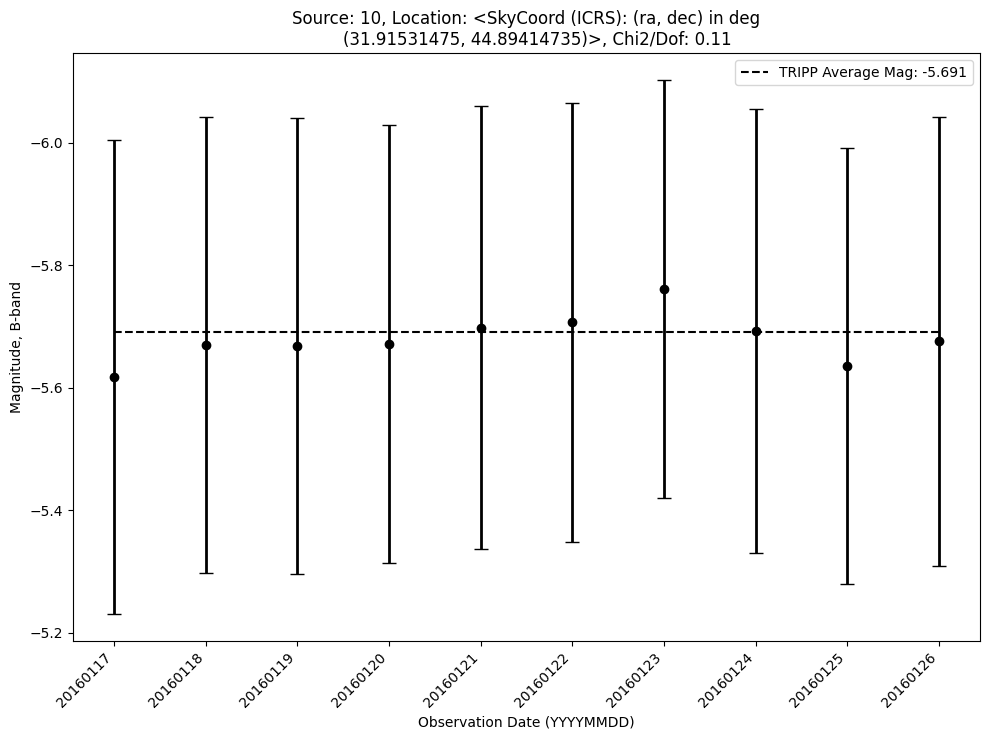

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.13190468, 44.89438748)>, Night_0_xy: (array(837.48657144), array(383.50321101)) rad: 13.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.687078036874334, cal_mag_avg: -10.687078036874334, flagged: False, ID: 11, Chi2: None
None
[0.02556005745905466, 0.02561172351785539, 0.025566939911671034, 0.025607591962388928, 0.02564628885168751, 0.025575814031867514, 0.025620506735646982, 0.025630007887017886, 0.025630740282913463, 0.02561479102252041]


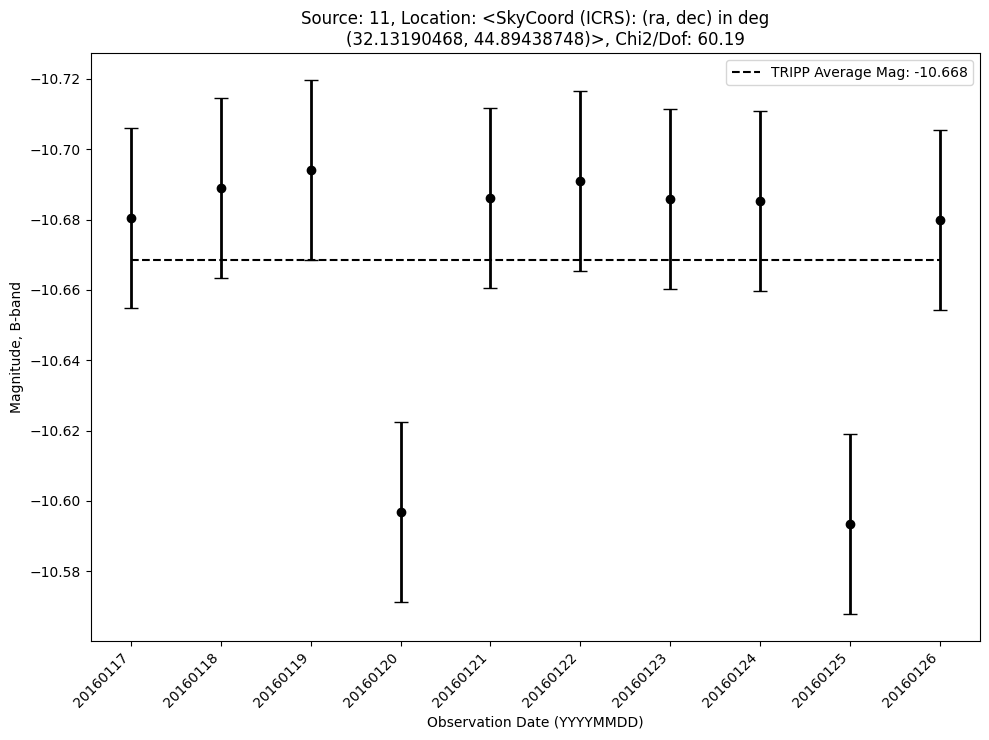

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.93164503, 44.89573828)>, Night_0_xy: (array(1733.47684246), array(391.50786536)) rad: 9.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.60356039574776, cal_mag_avg: -9.60356039574776, flagged: False, ID: 12, Chi2: None
None
[0.04365750284832626, 0.04363185144623557, 0.043773339670464276, 0.0433609409880137, 0.04298699348786024, 0.042880323690952335, 0.04305898971626976, 0.042820698190260305, 0.043355997684757806, 0.04368738229043219]


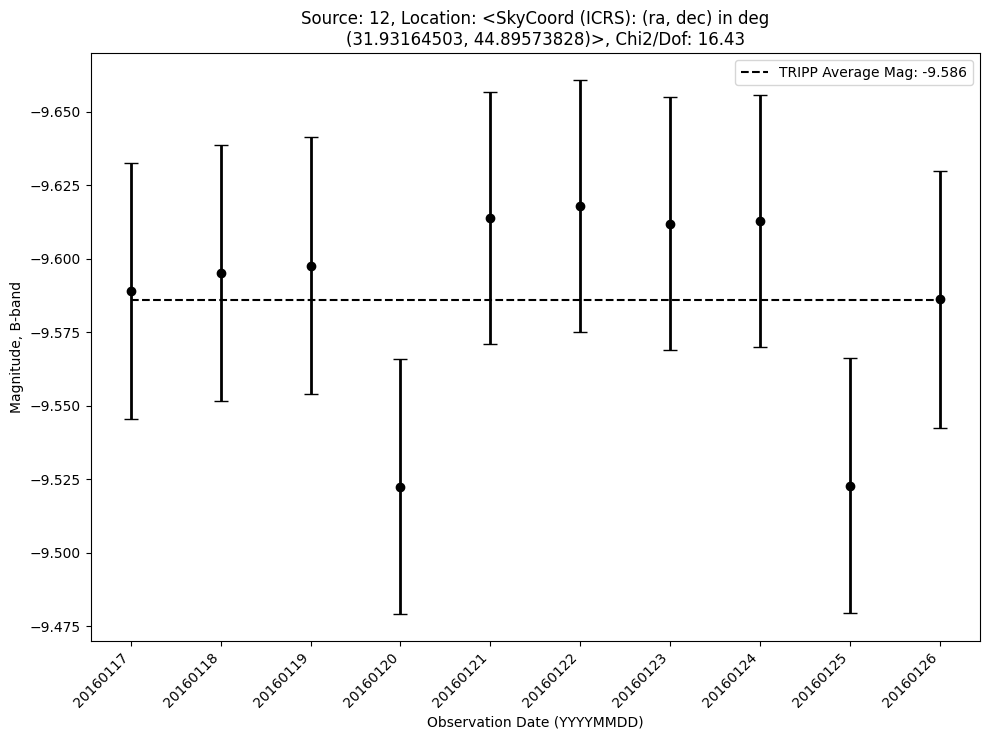

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.27451202, 44.89712479)>, Night_0_xy: (array(199.49686146), array(402.51403646)) rad: 14.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.187246356948439, cal_mag_avg: -11.187246356948439, flagged: False, ID: 13, Chi2: None
None
[0.018838963779475446, 0.018830176205152222, 0.018818590580207344, 0.018850757889543462, 0.018819099446501793, 0.018807802769649308, 0.01882593808745716, 0.018836194171661956, 0.018828135782697854, 0.018829840867242847]


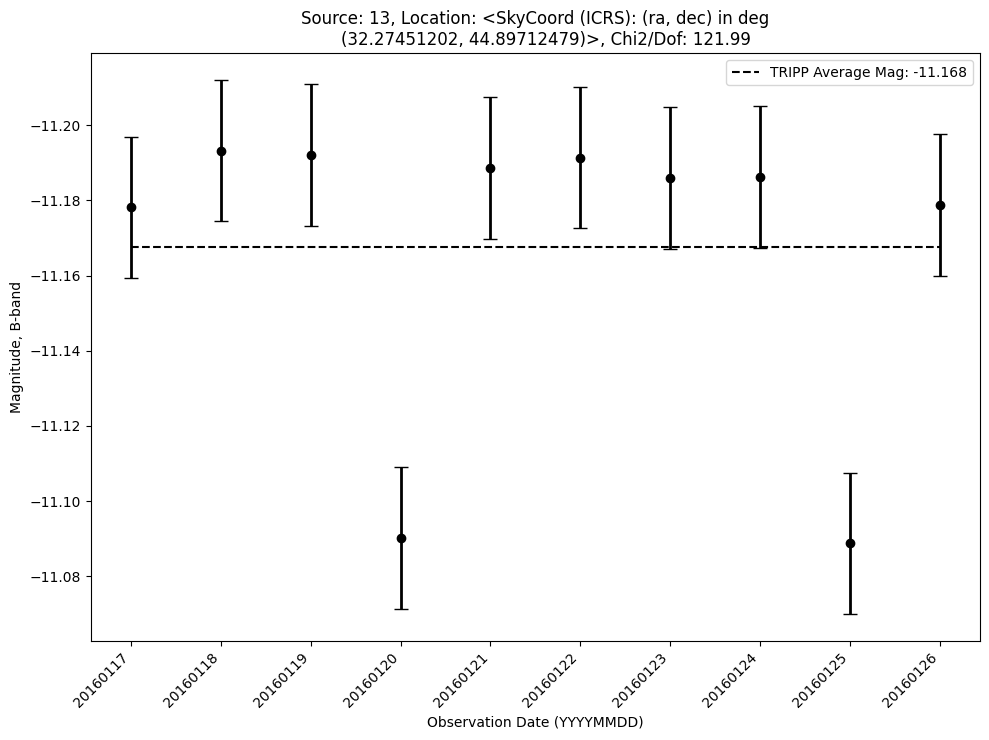

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.01166628, 44.90888429)>, Night_0_xy: (array(1375.48502053), array(474.48080037)) rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.439913355141224, cal_mag_avg: -9.439913355141224, flagged: False, ID: 14, Chi2: None
None
[0.04099678030420589, 0.04102457471849551, 0.04104758919622124, 0.04082630233841299, 0.040735817737774856, 0.04080444961872126, 0.04076749835408472, 0.04072415681460375, 0.040889641797350995, 0.04100889688054375]


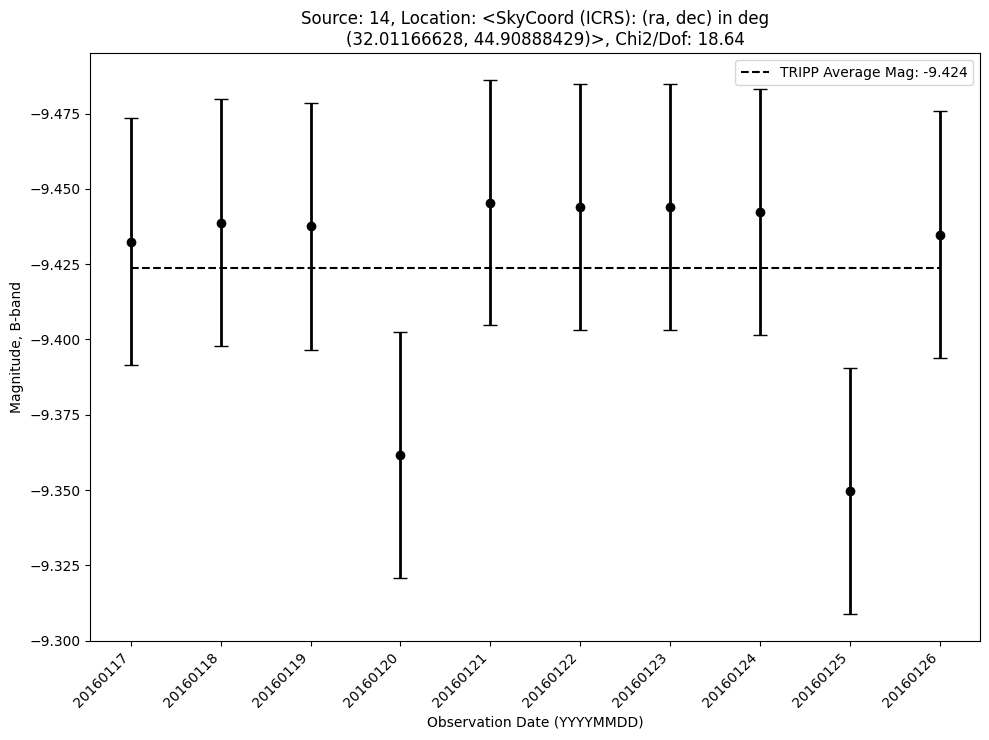

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.85606421, 44.90929285)>, Night_0_xy: (array(2071.49523023), array(477.49158848)) rad: 13.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.976213862185322, cal_mag_avg: -10.976213862185322, flagged: False, ID: 15, Chi2: None
None
[0.020800011471635287, 0.020827628383944922, 0.020812599286751554, 0.02077427529524526, 0.020764550058276945, 0.02080485342206102, 0.020804982271575664, 0.020791850268743015, 0.020787155903366605, 0.020806808717743007]


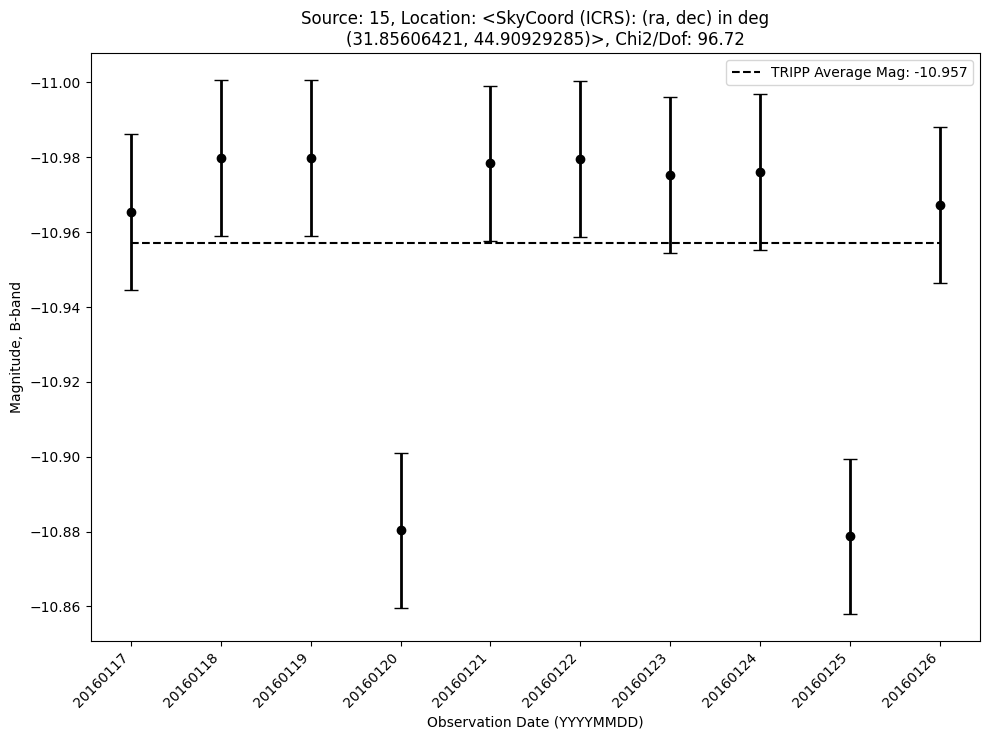

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.9385522, 44.9158479)>, Night_0_xy: (array(1702.5024174), array(518.4976525)) rad: 12.5, ref_status: None, ref_mag: None, inst_mag_avg:-13.402226489484606, cal_mag_avg: -13.402226489484606, flagged: False, ID: 16, Chi2: None
None
[0.029190696660402422, 0.02906760483242793, 0.02923733528576412, 0.014817362972959585, 0.000618506204459396, 0.0006185182516034136, 0.0006185345615449016, 0.000618515554805241, 0.014861479343244182, 0.029209894901139836]


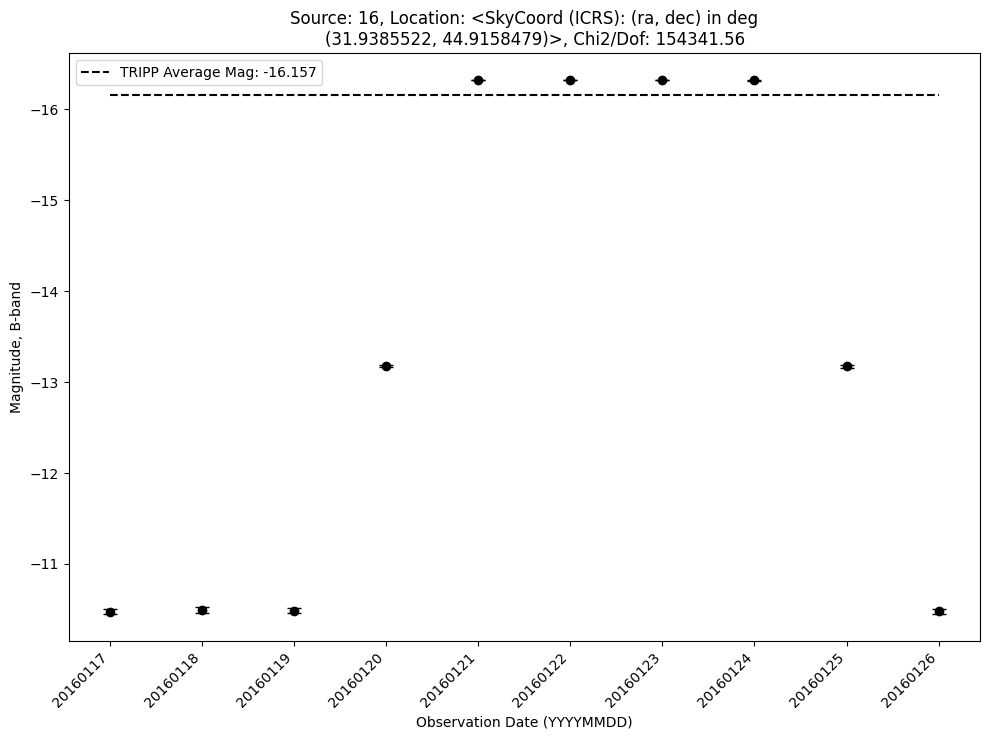

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.19233739, 44.91804266)>, Night_0_xy: (array(567.48377351), array(533.49777532)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.448384415672143, cal_mag_avg: -6.448384415672143, flagged: False, ID: 17, Chi2: None
None
[0.26531175574718935, 0.2618825540489985, 0.2637269903213777, 0.26183412314400967, 0.2550440432439468, 0.254870880732613, 0.25332022318732605, 0.2538026436764949, 0.25922952042974734, 0.2604715330623497]


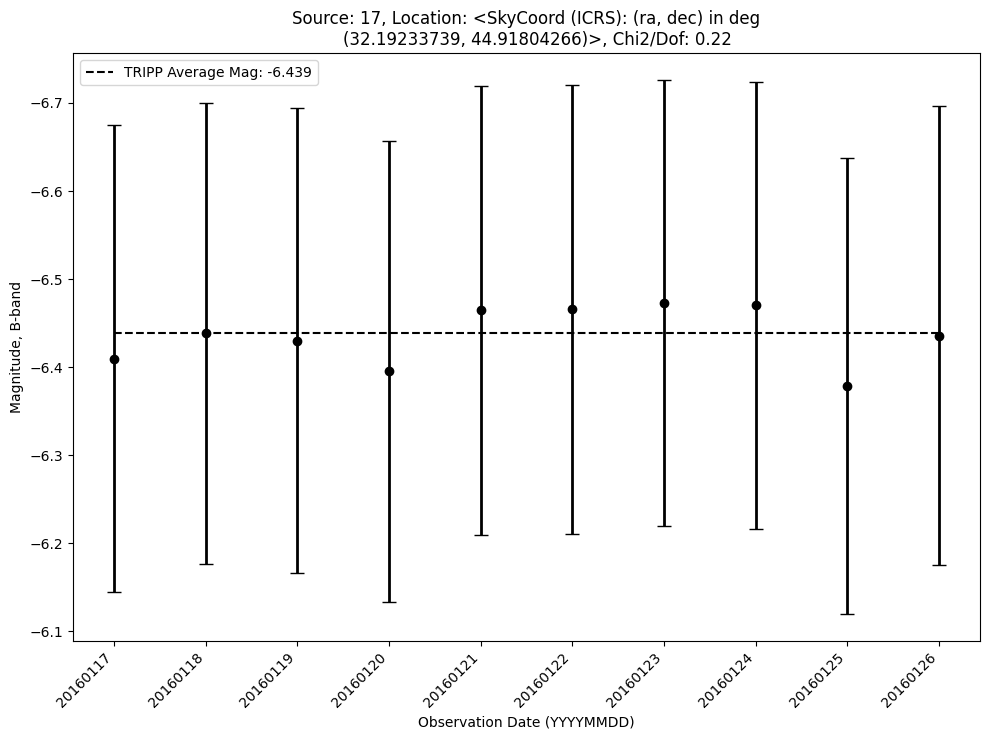

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.2153629, 44.91847335)>, Night_0_xy: (array(464.51359818), array(536.49688209)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-6.648020457586241, cal_mag_avg: -6.648020457586241, flagged: False, ID: 18, Chi2: None
None
[0.24902528906811044, 0.24764600317731278, 0.2516003479475305, 0.24683456232058598, 0.2496577883097818, 0.24411553399799557, 0.24694682391973508, 0.25490067694836904, 0.249909276950399, 0.24713483233303565]


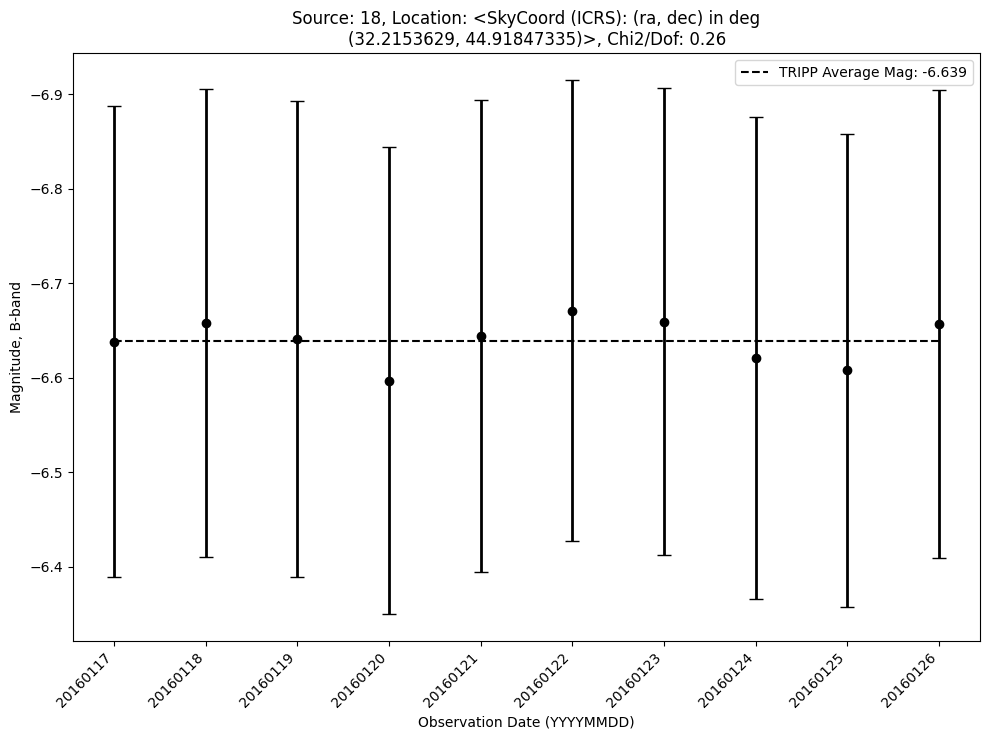

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.17243706, 44.91807787)>, Night_0_xy: (array(656.48532143), array(533.5026379)) rad: 19.0, ref_status: None, ref_mag: None, inst_mag_avg:-13.703145140921485, cal_mag_avg: -13.703145140921485, flagged: False, ID: 19, Chi2: None
None
[0.013177905969310042, 0.0131785270146005, 0.013155066608745412, 0.007089025366000961, 0.001036214872260472, 0.0010360935857683898, 0.0010361236281085401, 0.0010361529987223343, 0.007087663478602011, 0.013169994758146196]


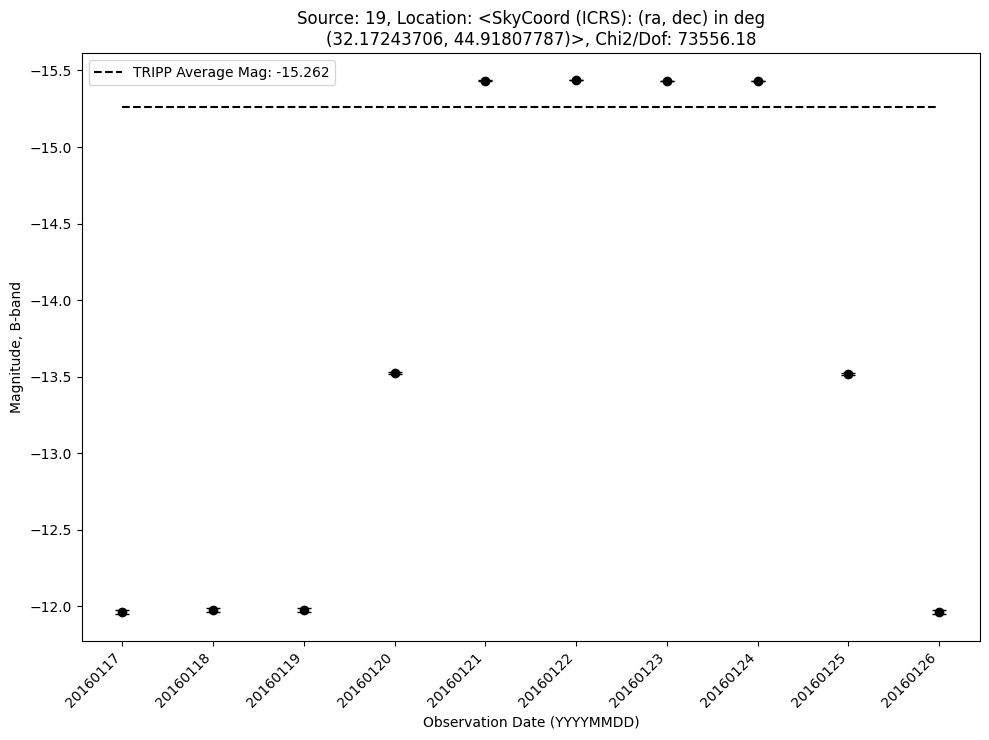

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.03179606, 44.92281301)>, Night_0_xy: (array(1285.49554895), array(562.4936398)) rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.534687153243851, cal_mag_avg: -9.534687153243851, flagged: False, ID: 20, Chi2: None
None
[0.037840267337824245, 0.03790384644459404, 0.03781404457144613, 0.03761009362569606, 0.03755981822792752, 0.03754289692924109, 0.037528301017036345, 0.03750466881142644, 0.03771533466162021, 0.037760953388291926]


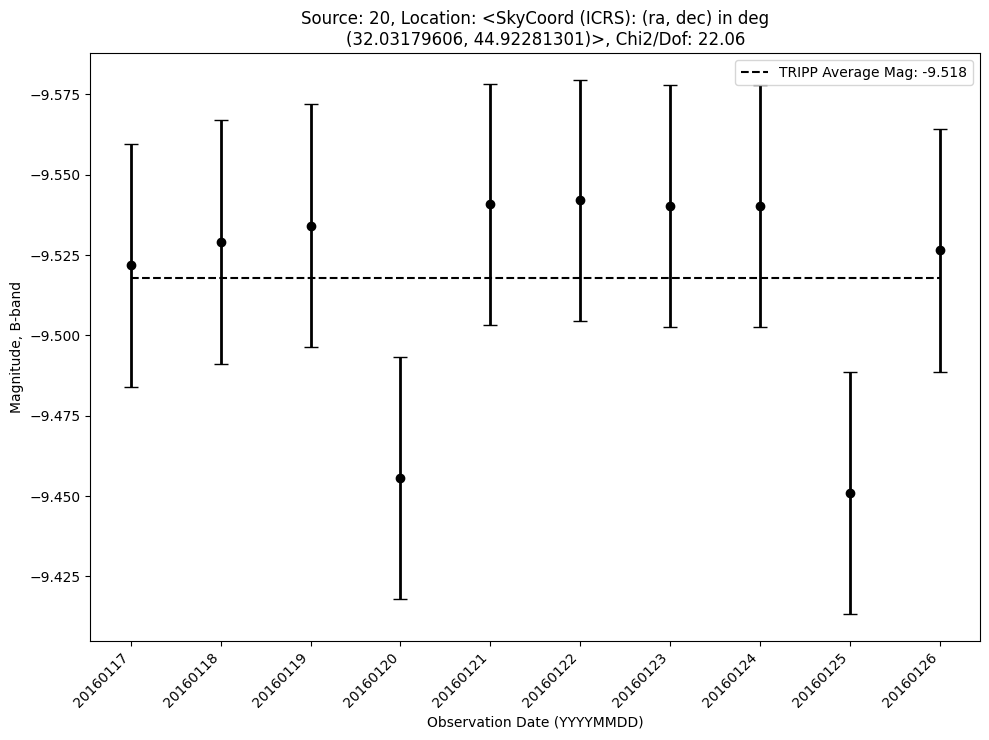

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.02597866, 44.92534498)>, Night_0_xy: (array(1311.51894455), array(578.4706527)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-6.695964311618087, cal_mag_avg: -6.695964311618087, flagged: False, ID: 21, Chi2: None
None
[0.2465544545063964, 0.2514864776000163, 0.2474415964867338, 0.23302596240412632, 0.23289691522138106, 0.23100312797132405, 0.22816138722782067, 0.2293461920261853, 0.2402529476718714, 0.2444596881068093]


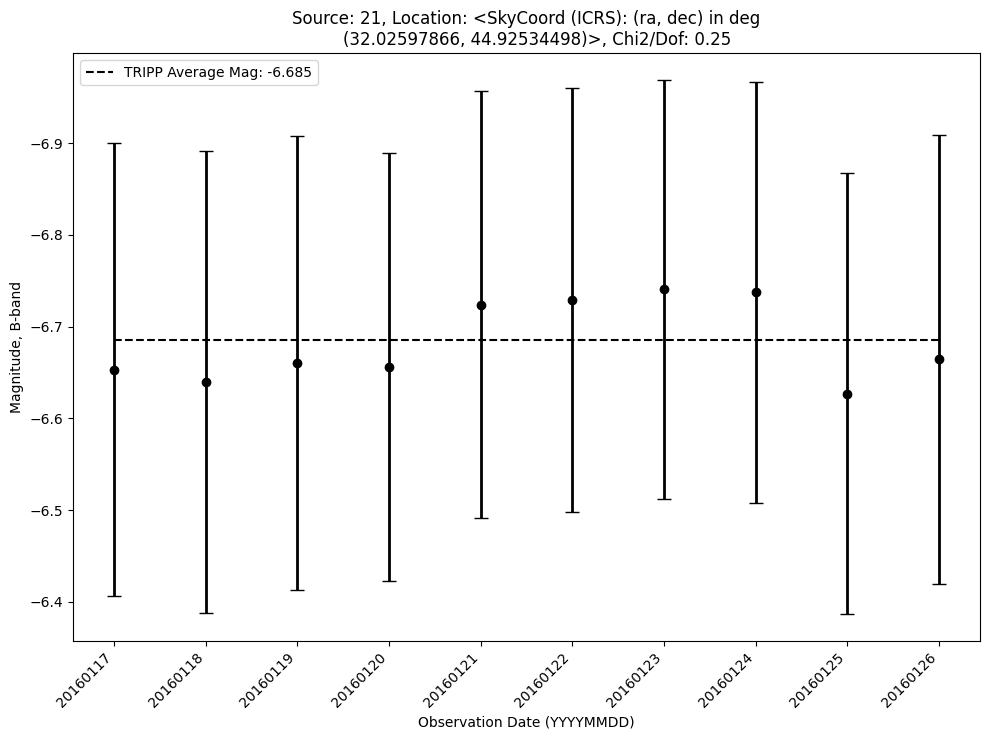

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.28002574, 44.9268794)>, Night_0_xy: (array(175.51488997), array(590.52739319)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.846178207557806, cal_mag_avg: -8.846178207557806, flagged: False, ID: 22, Chi2: None
None
[0.05861837672423924, 0.05889691623487718, 0.058746542817944836, 0.0588105182954769, 0.059219249218503425, 0.05888004548503088, 0.05898403941286763, 0.05873267688230615, 0.05884841154610665, 0.05886312281202451]


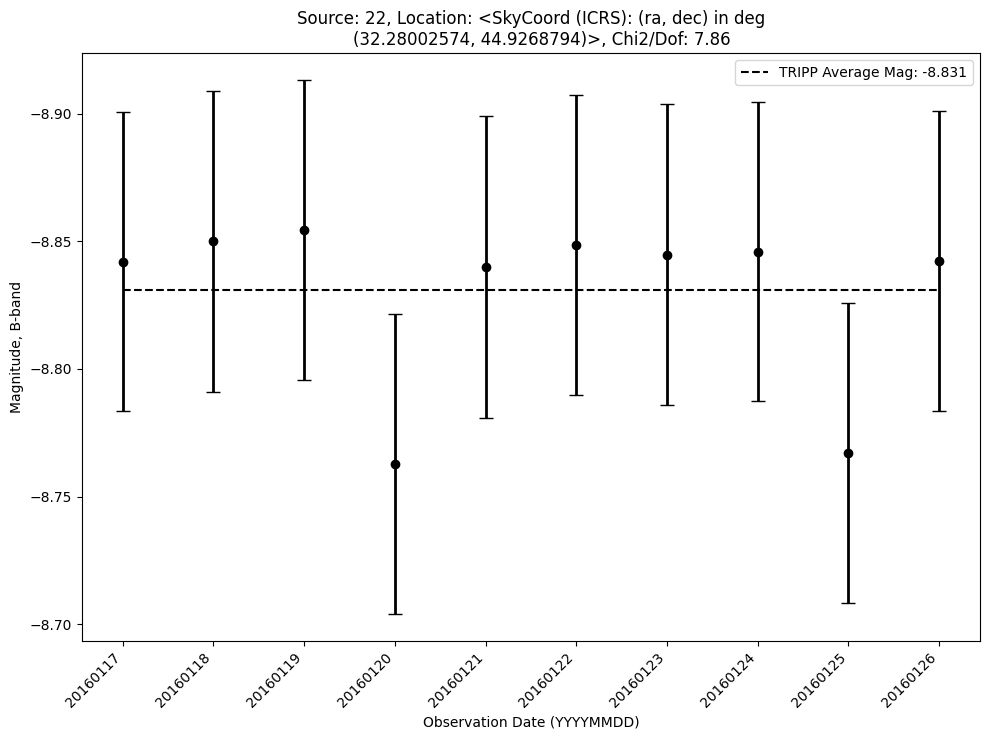

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.07898212, 44.92958798)>, Night_0_xy: (array(1074.53170221), array(605.46847574)) rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.628493116079052, cal_mag_avg: -7.628493116079052, flagged: False, ID: 23, Chi2: None
None
[0.1313200061611948, 0.1320382984761337, 0.1314525431658474, 0.13097426991398817, 0.13064053491259076, 0.130737586221766, 0.13026567953291932, 0.1303884011954167, 0.13039687913487158, 0.13089609954306583]


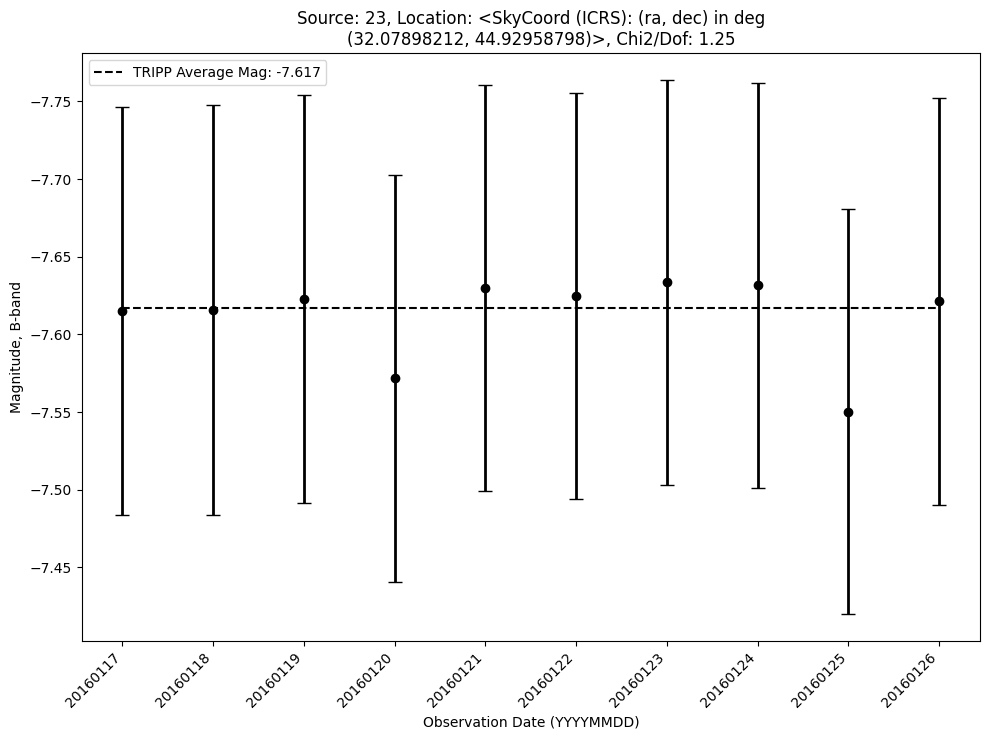

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.19103034, 44.92865293)>, Night_0_xy: (array(573.50049511), array(600.4951103)) rad: 18.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.854398443120699, cal_mag_avg: -11.854398443120699, flagged: False, ID: 24, Chi2: None
None
[0.014136350114085133, 0.014139869376481172, 0.014137334310468555, 0.014124647113237392, 0.014108678028089313, 0.014119621005749254, 0.014126837992964332, 0.01412975358511197, 0.014107666522337532, 0.01415472982765751]


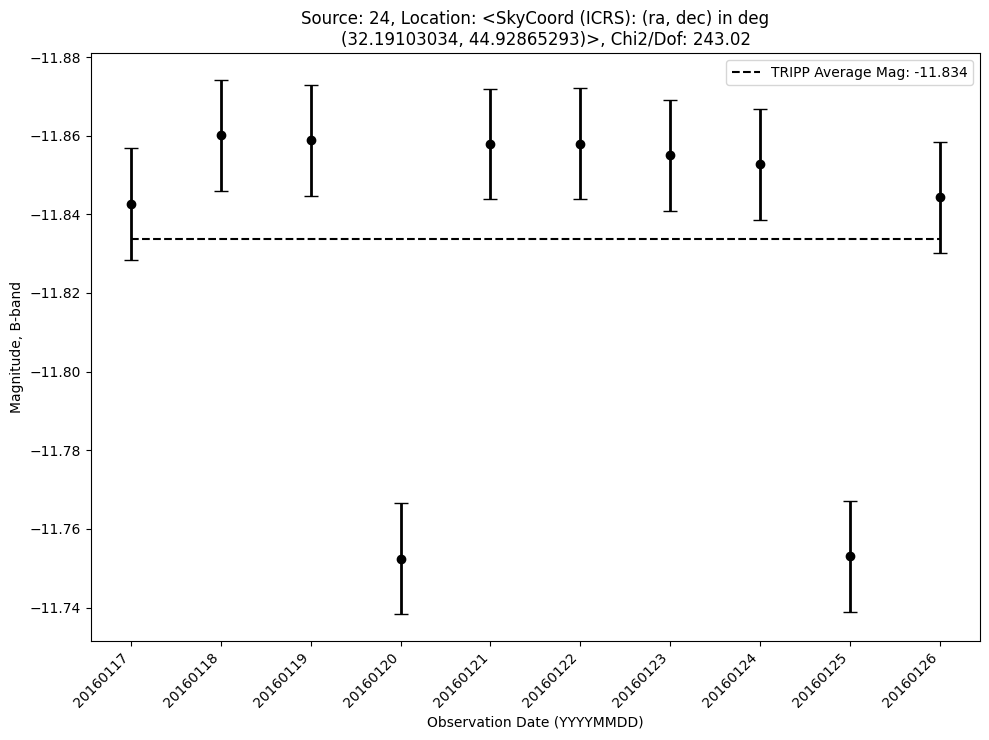

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.99982784, 44.93548869)>, Night_0_xy: (array(1428.47151006), array(642.49469758)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.210834131975387, cal_mag_avg: -11.210834131975387, flagged: False, ID: 25, Chi2: None
None
[0.06166601745679011, 0.06154526176672206, 0.061292443431686355, 0.03119402644825741, 0.002162766939195221, 0.0021626730055745187, 0.0021624644931912767, 0.002163017247635828, 0.03138420669845613, 0.061053651520973515]


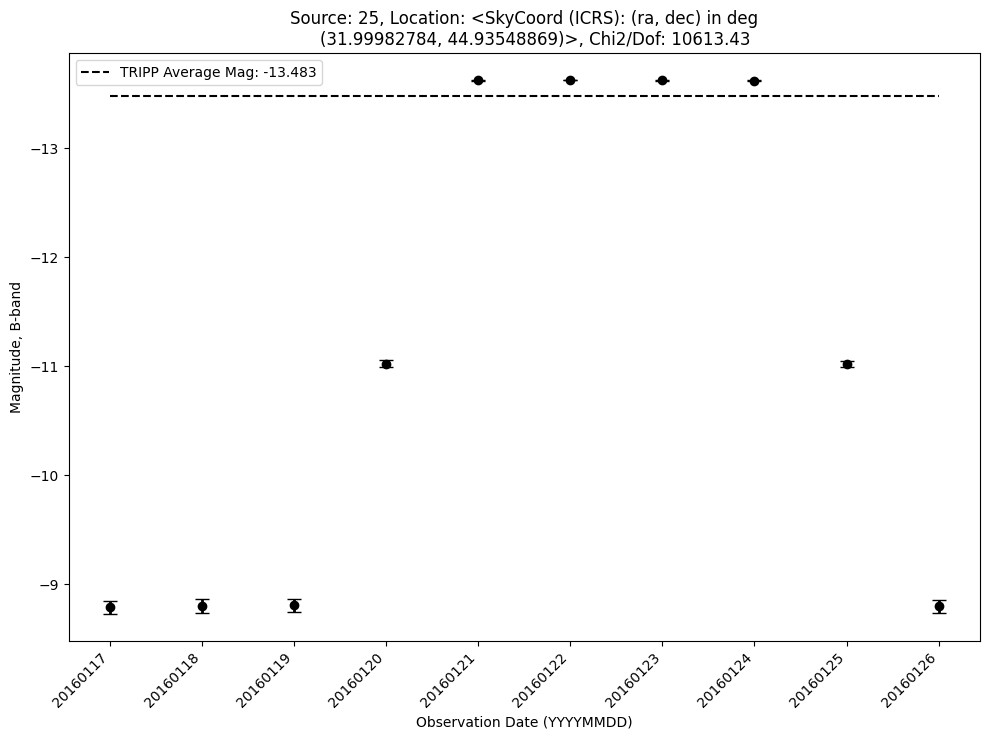

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.11948413, 44.93620208)>, Night_0_xy: (array(893.49962659), array(647.49892626)) rad: 14.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.477594635927202, cal_mag_avg: -11.477594635927202, flagged: False, ID: 26, Chi2: None
None
[0.014672787833718047, 0.014669229465316857, 0.01466995025524602, 0.01467250163214507, 0.014661006866793076, 0.014667534056168875, 0.014642109866699072, 0.014637730444123823, 0.014658737708568386, 0.014640579919510264]


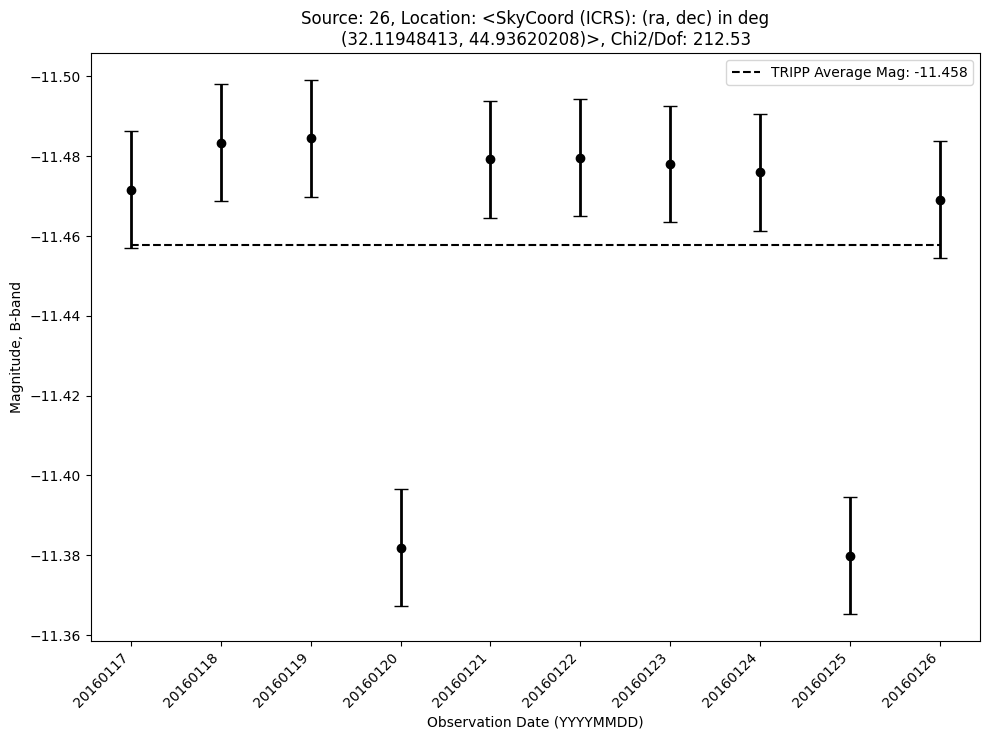

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.01950566, 44.93611641)>, Night_0_xy: (array(1340.49439117), array(646.48704625)) rad: 19.5, ref_status: None, ref_mag: None, inst_mag_avg:-13.821492903629535, cal_mag_avg: -13.821492903629535, flagged: False, ID: 27, Chi2: None
None
[0.011681929852438256, 0.01168899319052048, 0.011678808080166227, 0.006340503704921902, 0.0010094666870430068, 0.0010094968418972103, 0.0010095645765479397, 0.001009491376146711, 0.006342628179661349, 0.01167191272486919]


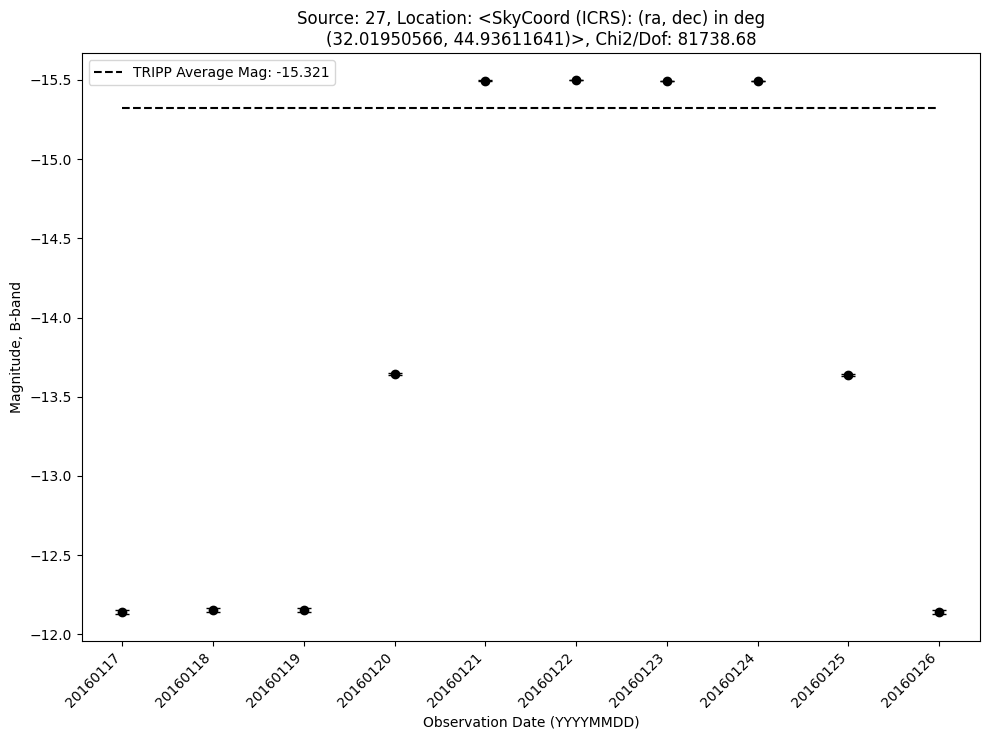

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.22931809, 44.93966719)>, Night_0_xy: (array(402.50675002), array(670.53615505)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.382520748374365, cal_mag_avg: -10.382520748374365, flagged: False, ID: 28, Chi2: None
None
[0.11830902516369166, 0.11790276571803542, 0.11635314631915825, 0.05978700270346188, 0.0030529551580666062, 0.0030528882265798384, 0.0030530319948302072, 0.0030531538946201578, 0.05917267842782115, 0.11746529796144967]


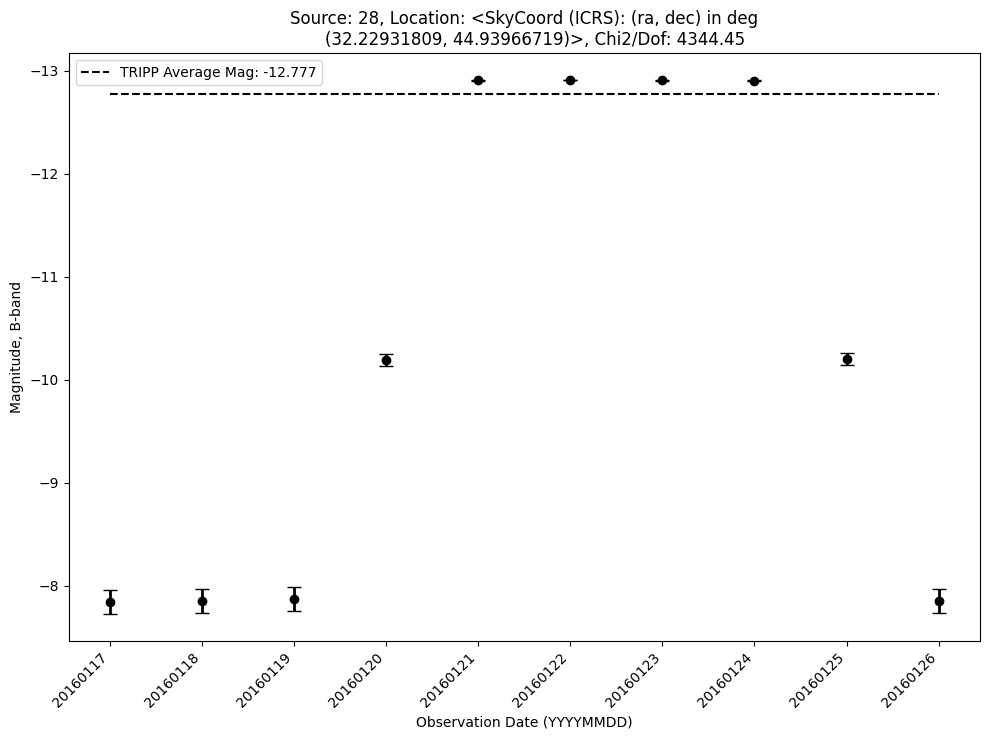

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.95486122, 44.9413464)>, Night_0_xy: (array(1629.50237094), array(679.50744728)) rad: 14.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.30442688902124, cal_mag_avg: -11.30442688902124, flagged: False, ID: 29, Chi2: None
None
[0.01637296657066671, 0.016380578039810564, 0.01637167122472781, 0.016347951458014147, 0.016328228384627122, 0.01630904655074676, 0.01632109169902382, 0.016309065569896898, 0.016328718169117143, 0.016355236842378326]


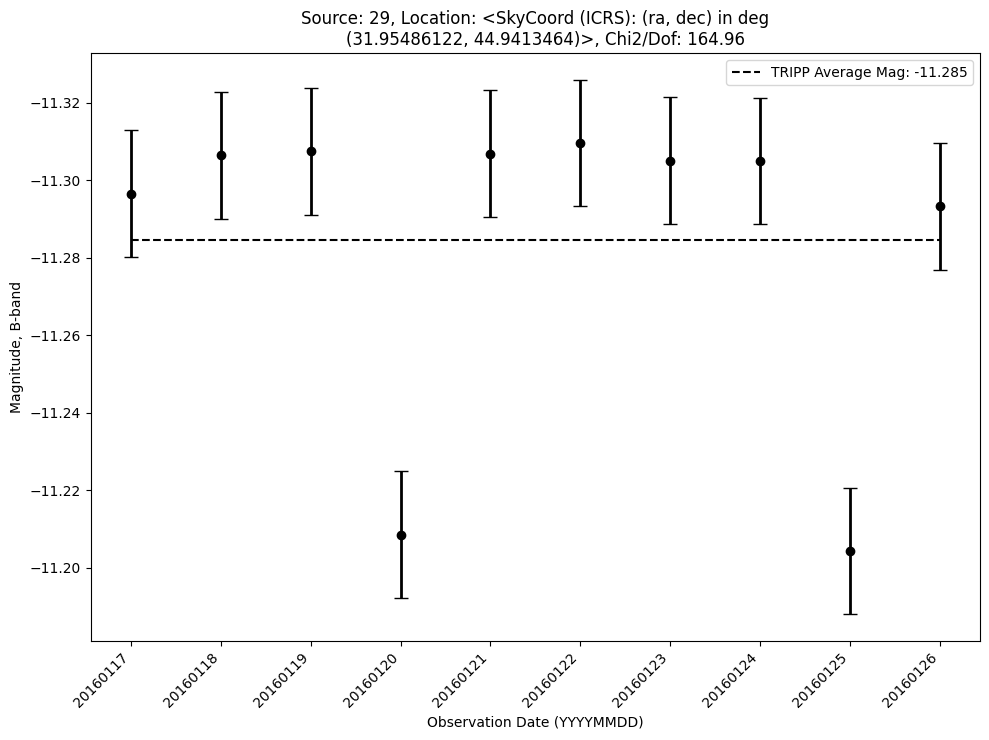

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.86359386, 44.94286612)>, Night_0_xy: (array(2037.49983592), array(689.48207285)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.04751423812335, cal_mag_avg: -8.04751423812335, flagged: False, ID: 30, Chi2: None
None
[0.10104969697101059, 0.09994644130821227, 0.1001439738858825, 0.09947260989316993, 0.09968085948957348, 0.09875856499278308, 0.09889566460423177, 0.09897419288693948, 0.10004833720720371, 0.10038784721869598]


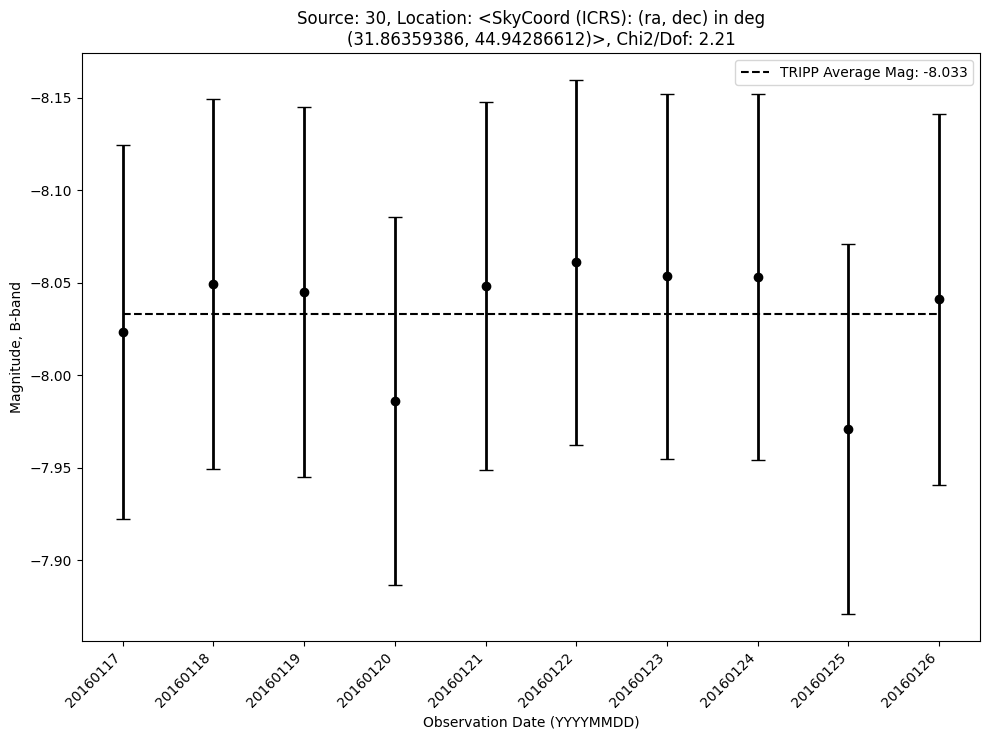

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.10899508, 44.94698474)>, Night_0_xy: (array(940.5002899), array(715.52472419)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.728398787979069, cal_mag_avg: -8.728398787979069, flagged: False, ID: 31, Chi2: None
None
[0.06531953930468458, 0.06520655940475034, 0.06549582512983482, 0.06511578884443761, 0.06521358338865474, 0.06504409927141762, 0.06556977283633199, 0.06535569235243016, 0.06517404832112071, 0.06536838648568113]


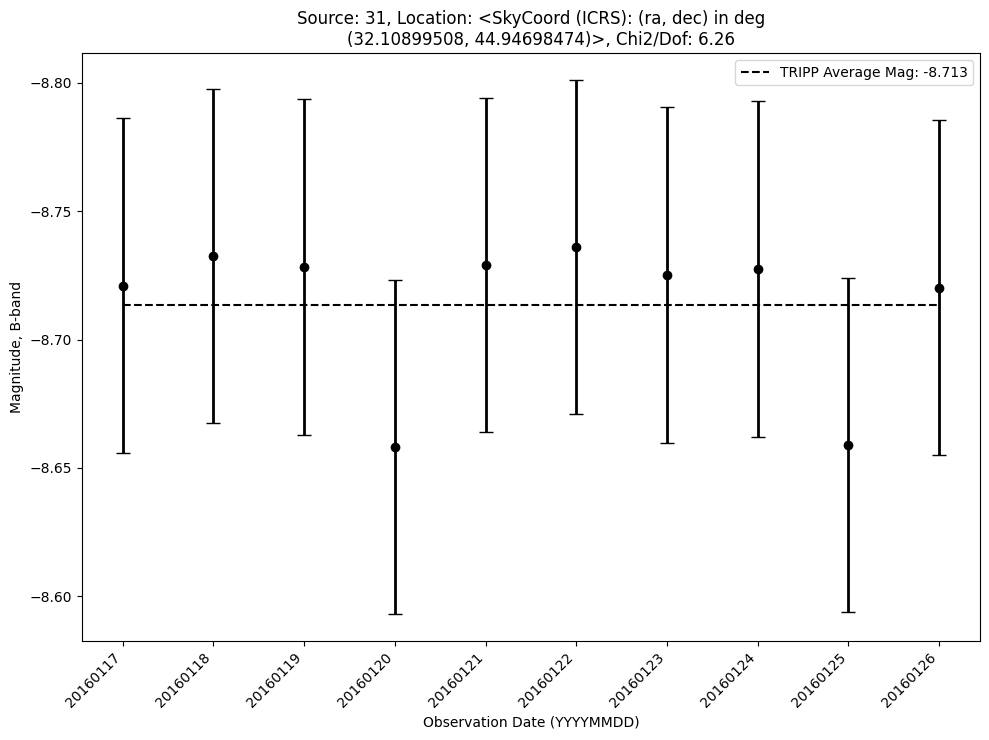

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.13363087, 44.9534469)>, Night_0_xy: (array(830.45176082), array(756.52478377)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.242051181526984, cal_mag_avg: -7.242051181526984, flagged: False, ID: 32, Chi2: None
None
[0.16557140549102722, 0.16733468744848767, 0.16612317785877967, 0.16538045225255904, 0.16636140190791585, 0.16343995771309008, 0.16554182707564774, 0.16539676270244447, 0.16623307171165624, 0.16328784919507555]


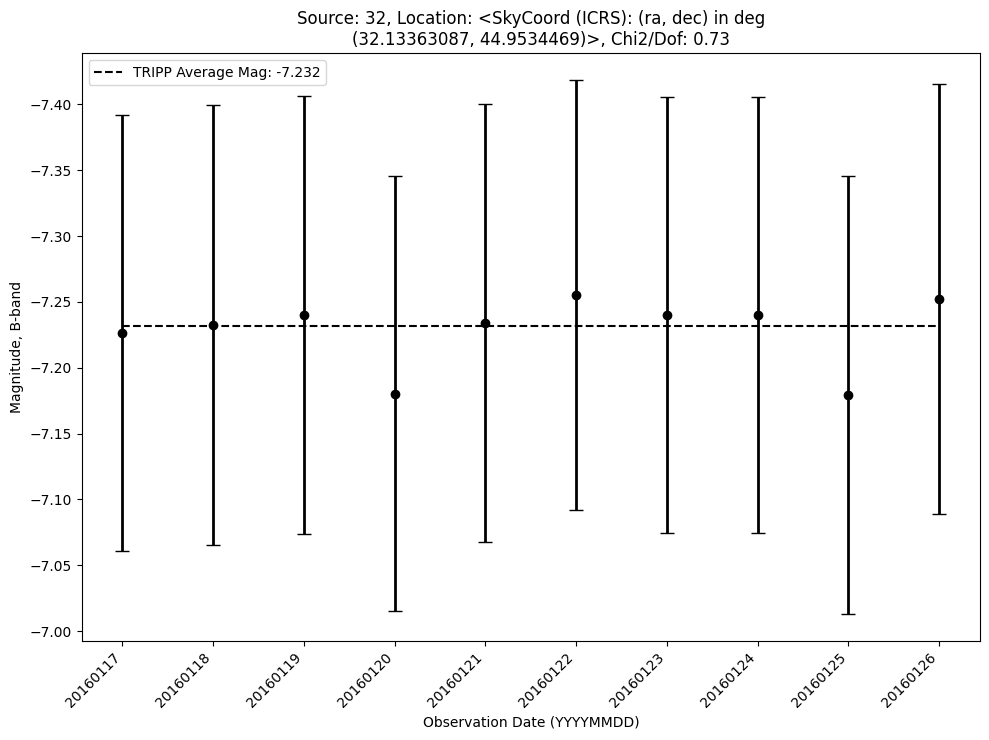

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.05015749, 44.95352419)>, Night_0_xy: (array(1203.54229075), array(756.51675383)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.802075074849323, cal_mag_avg: -7.802075074849323, flagged: False, ID: 33, Chi2: None
None
[0.12451950519590085, 0.12433845910114588, 0.12440078858783318, 0.12331148043644757, 0.12346881149763292, 0.12356209972478847, 0.12381993505330802, 0.12313439395791045, 0.12404408113896512, 0.12386804060889546]


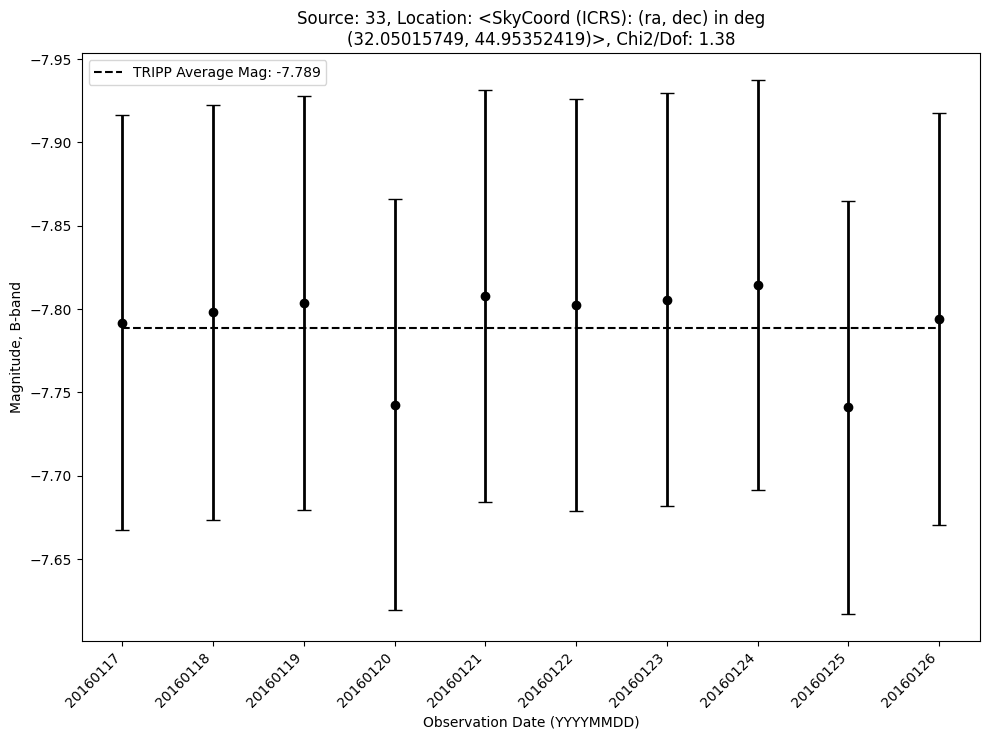

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.94456565, 44.95749363)>, Night_0_xy: (array(1675.47914303), array(781.50948412)) rad: 9.0, ref_status: None, ref_mag: None, inst_mag_avg:-12.065831859857607, cal_mag_avg: -12.065831859857607, flagged: False, ID: 35, Chi2: None
None
[0.03696821370556119, 0.03684726649381784, 0.0369462773360862, 0.019181121417923466, 0.001561808002748207, 0.0015615088782343317, 0.0015614235879439415, 0.0015613542147657608, 0.019188547412688897, 0.03681840565109784]


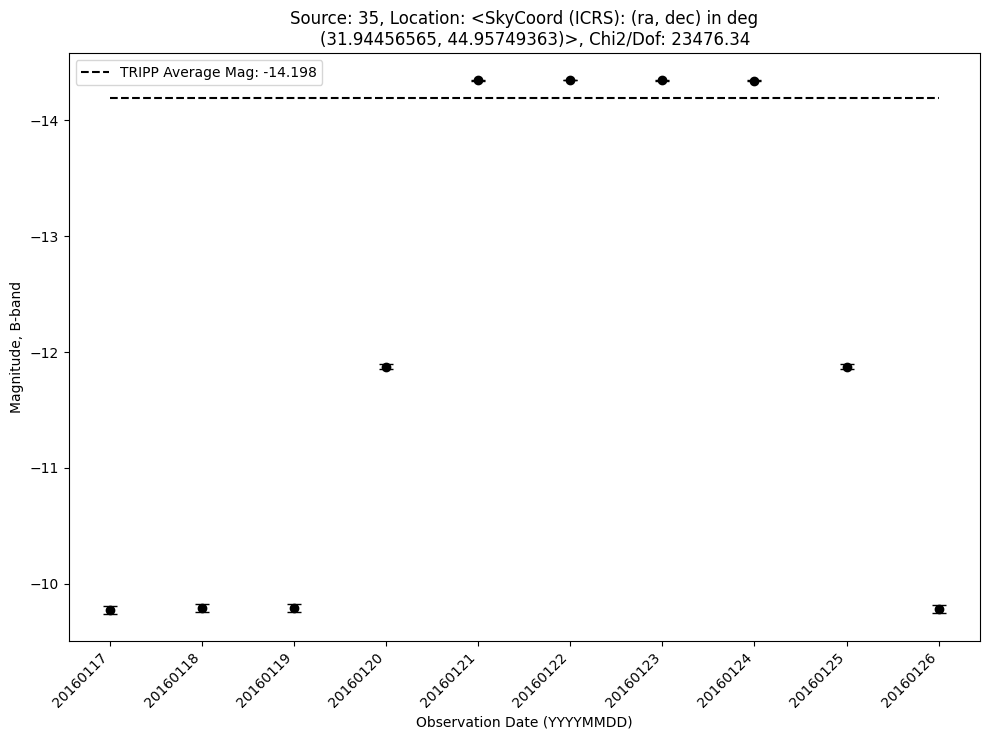

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.78547446, 44.95780168)>, Night_0_xy: (array(2386.4936015), array(784.49875826)) rad: 11.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.399868690695905, cal_mag_avg: -10.399868690695905, flagged: False, ID: 36, Chi2: None
None
[0.02853182283821991, 0.0285420782524037, 0.028502660973630696, 0.02854376467814848, 0.02854155282694548, 0.028477224922749178, 0.028514786920624476, 0.02848410152733049, 0.028507861937561912, 0.028452075988472117]


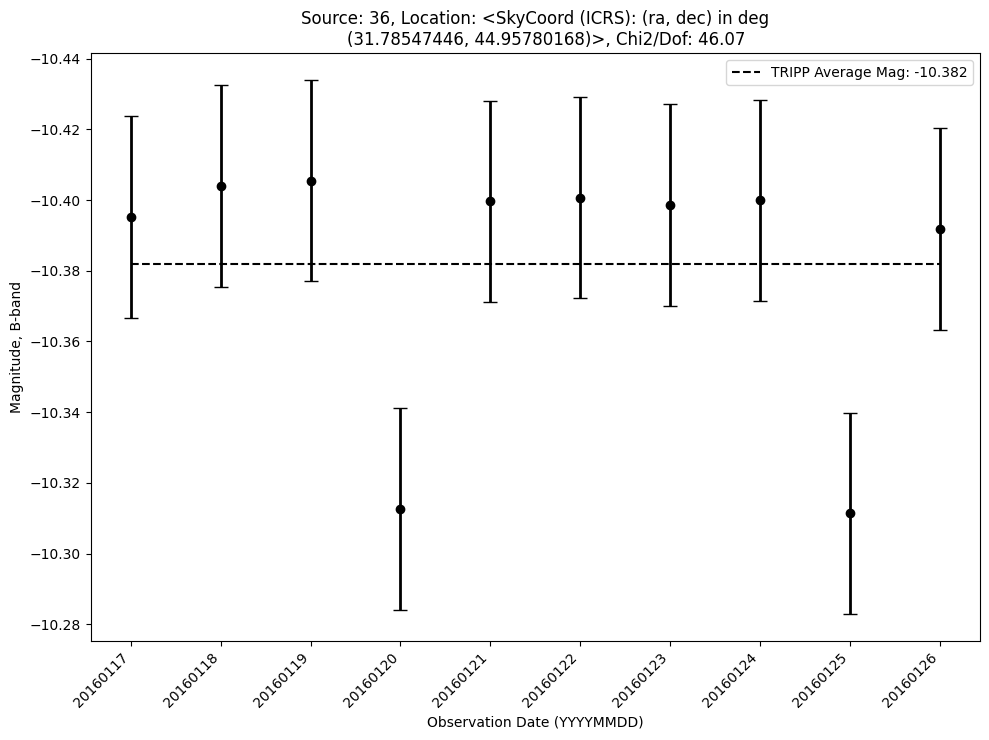

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.86400412, 44.96012682)>, Night_0_xy: (array(2035.50434023), array(798.49430806)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.387450245646829, cal_mag_avg: -11.387450245646829, flagged: False, ID: 37, Chi2: None
None
[0.1355856707398299, 0.13500654771569662, 0.13466060259064772, 0.06666270079857484, 0.0009492034029904431, 0.0009491305301344261, 0.0009491716278134099, 0.0009492033998380126, 0.06612817130544107, 0.1362897428556023]


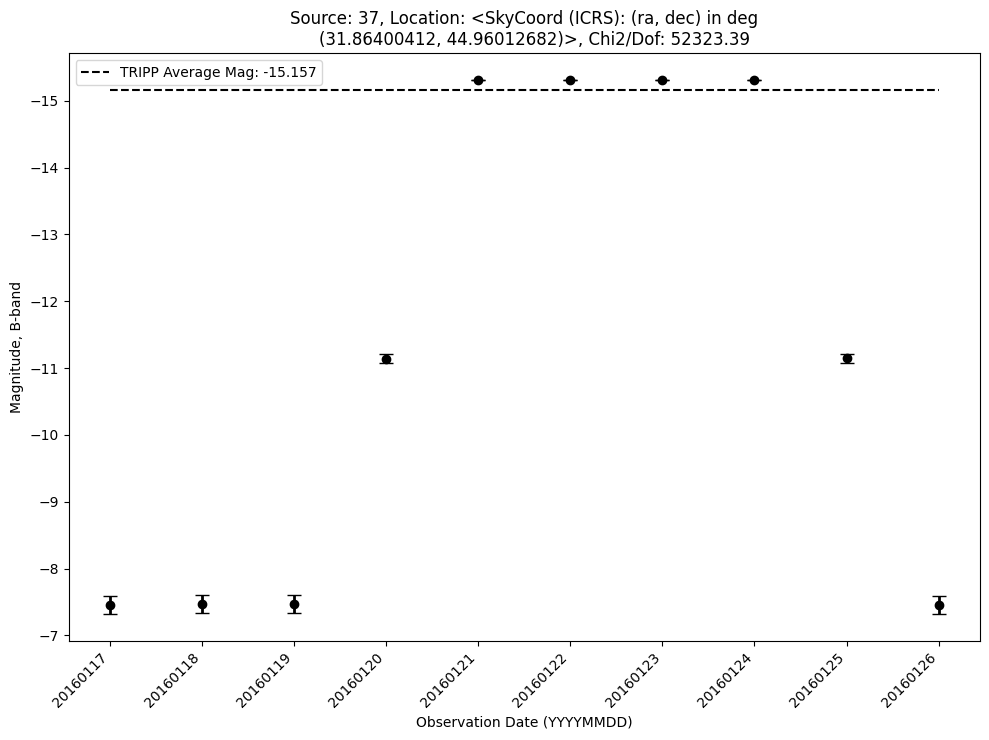

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.92442112, 44.95906789)>, Night_0_xy: (array(1765.50279222), array(791.50719576)) rad: 14.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.03376025249349, cal_mag_avg: -11.03376025249349, flagged: False, ID: 38, Chi2: None
None
[0.020670247169341162, 0.0206362709132297, 0.020648155271982813, 0.02061628913185587, 0.020651382242474703, 0.020639941378551074, 0.020661660637916888, 0.020636933513947832, 0.020632355974976806, 0.0206553374996851]


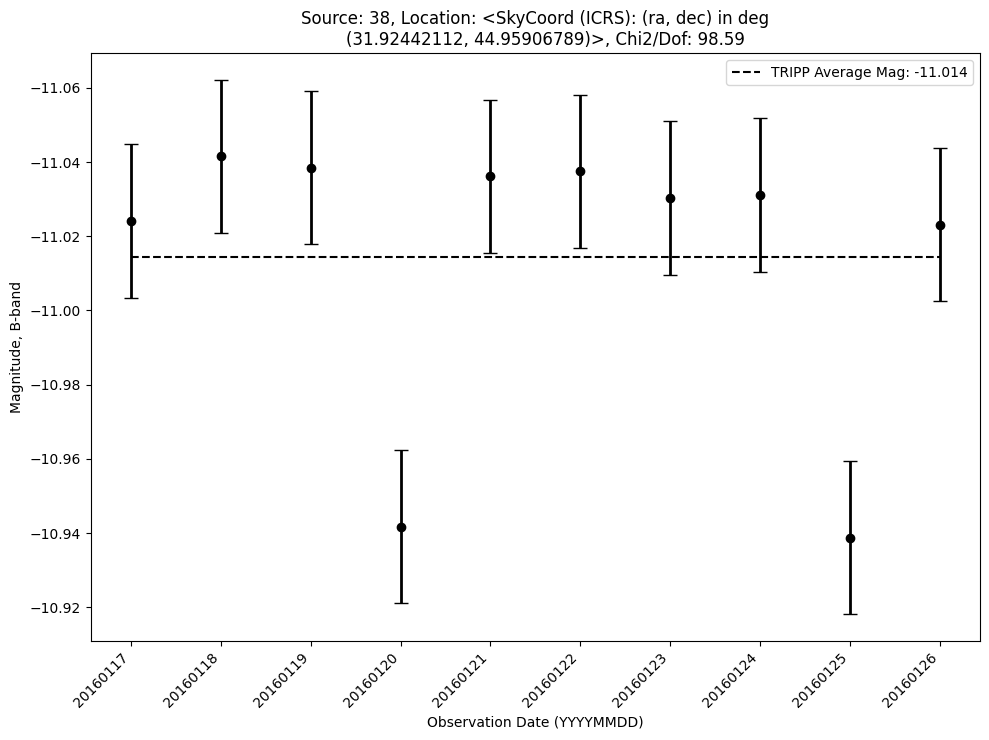

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.725272, 44.96037694)>, Night_0_xy: (array(2655.50114096), array(801.52239714)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.318086383812041, cal_mag_avg: -6.318086383812041, flagged: False, ID: 39, Chi2: None
None
[0.29144153877316253, 0.29821006835012, 0.28462137327745385, 0.28548290937318055, 0.2889505843521056, 0.29399885040571055, 0.28648493908566897, 0.29707679673340137, 0.2848276852087156, 0.28844539250062096]


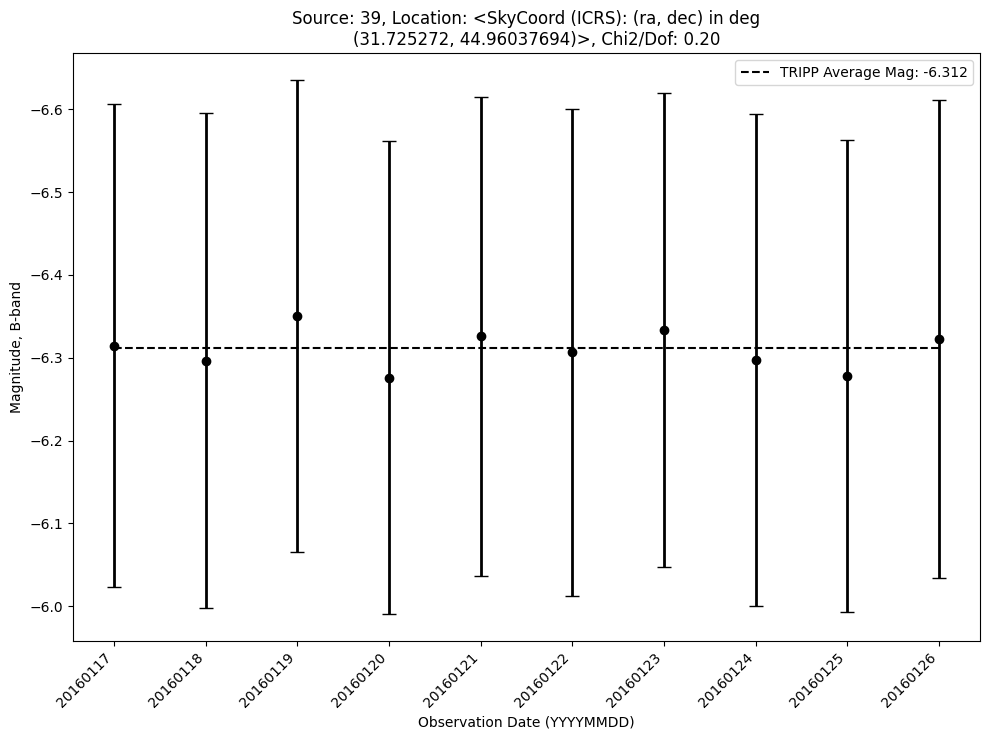

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.17639537, 44.96275824)>, Night_0_xy: (array(639.45216722), array(815.73616298)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.425699617014407, cal_mag_avg: -5.425699617014407, flagged: False, ID: 40, Chi2: None
None
[0.4503378757186523, 0.46118607309932363, 0.46407809096849556, 0.4644888695615827, 0.4657541622115158, 0.47465093329092384, 0.431956971018626, 0.45613379406313553, 0.4742966893313277, 0.4645608895074235]


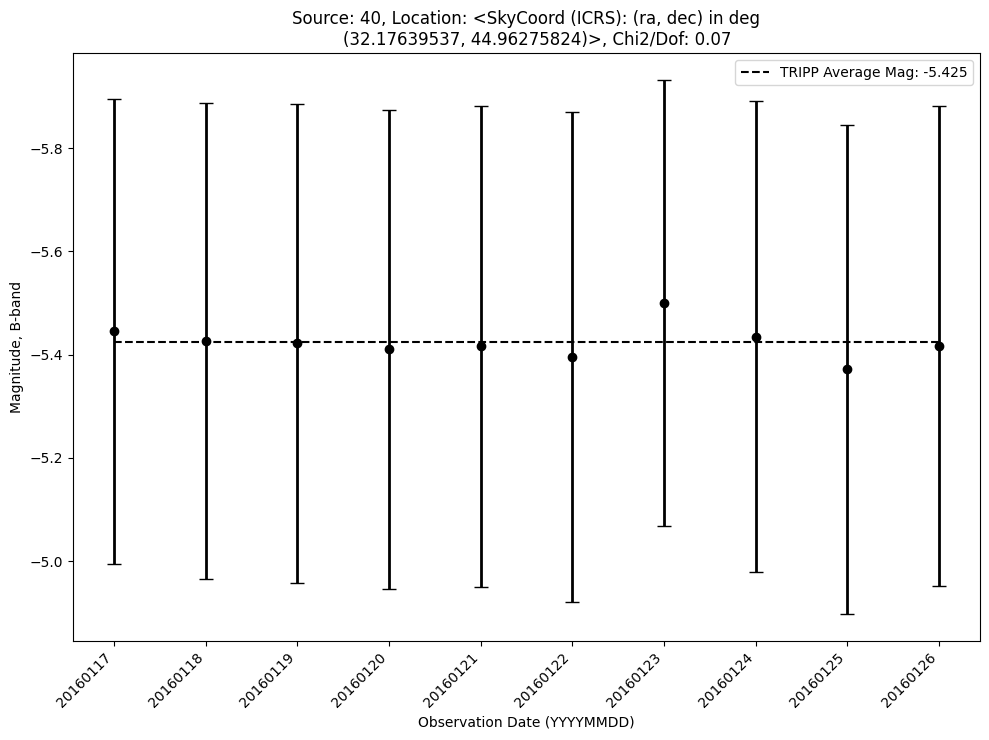

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.70465106, 44.97647284)>, Night_0_xy: (array(2747.30670143), array(903.48655187)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.135080213349125, cal_mag_avg: -6.135080213349125, flagged: False, ID: 41, Chi2: None
None
[0.3363612377403551, 0.335816374601961, 0.35122110928691036, 0.3459553392123911, 0.34201994950315, 0.34083614624618097, 0.34222099732214095, 0.3484337708121745, 0.33964532840120487, 0.33534388282600963]


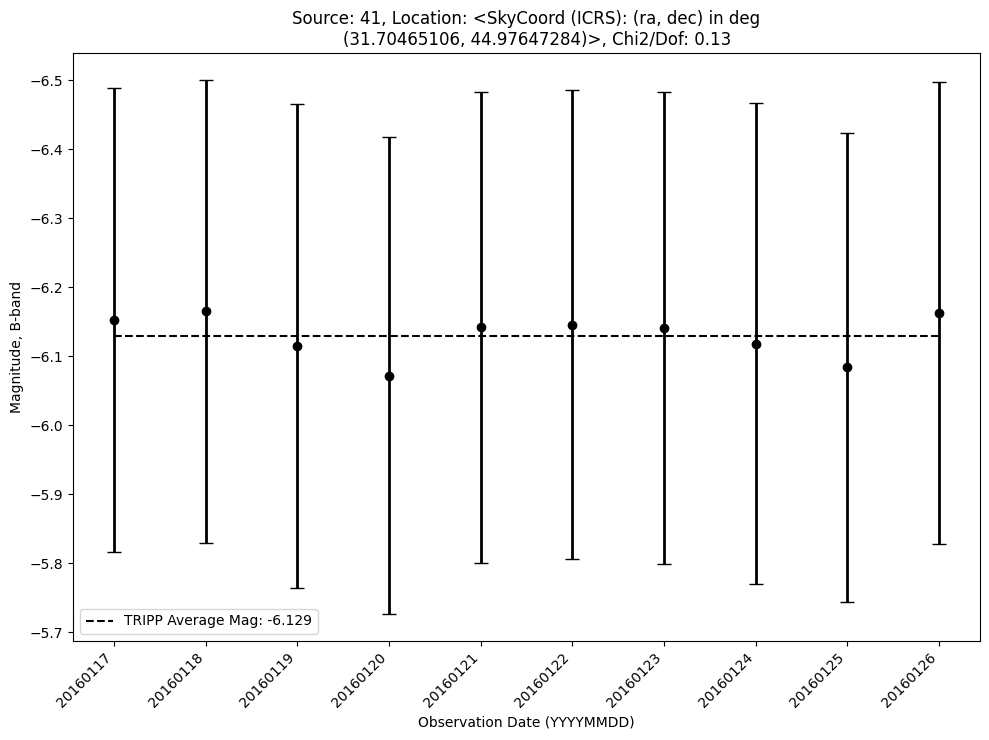

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.25231228, 44.97776793)>, Night_0_xy: (array(300.50408773), array(911.49785477)) rad: 20.0, ref_status: None, ref_mag: None, inst_mag_avg:-12.192536229210374, cal_mag_avg: -12.192536229210374, flagged: False, ID: 42, Chi2: None
None
[0.01158257170227656, 0.011578252552278005, 0.011571515111783306, 0.011584611275066211, 0.011579050457952385, 0.011584083432321136, 0.011592628514057866, 0.011570660528926304, 0.011582715476767137, 0.011572422590274335]


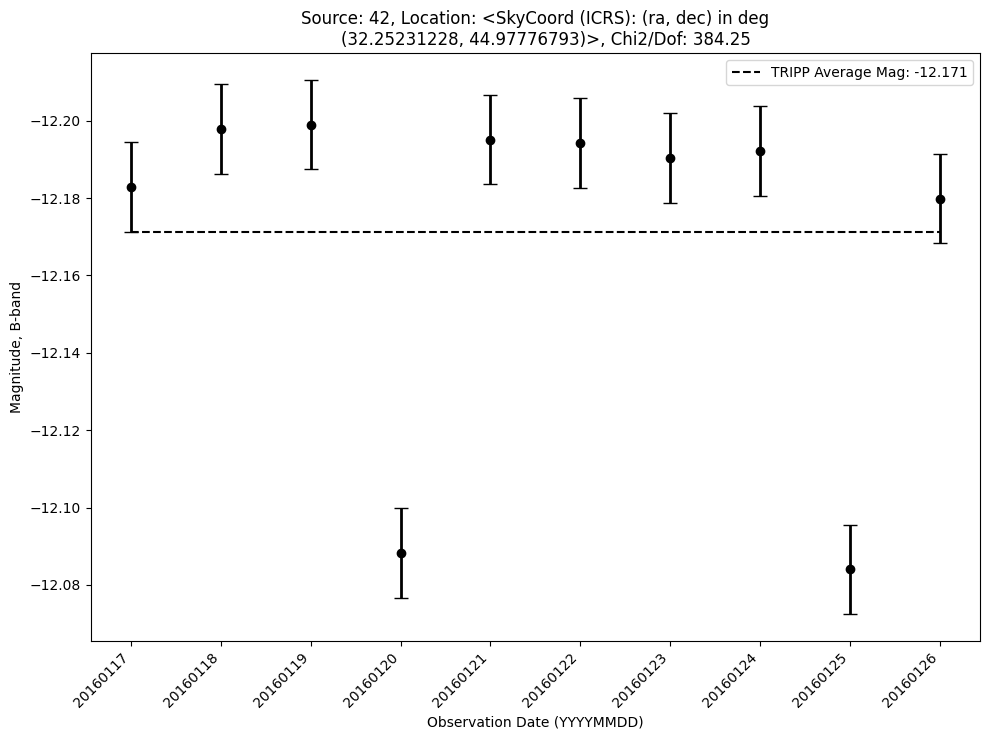

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.84468349, 44.98651425)>, Night_0_xy: (array(2121.56259968), array(965.2899359)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-5.749459326968745, cal_mag_avg: -5.749459326968745, flagged: False, ID: 43, Chi2: None
None
[0.4177137697365847, 0.406363821398796, 0.4185077574736509, 0.39831029662562173, 0.42230720658784304, 0.41229985472816155, 0.407182946690811, 0.4173627699724246, 0.40967647653570094, 0.41759755119163927]


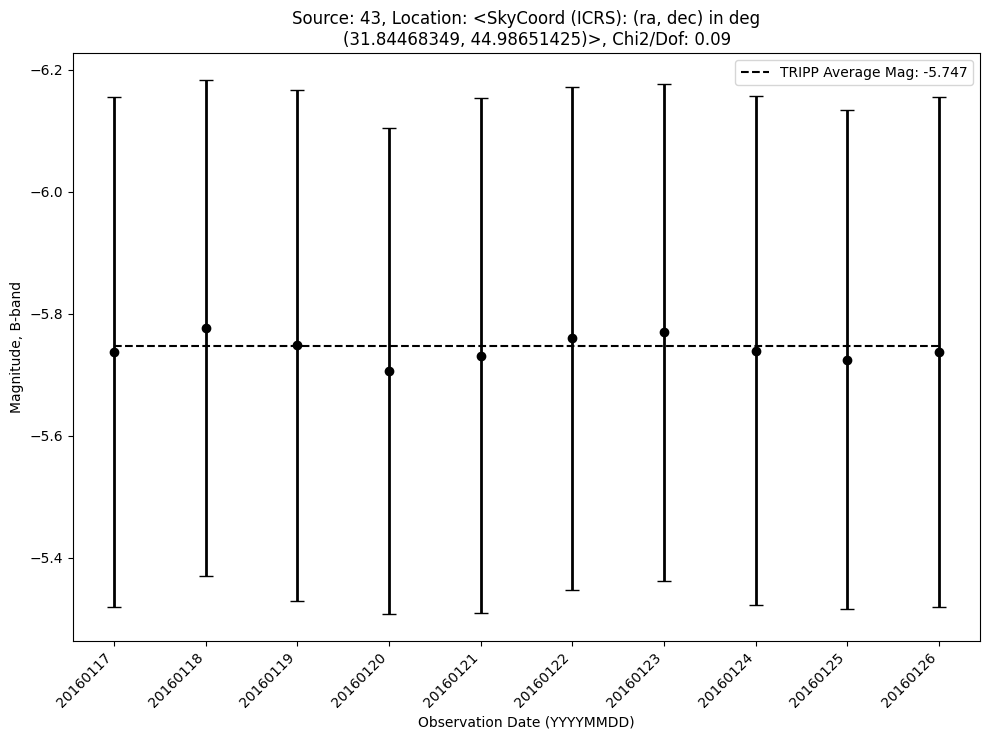

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.21318363, 44.98877888)>, Night_0_xy: (array(475.51541561), array(980.50441826)) rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.382231530196217, cal_mag_avg: -9.382231530196217, flagged: False, ID: 44, Chi2: None
None
[0.04296447049270319, 0.042873523522406864, 0.04299014578543338, 0.04292300550120552, 0.04297869148849917, 0.04287948120762869, 0.04287475718592823, 0.04301096506068046, 0.043132546248466165, 0.04280385091482721]


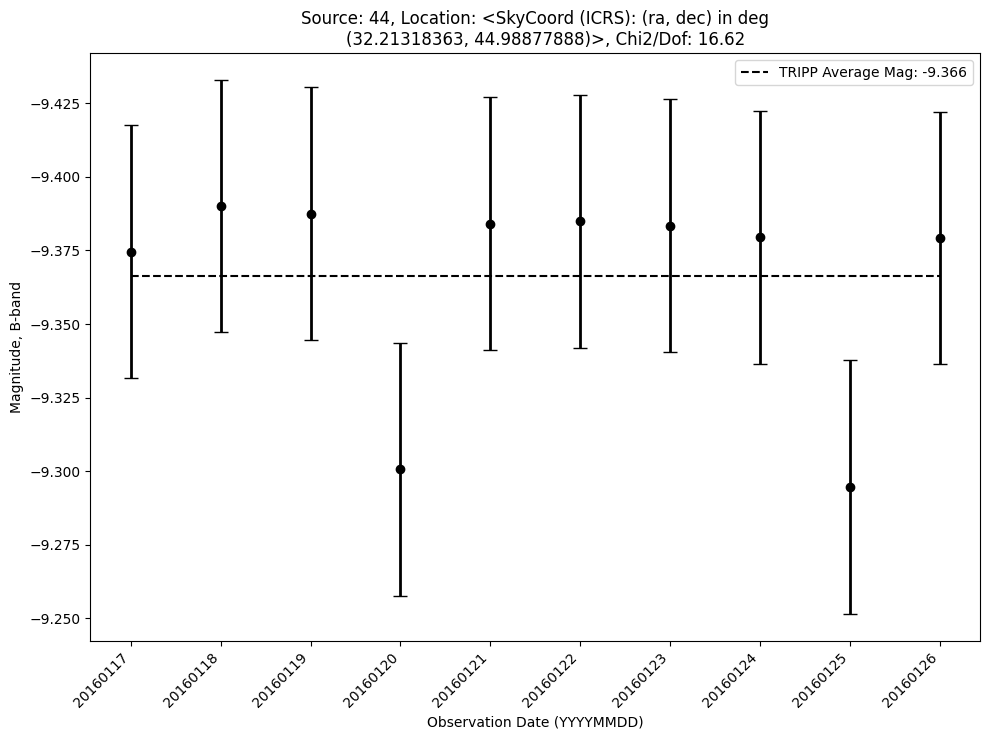

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.95462682, 44.99231027)>, Night_0_xy: (array(1630.43338798), array(1001.38496404)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.052840955667596, cal_mag_avg: -7.052840955667596, flagged: False, ID: 45, Chi2: None
None
[0.19524950529207397, 0.19651131050463397, 0.1959144551371863, 0.19423437919621434, 0.19467390774713286, 0.1974269071315749, 0.19376481870171128, 0.1957864295104621, 0.19456727165878968, 0.19445734137035814]


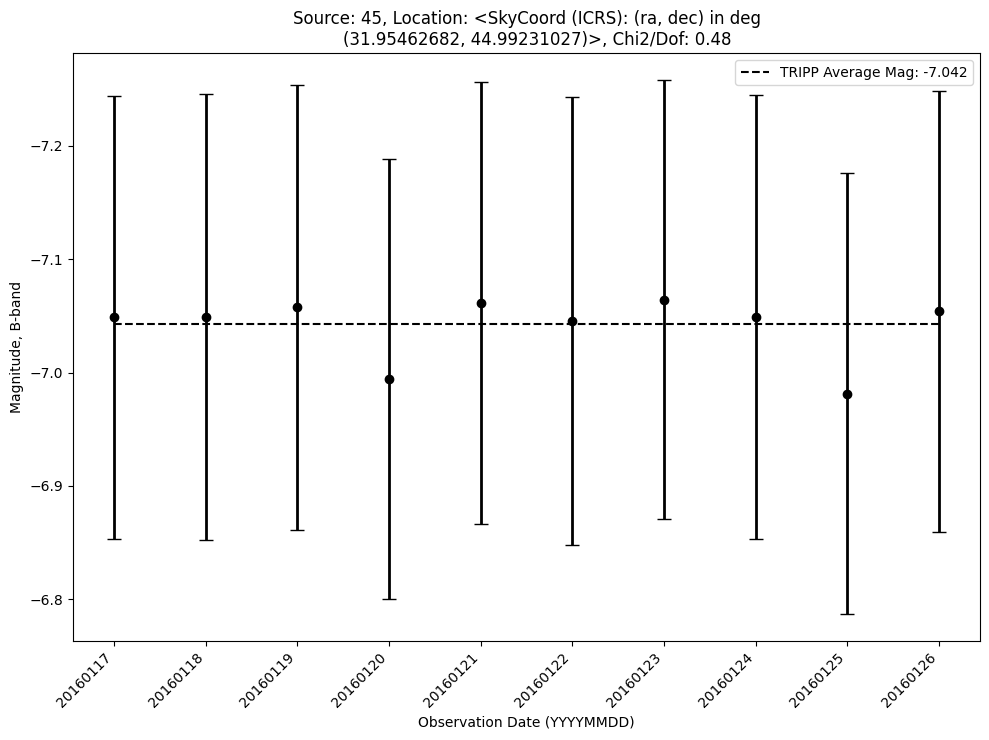

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.20356953, 44.99116945)>, Night_0_xy: (array(518.50088432), array(995.48384206)) rad: 17.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.563628877233745, cal_mag_avg: -11.563628877233745, flagged: False, ID: 46, Chi2: None
None
[0.01698511387035745, 0.017020920220199968, 0.017004229205526713, 0.017027158615739457, 0.01699883626521545, 0.017006300684884682, 0.0170277492655841, 0.017003444764728447, 0.01701854571348555, 0.01702831963915808]


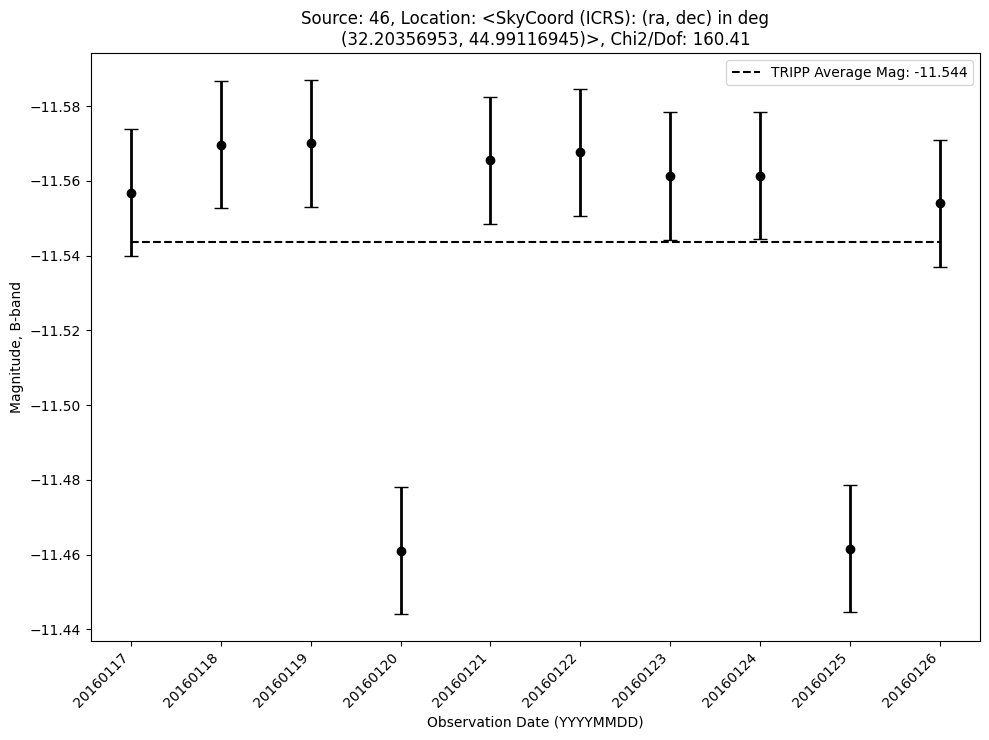

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.85362731, 44.99764289)>, Night_0_xy: (array(2081.49748344), array(1035.50957075)) rad: 19.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.973707329266782, cal_mag_avg: -11.973707329266782, flagged: False, ID: 47, Chi2: None
None
[0.01315898788640631, 0.013163921053066931, 0.013174018959456418, 0.013157096963149227, 0.01315497473023222, 0.013144673613950289, 0.013153917266452403, 0.013138124413374783, 0.013141590169215577, 0.01315387494644084]


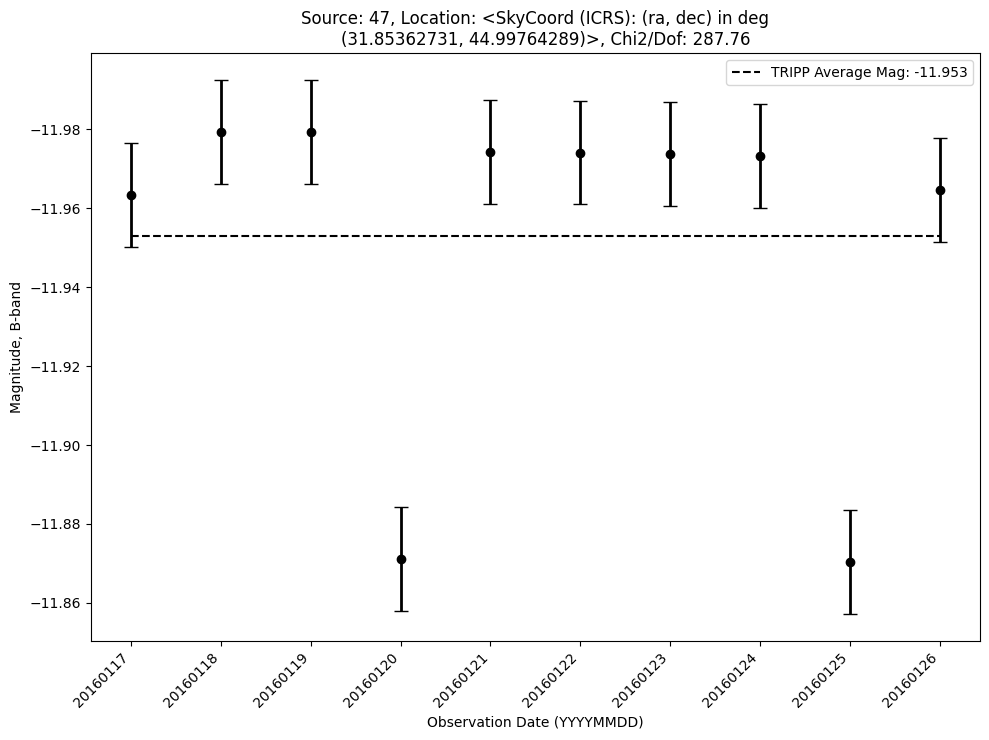

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.27010338, 44.99973172)>, Night_0_xy: (array(221.50847687), array(1050.48832566)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.298643901327672, cal_mag_avg: -11.298643901327672, flagged: False, ID: 48, Chi2: None
None
[0.05642046000125623, 0.05633015867815626, 0.05602249642438166, 0.028839625787527114, 0.0020802428460018887, 0.002080484819222813, 0.0020803332979811985, 0.0020805362722974507, 0.02902413068184191, 0.056217008108583696]


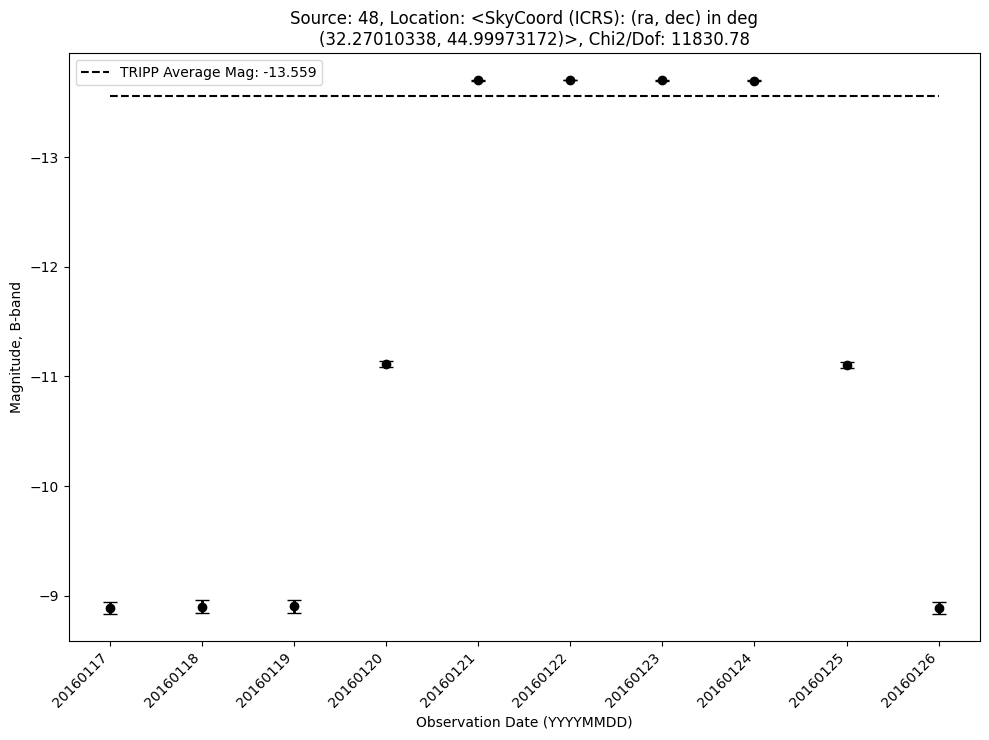

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.87557027, 44.99972466)>, Night_0_xy: (array(1983.47986312), array(1048.51310189)) rad: 11.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.290554419102294, cal_mag_avg: -10.290554419102294, flagged: False, ID: 49, Chi2: None
None
[0.031365076210118276, 0.03151795402023192, 0.031432671964727134, 0.03139255695803649, 0.03140954607791657, 0.03139514479813786, 0.03135550546541069, 0.031394878741243915, 0.031381645414695736, 0.03145708028799645]


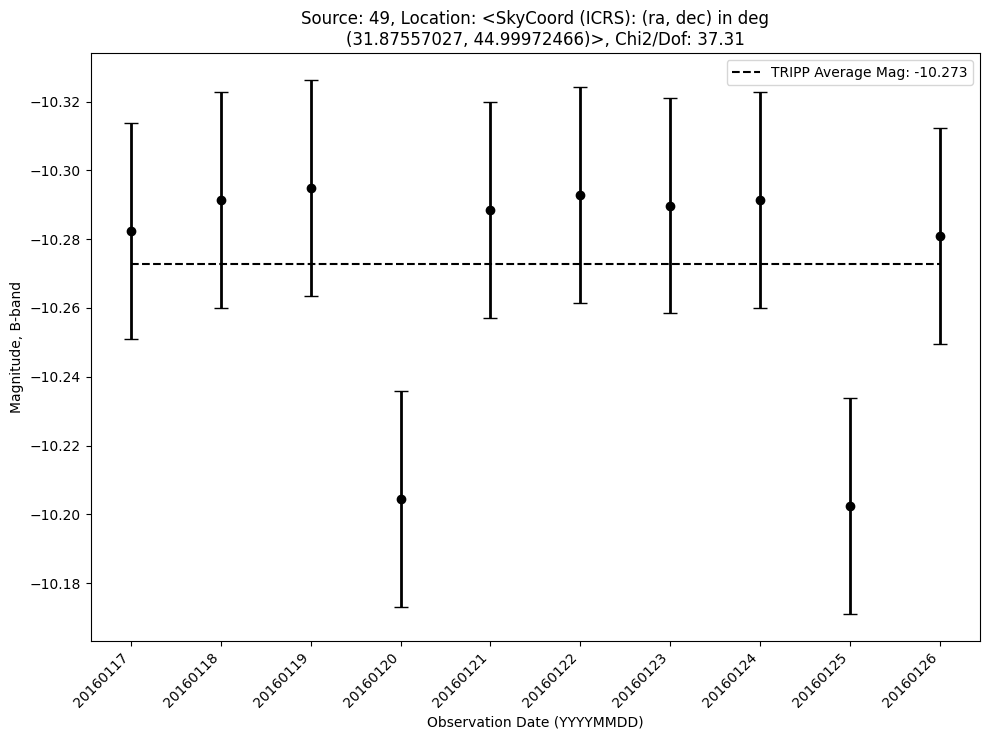

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.00342865, 45.01037929)>, Night_0_xy: (array(1412.48549097), array(1115.49156993)) rad: 10.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.862197740389858, cal_mag_avg: -9.862197740389858, flagged: False, ID: 50, Chi2: None
None
[0.038858110276528704, 0.03885022125276728, 0.038870042941630045, 0.03875228378724638, 0.038867886533088994, 0.038930278418998404, 0.0389227577869331, 0.03891524174785399, 0.038882563721674035, 0.03885437269204105]


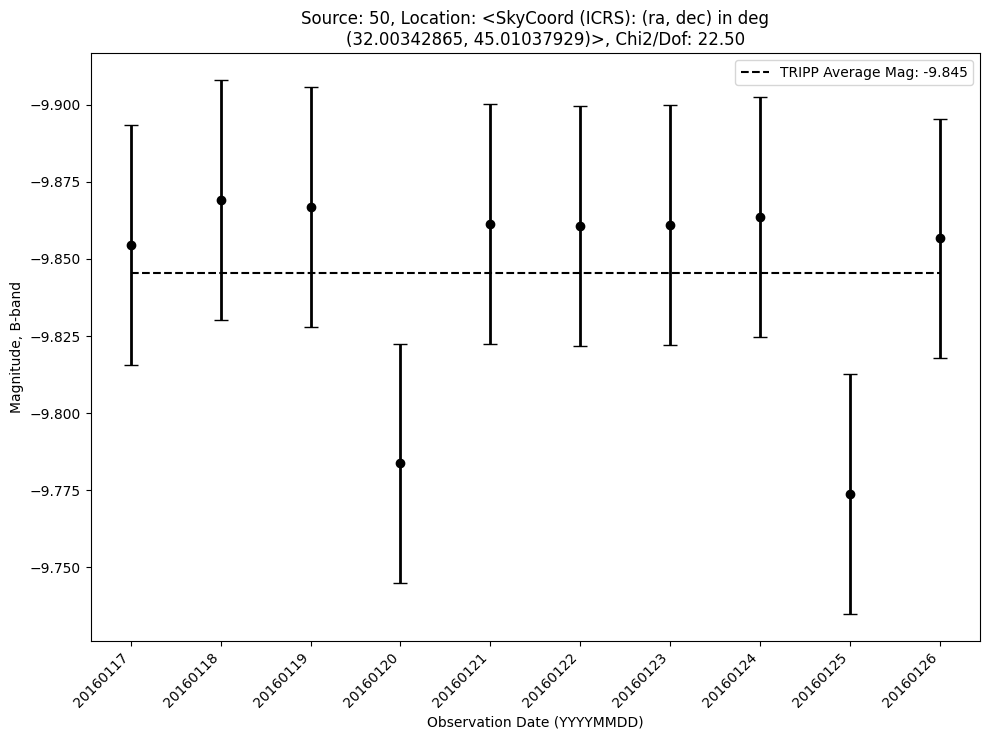

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.06120827, 45.01083123)>, Night_0_xy: (array(1154.49471312), array(1118.49962172)) rad: 7.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.198415790028715, cal_mag_avg: -9.198415790028715, flagged: False, ID: 51, Chi2: None
None
[0.04688916827409295, 0.046869210066045136, 0.04693269678623041, 0.04688268152621117, 0.04675566829221855, 0.04671082603036643, 0.046811865900403565, 0.046826692209108525, 0.04695147768918999, 0.04681958433643609]


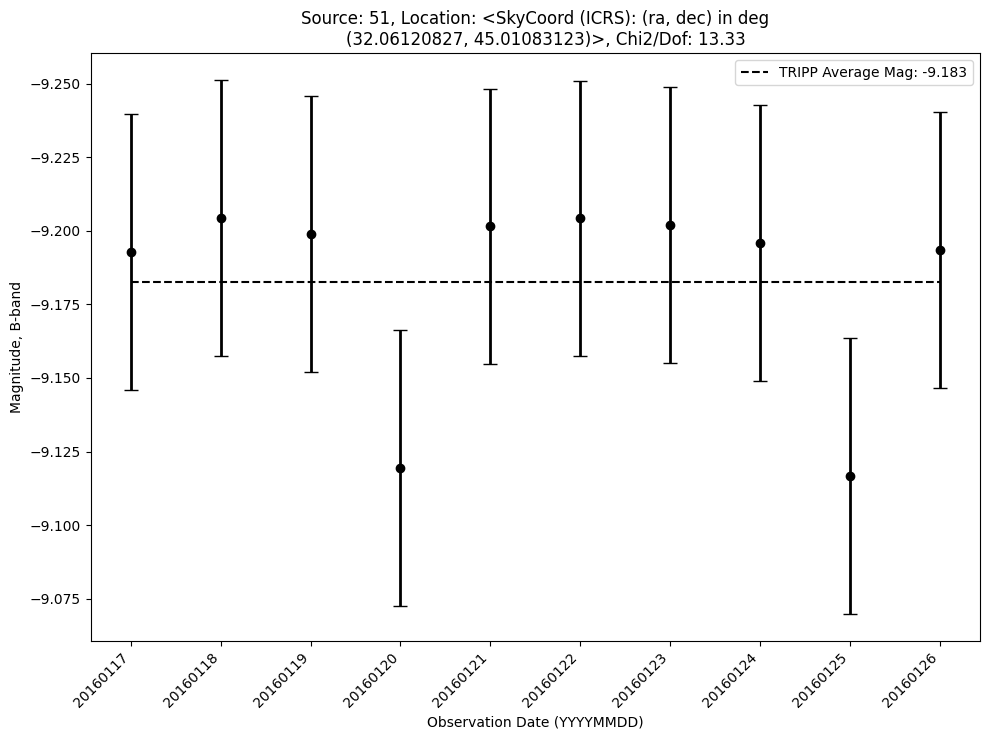

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.78640459, 45.01449394)>, Night_0_xy: (array(2381.4633484), array(1142.54501956)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.557100201384943, cal_mag_avg: -5.557100201384943, flagged: False, ID: 52, Chi2: None
None
[0.40674073840619585, 0.3904631069215879, 0.4142077209857713, 0.3931007558172624, 0.41530201941605044, 0.40177886756537584, 0.4159395091218767, 0.4284910913941741, 0.4189533956287901, 0.4006966730996506]


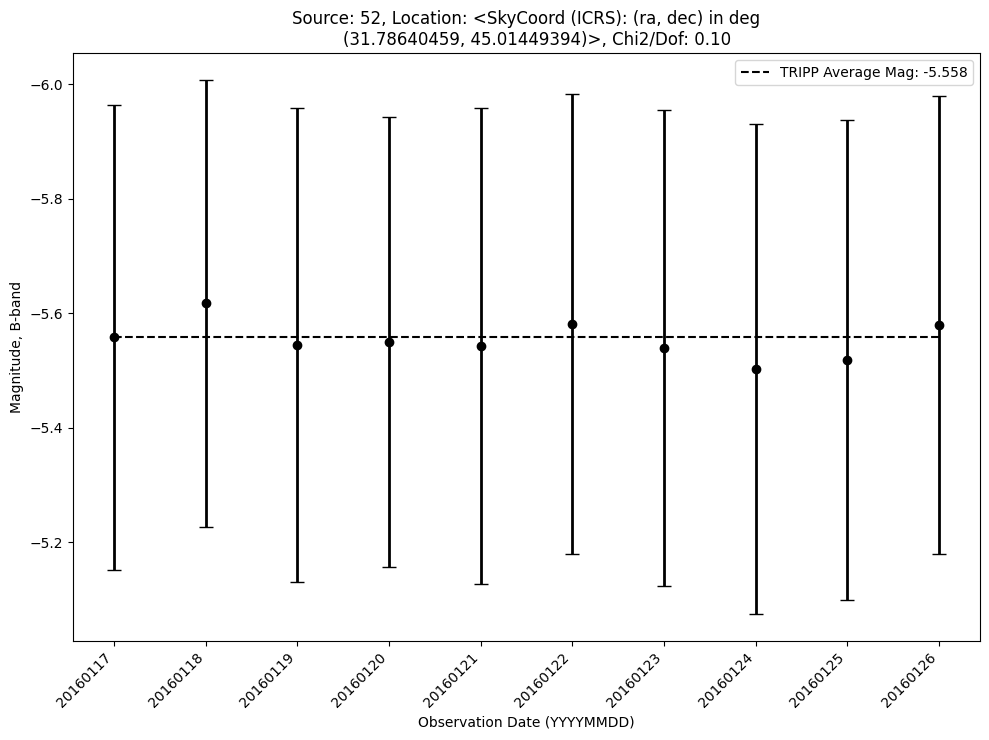

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.99892929, 45.01577377)>, Night_0_xy: (array(1432.58196215), array(1149.55771663)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.924180376286026, cal_mag_avg: -8.924180376286026, flagged: False, ID: 53, Chi2: None
None
[0.30947965373048103, 0.30489785217234056, 0.30463212512839216, 0.14414234121787953, 0.005703906794055223, 0.005702478684489347, 0.005701578740252882, 0.005700448271021159, 0.14926800637992674, 0.30989788239501526]


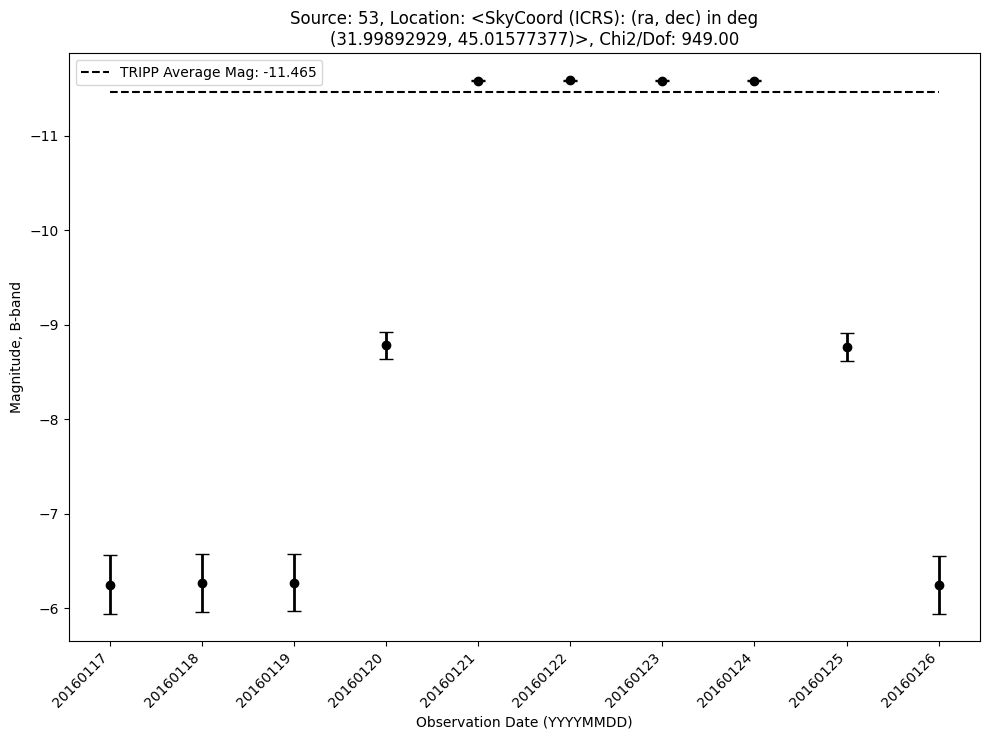

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.70282982, 45.01953683)>, Night_0_xy: (array(2754.49976159), array(1175.4977669)) rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.851311774127039, cal_mag_avg: -11.851311774127039, flagged: False, ID: 54, Chi2: None
None
[0.0376139666739117, 0.037572489366514306, 0.03769628864171337, 0.019422363703175037, 0.001671824714752409, 0.0016721540031567948, 0.0016720281116564175, 0.001671690955364793, 0.01950727228702084, 0.037676981410159495]


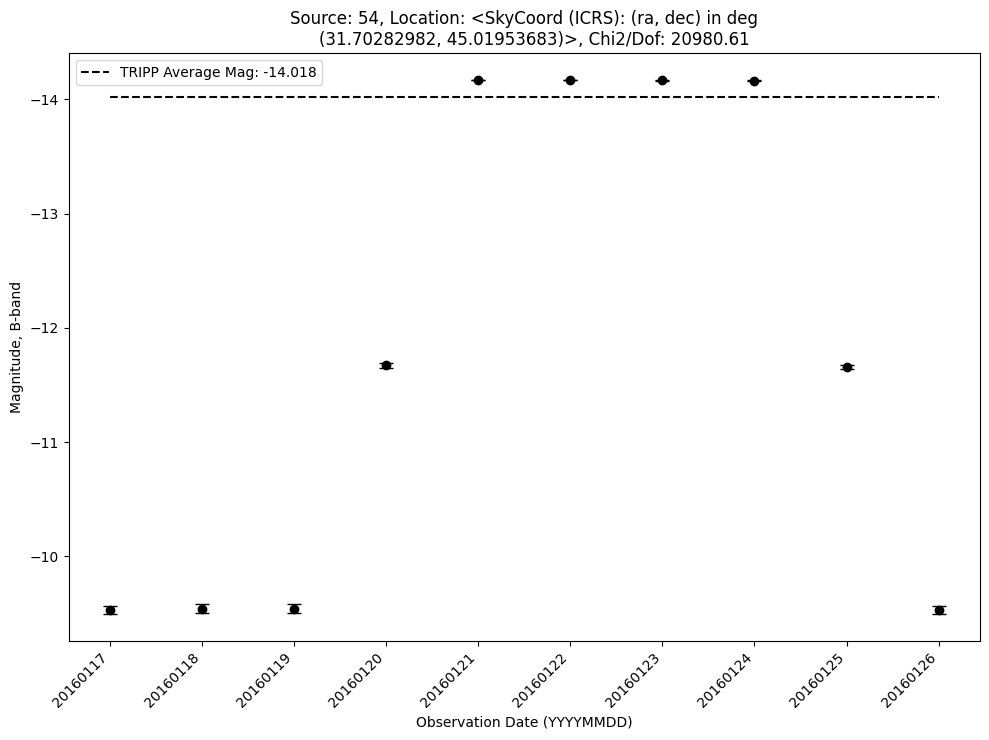

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.0468847, 45.02066164)>, Night_0_xy: (array(1218.49895352), array(1180.53119135)) rad: 6.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.552061623076993, cal_mag_avg: -8.552061623076993, flagged: False, ID: 55, Chi2: None
None
[0.06965437646748023, 0.0699755514210607, 0.07006300564629492, 0.06985523359790868, 0.06992478243049954, 0.07011271532519067, 0.07038794812117484, 0.06987129372595985, 0.07038794217001128, 0.06952810280450009]


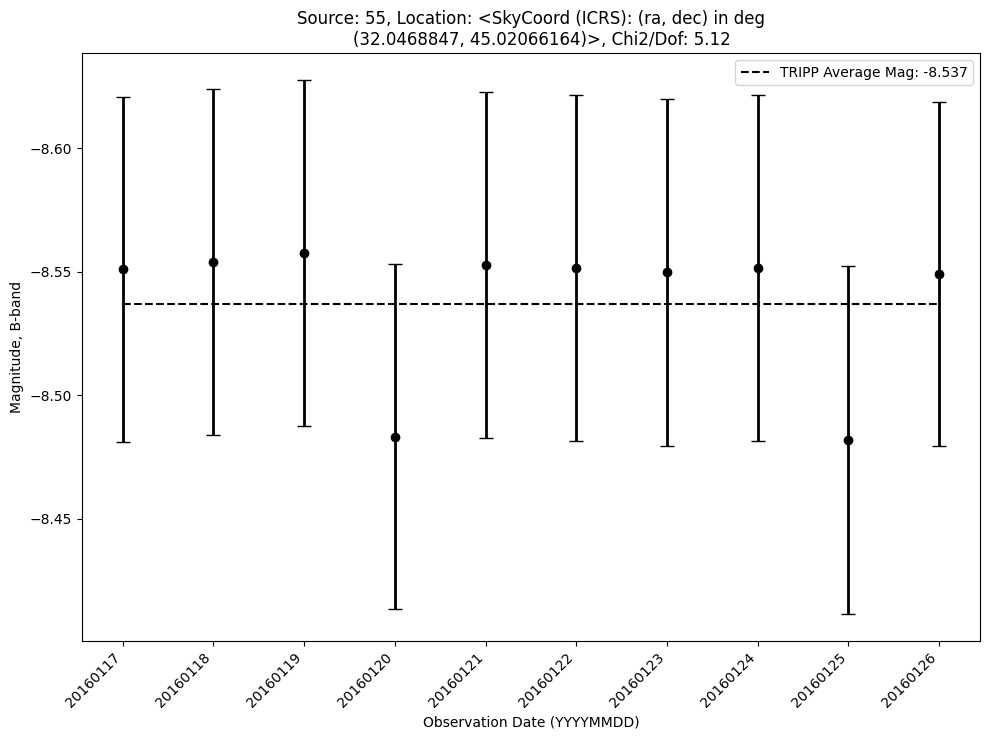

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.99267701, 45.0224152)>, Night_0_xy: (array(1460.5010529), array(1191.49958377)) rad: 19.5, ref_status: None, ref_mag: None, inst_mag_avg:-12.132859451213392, cal_mag_avg: -12.132859451213392, flagged: False, ID: 56, Chi2: None
None
[0.011819898869347959, 0.011822160412891546, 0.01182044191950602, 0.011839528099601492, 0.011821435116850493, 0.01184306750222375, 0.011832632414612649, 0.011829086550178051, 0.011822617899942406, 0.011823506128545621]


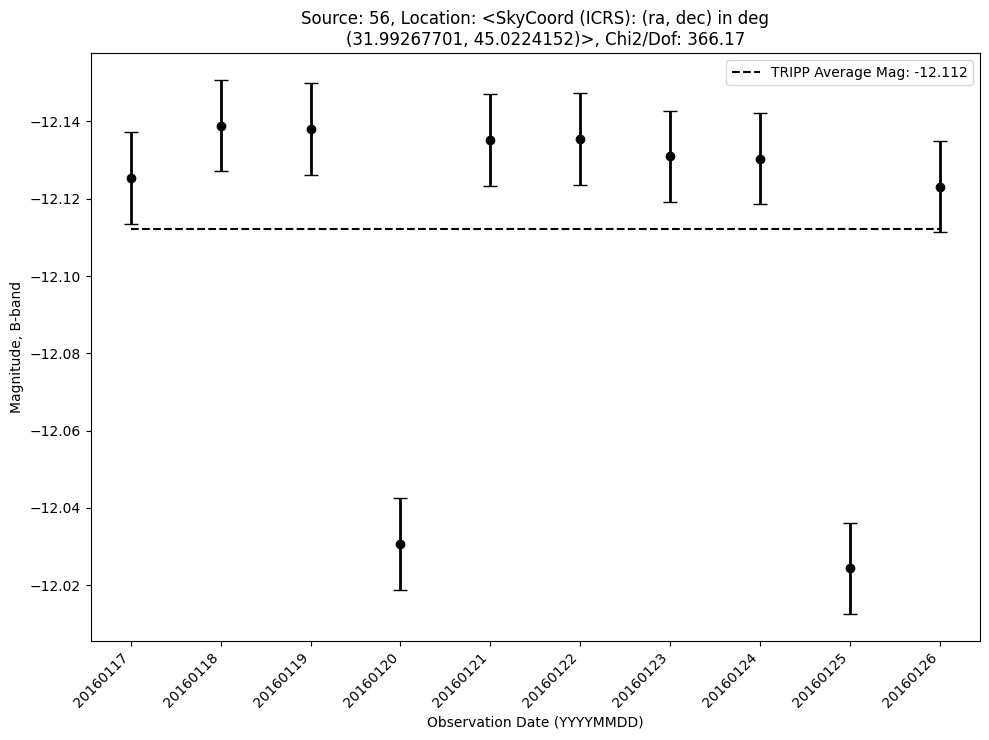

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.92256967, 45.02527593)>, Night_0_xy: (array(1773.45988084), array(1209.66942809)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.5854311913649894, cal_mag_avg: -5.5854311913649894, flagged: False, ID: 57, Chi2: None
None
[0.40293992801860146, 0.3960241050867742, 0.3985265710061814, 0.3977523427486124, 0.40635811998574756, 0.39728633331696395, 0.4047189778190827, 0.3958328270439633, 0.4023226928131981, 0.39123859677529094]


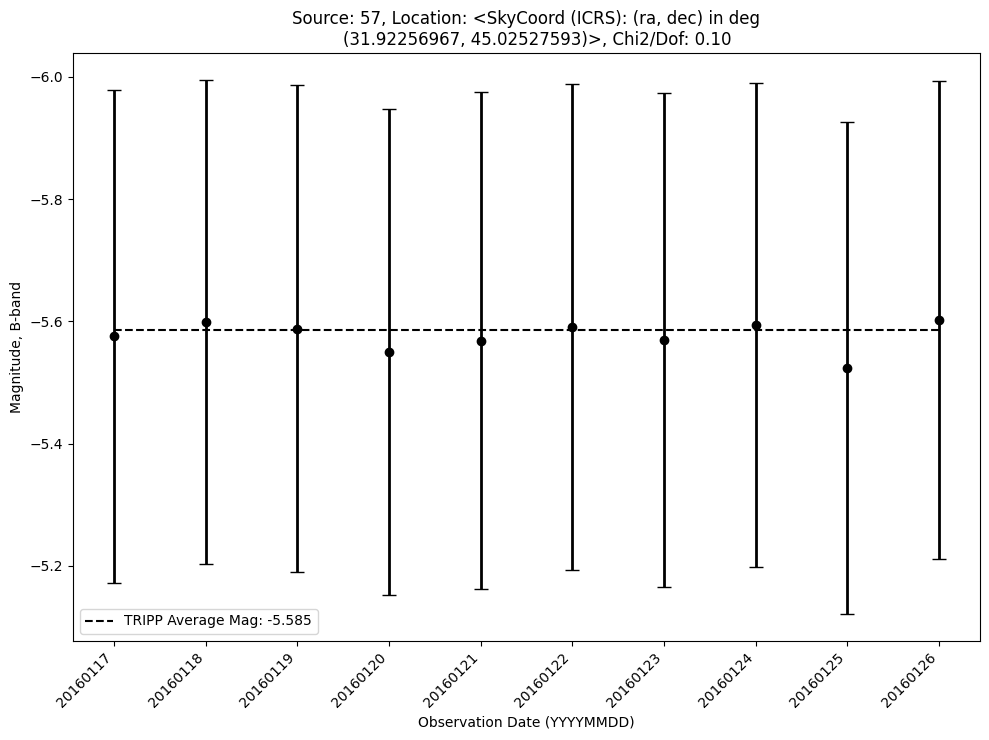

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.90552123, 45.03426179)>, Night_0_xy: (array(1849.50863321), array(1266.4880447)) rad: 10.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.936960749767644, cal_mag_avg: -9.936960749767644, flagged: False, ID: 58, Chi2: None
None
[0.03640749290697667, 0.03651953846818974, 0.036437760567603866, 0.036438837630967405, 0.03629038875670257, 0.036404403135747374, 0.03650805979148759, 0.036375030550980285, 0.03649907008632873, 0.03639075080656769]


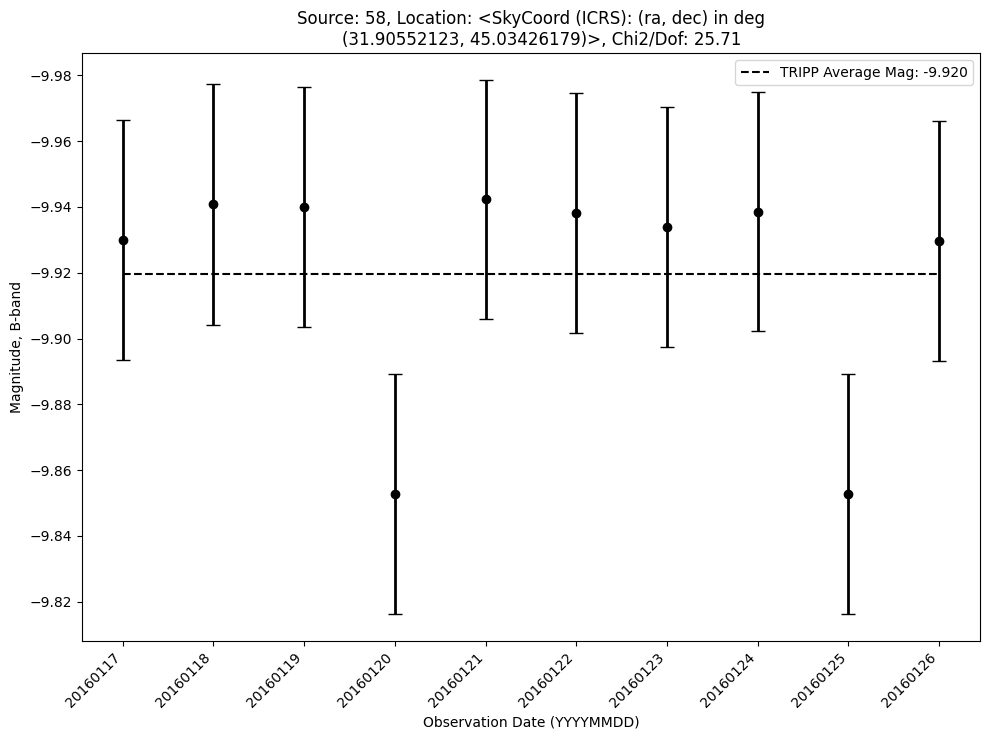

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.95257689, 45.03777745)>, Night_0_xy: (array(1639.4779348), array(1288.5495635)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.315974665451032, cal_mag_avg: -7.315974665451032, flagged: False, ID: 59, Chi2: None
None
[0.15423422505209763, 0.15294028348662855, 0.15526468994189027, 0.15372696755071677, 0.15342850945904837, 0.1553254737020155, 0.15469776151553405, 0.15477222626902046, 0.15399650548517715, 0.1559346067153681]


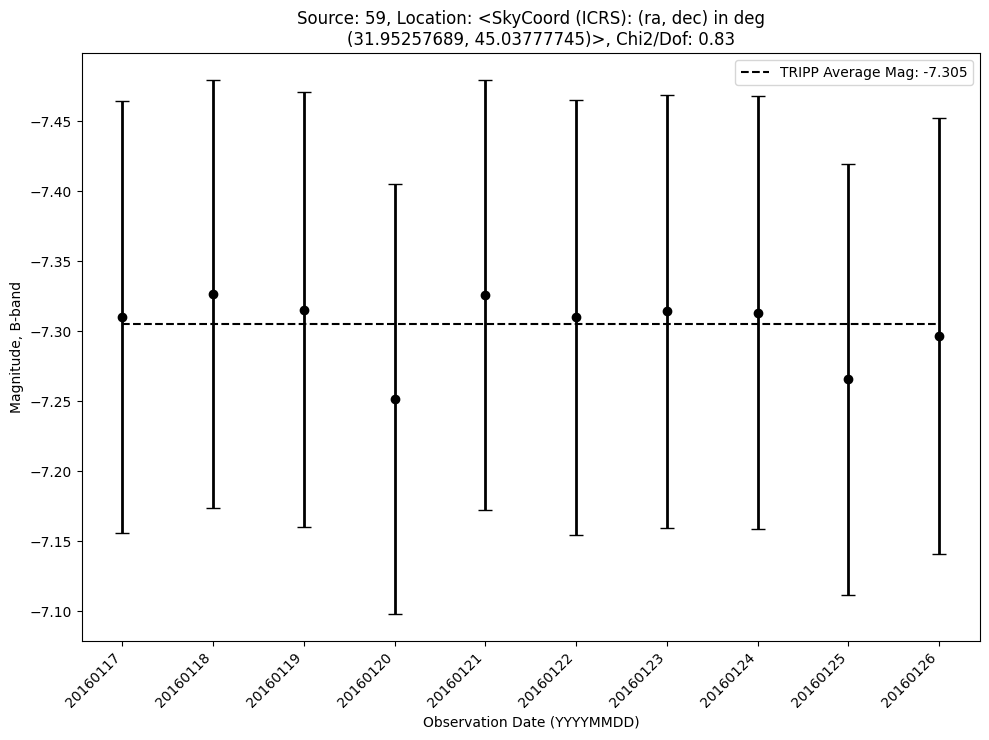

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.15714477, 45.03874966)>, Night_0_xy: (array(726.50536625), array(1295.48819292)) rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.385780475486056, cal_mag_avg: -9.385780475486056, flagged: False, ID: 60, Chi2: None
None
[0.04273101335106955, 0.042904104820237474, 0.04295407992068817, 0.04274542354259236, 0.042879086486187795, 0.04280190877580495, 0.04279677120197132, 0.0426955309753059, 0.04298099740885647, 0.043018362056817194]


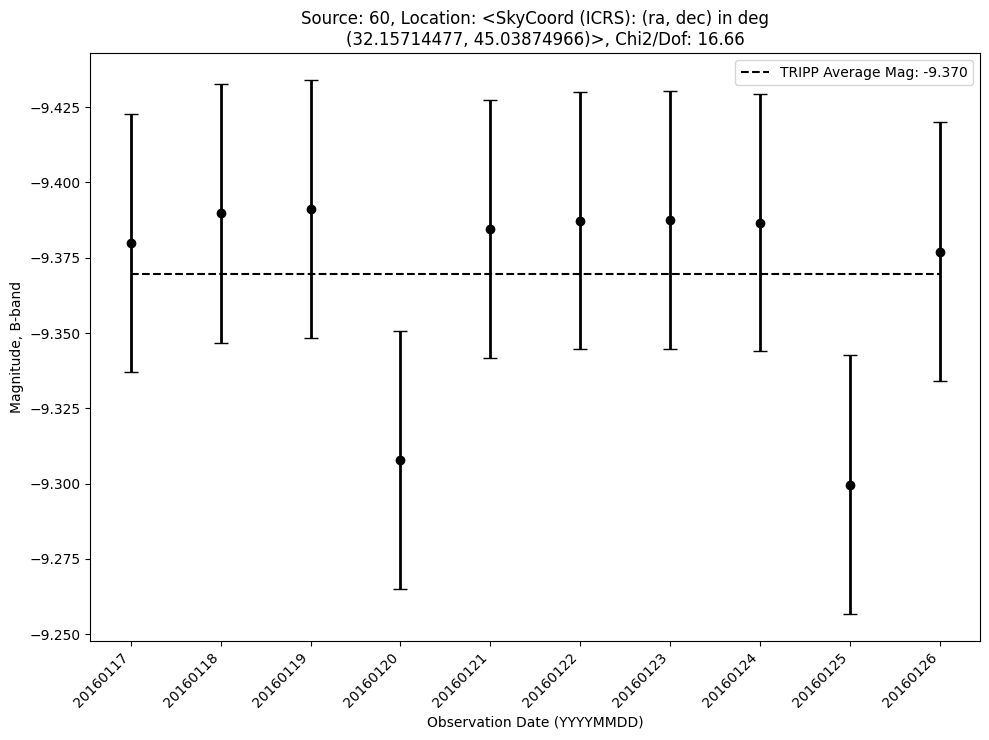

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.29876962, 45.04160287)>, Night_0_xy: (array(94.51235387), array(1315.41236832)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-5.954295277038907, cal_mag_avg: -5.954295277038907, flagged: False, ID: 61, Chi2: None
None
[0.34912350700374567, 0.3457067655197734, 0.34093966116381347, 0.33718278160127646, 0.335787487904714, 0.3381822910153015, 0.3456298509913096, 0.33768438739760065, 0.3461570079742095, 0.3513828150204946]


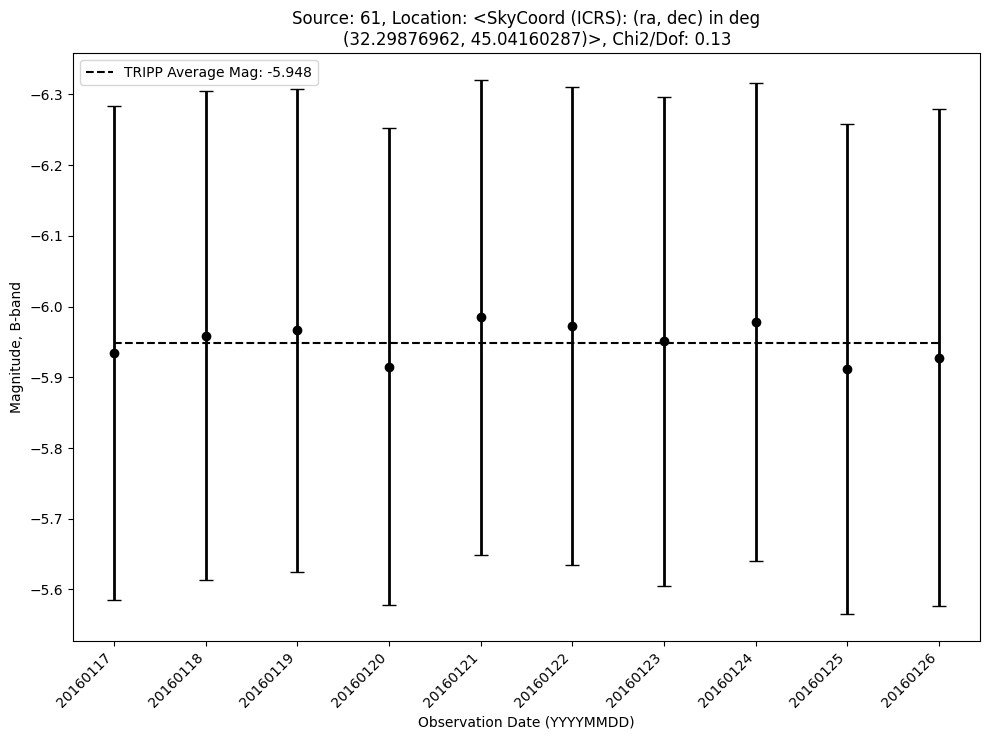

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.71055815, 45.04600661)>, Night_0_xy: (array(2719.4328933), array(1342.55731724)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.301521606458019, cal_mag_avg: -6.301521606458019, flagged: False, ID: 62, Chi2: None
None
[0.29199352687217495, 0.2913827277946666, 0.2997502041051297, 0.28937651647796436, 0.2923976184352891, 0.2945310269144084, 0.29981655297958243, 0.30057436060545384, 0.2925562273625758, 0.2970311578817353]


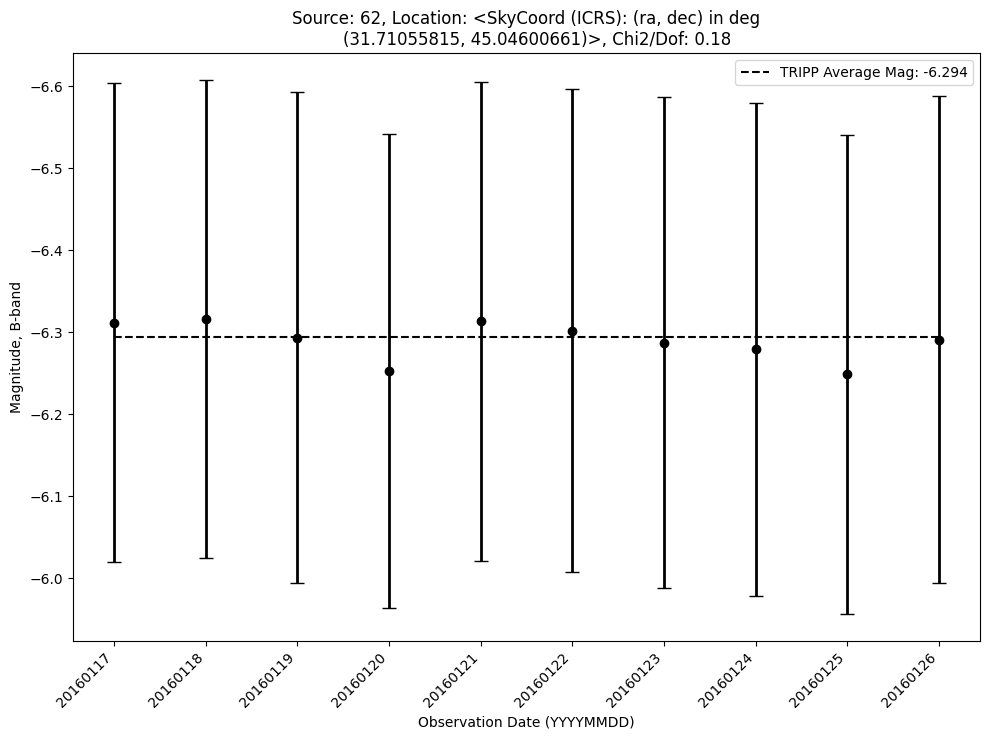

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.2058036, 45.04863822)>, Night_0_xy: (array(509.5152374), array(1358.47176352)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.2583388805503715, cal_mag_avg: -6.2583388805503715, flagged: False, ID: 63, Chi2: None
None
[0.3080325110660479, 0.3165438638633442, 0.3124344693444965, 0.31079855440606796, 0.30386799614617943, 0.3005412626645595, 0.31520190253975455, 0.30225281881778476, 0.30846596711804053, 0.30723476820910256]


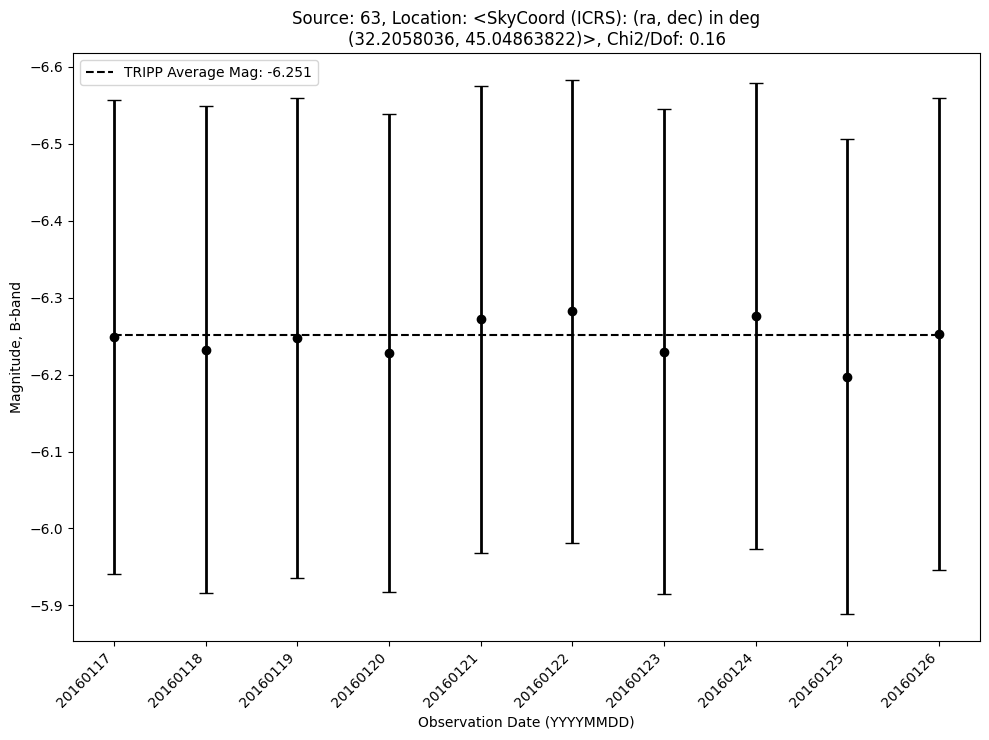

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.07516177, 45.05119586)>, Night_0_xy: (array(1092.47761458), array(1373.49897669)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.111353551888475, cal_mag_avg: -7.111353551888475, flagged: False, ID: 64, Chi2: None
None
[0.1864230522942831, 0.1846991931047029, 0.1873741001873136, 0.18520077655690975, 0.18507762378826526, 0.18400559130340843, 0.18756911916531394, 0.18771935034078358, 0.18545453878331222, 0.1847180124601867]


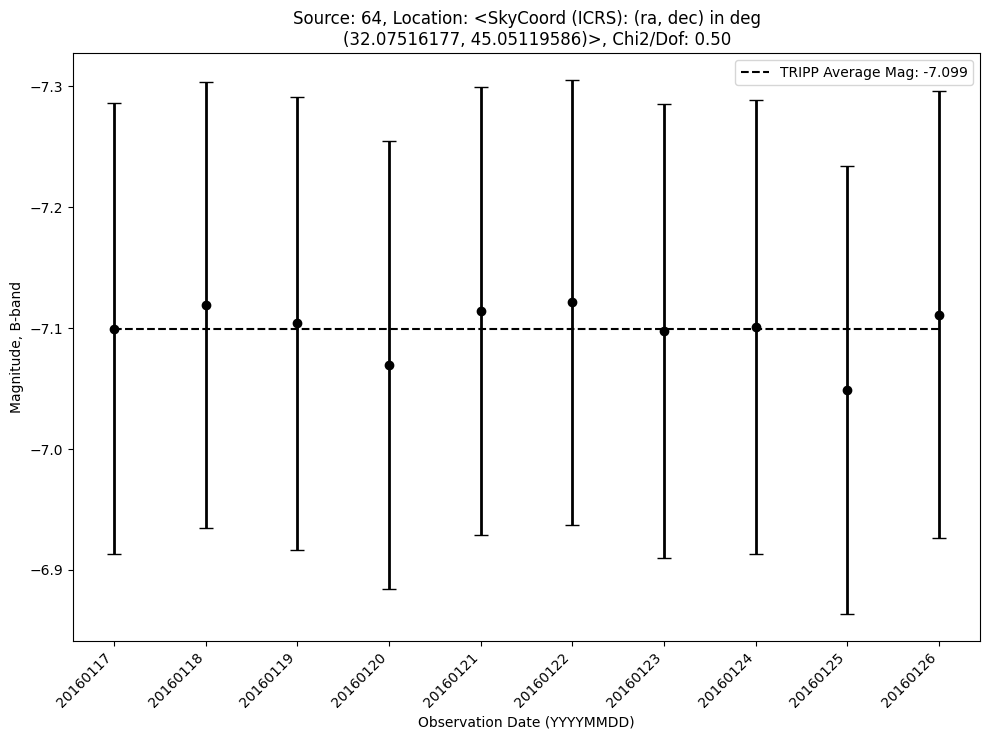

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.81943049, 45.05238217)>, Night_0_xy: (array(2233.52259564), array(1381.50954855)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.957137995014962, cal_mag_avg: -6.957137995014962, flagged: False, ID: 65, Chi2: None
None
[0.21323776237519837, 0.21112116365624767, 0.21588822867405222, 0.21634483952201133, 0.20906454072240221, 0.21278724038273195, 0.21213469799644766, 0.21126377411210445, 0.2156651240723551, 0.2157272245366526]


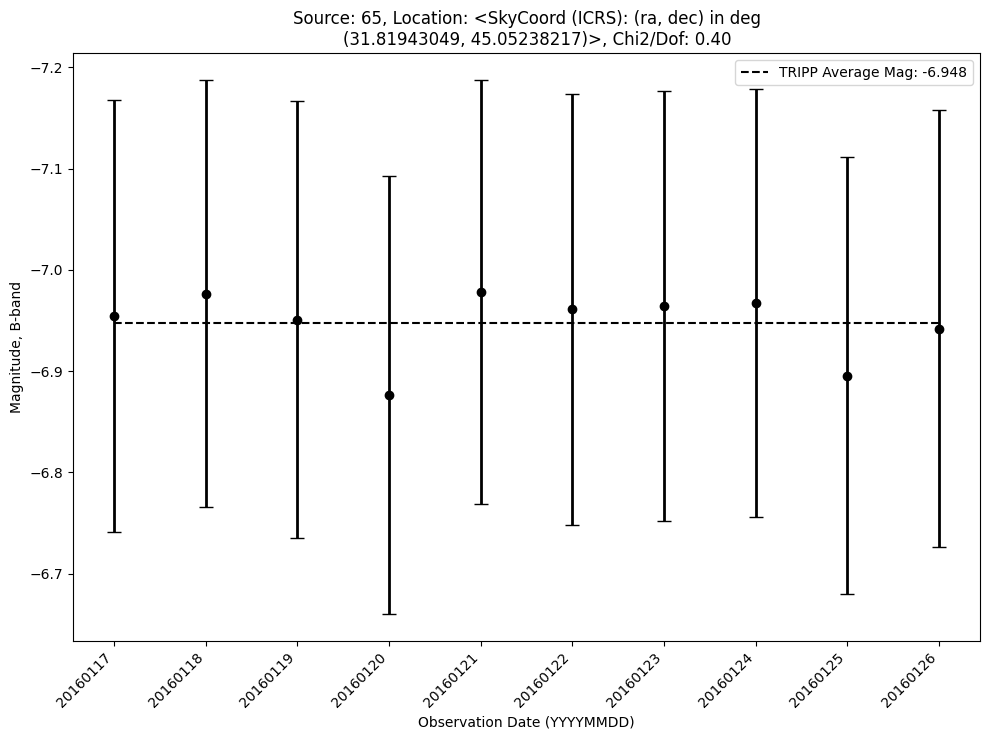

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.17782122, 45.0566119)>, Night_0_xy: (array(634.49757752), array(1408.51153414)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.7675516265158, cal_mag_avg: -8.7675516265158, flagged: False, ID: 66, Chi2: None
None
[0.06296499010035783, 0.06290633348588384, 0.06324927327782817, 0.06314639250668966, 0.063289225412305, 0.06295605892047093, 0.06287953001593811, 0.06314100484144329, 0.06296689879831614, 0.06303105280992136]


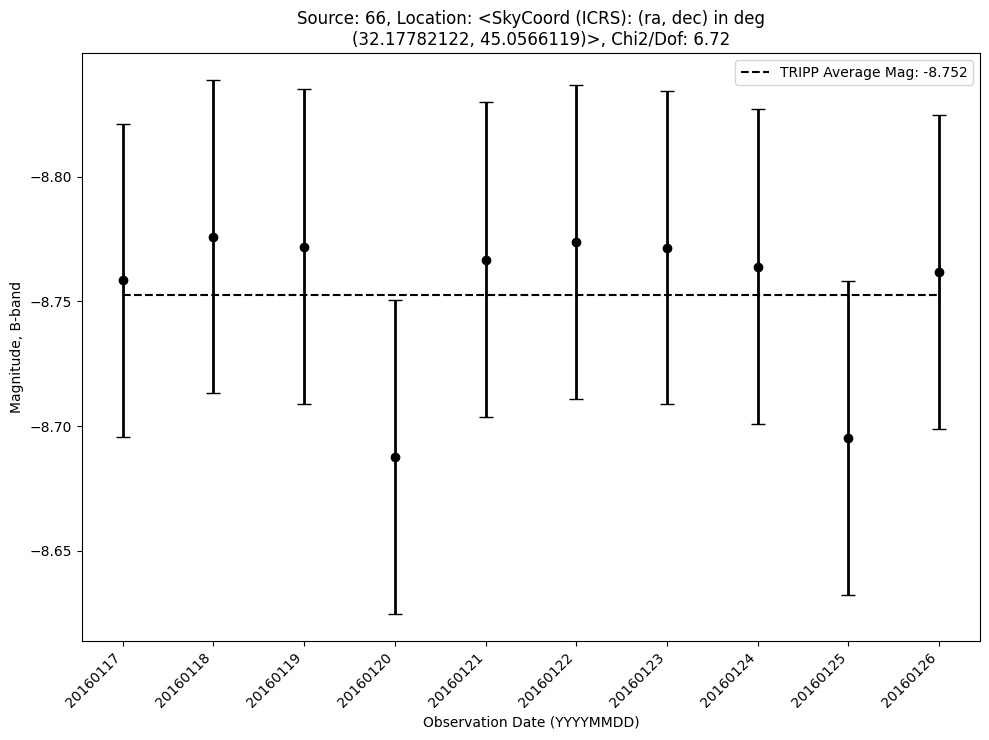

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.81604778, 45.06219496)>, Night_0_xy: (array(2248.48731583), array(1443.51612407)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.099882638870827, cal_mag_avg: -9.099882638870827, flagged: False, ID: 67, Chi2: None
None
[0.04727725209630404, 0.047355563631500494, 0.04727433789124339, 0.0471085103200163, 0.047422687260609414, 0.04708510958810333, 0.04717748768568618, 0.04712714687594989, 0.04698973586342519, 0.04715002324723703]


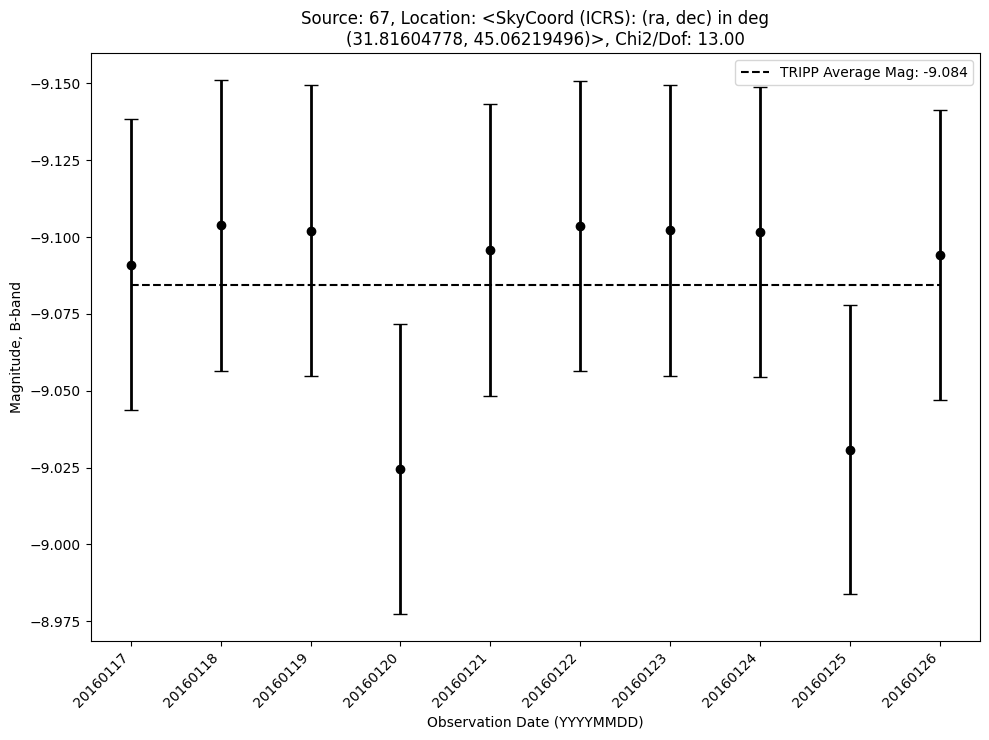

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.18255107, 45.06294712)>, Night_0_xy: (array(613.49317385), array(1448.5745959)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.547906346266319, cal_mag_avg: -6.547906346266319, flagged: False, ID: 68, Chi2: None
None
[0.23200784724720858, 0.2382646873127933, 0.24738034045528406, 0.23335807407959344, 0.2359979372751632, 0.23566028682168555, 0.23607100020322286, 0.2345226161466748, 0.23814690107715247, 0.23409488305625842]


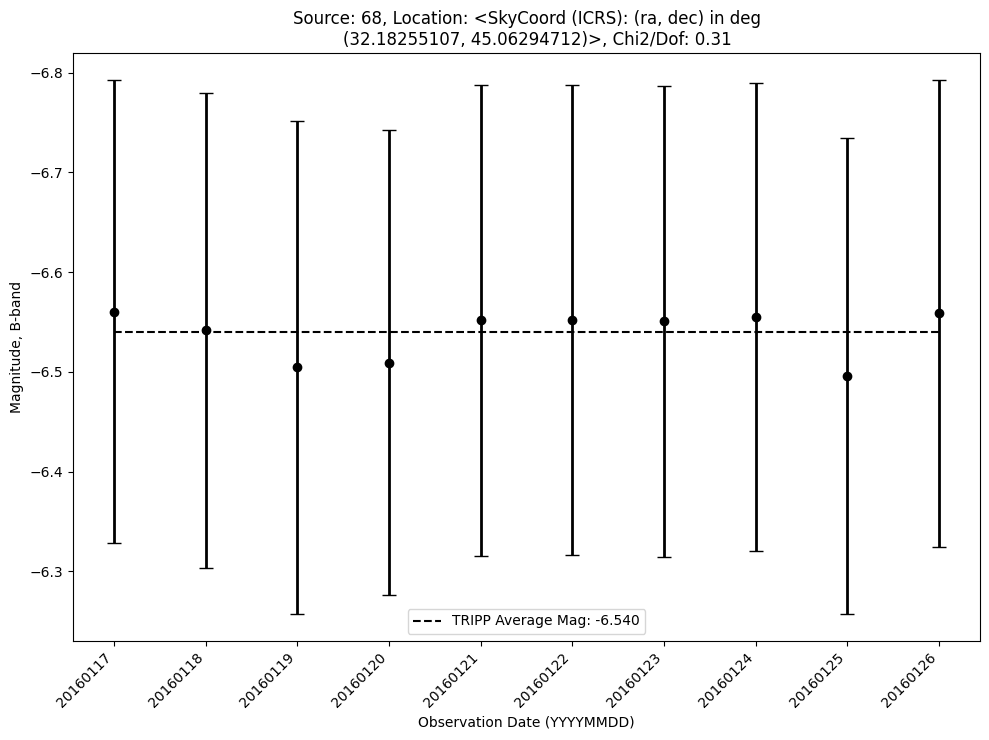

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.91915024, 45.06863345)>, Night_0_xy: (array(1788.50480012), array(1483.51860089)) rad: 6.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.961135196080546, cal_mag_avg: -10.961135196080546, flagged: False, ID: 69, Chi2: None
None
[0.07260662426890134, 0.07256723538832216, 0.07241697947309511, 0.037121540029489565, 0.0023849343859636257, 0.0023842991449723756, 0.002384490099591273, 0.0023840438189957147, 0.037429851002364026, 0.07243117512377426]


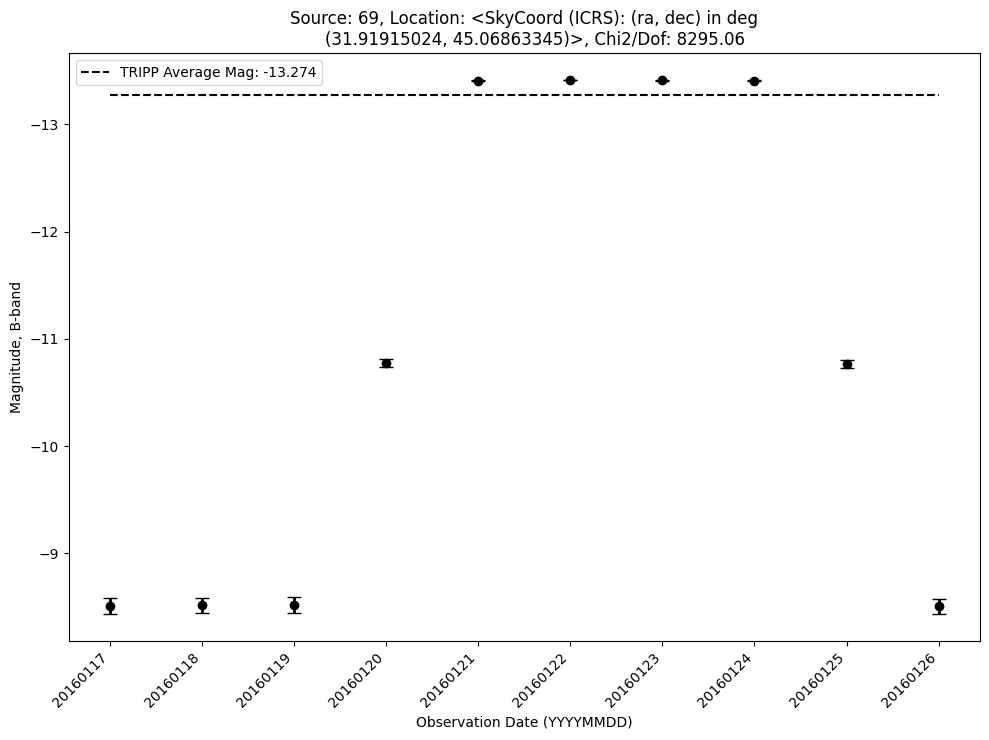

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.86646829, 45.07129274)>, Night_0_xy: (array(2023.47312524), array(1500.57909846)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.056852583651742, cal_mag_avg: -7.056852583651742, flagged: False, ID: 70, Chi2: None
None
[0.2477895423868047, 0.24508732448249476, 0.23985178920391753, 0.24707587602936704, 0.2476973679596187, 0.23968687431228303, 0.24216133568009163, 0.23477438097351433, 0.24612854875890172, 0.2456960281392406]


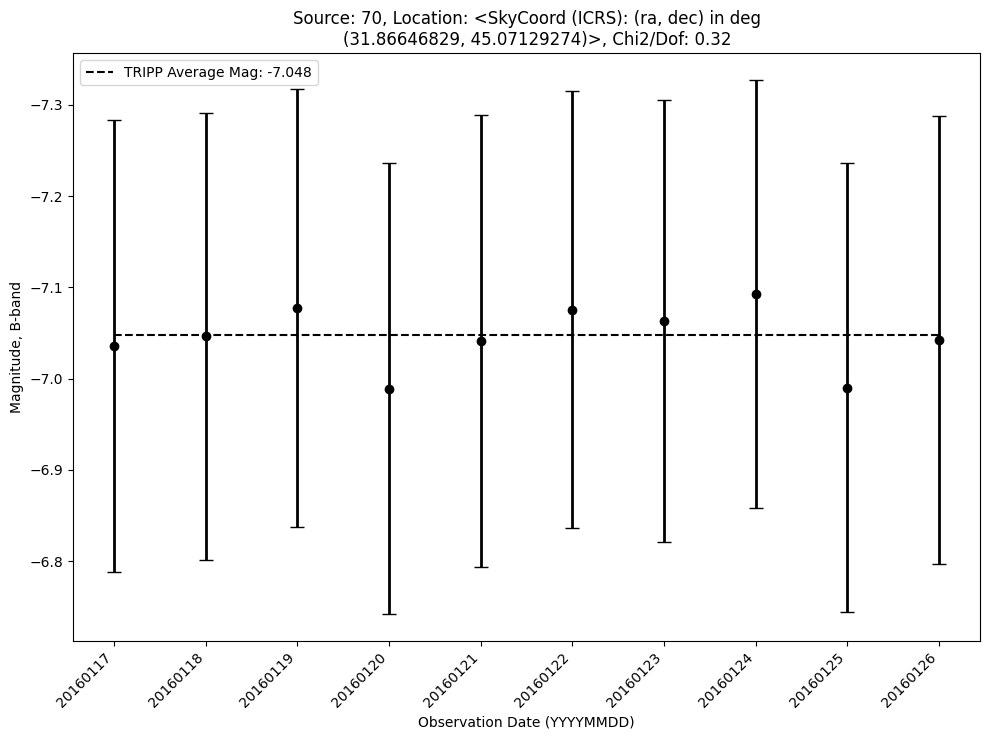

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.86735154, 45.07333398)>, Night_0_xy: (array(2019.51491009), array(1513.46544267)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.947246125829116, cal_mag_avg: -8.947246125829116, flagged: False, ID: 71, Chi2: None
None
[0.05358071647072338, 0.053875264610252084, 0.054184229594318914, 0.053875999239586345, 0.05409316361270136, 0.05403448661824568, 0.05396680123431958, 0.053926242744518155, 0.05378402083707448, 0.0540326230619639]


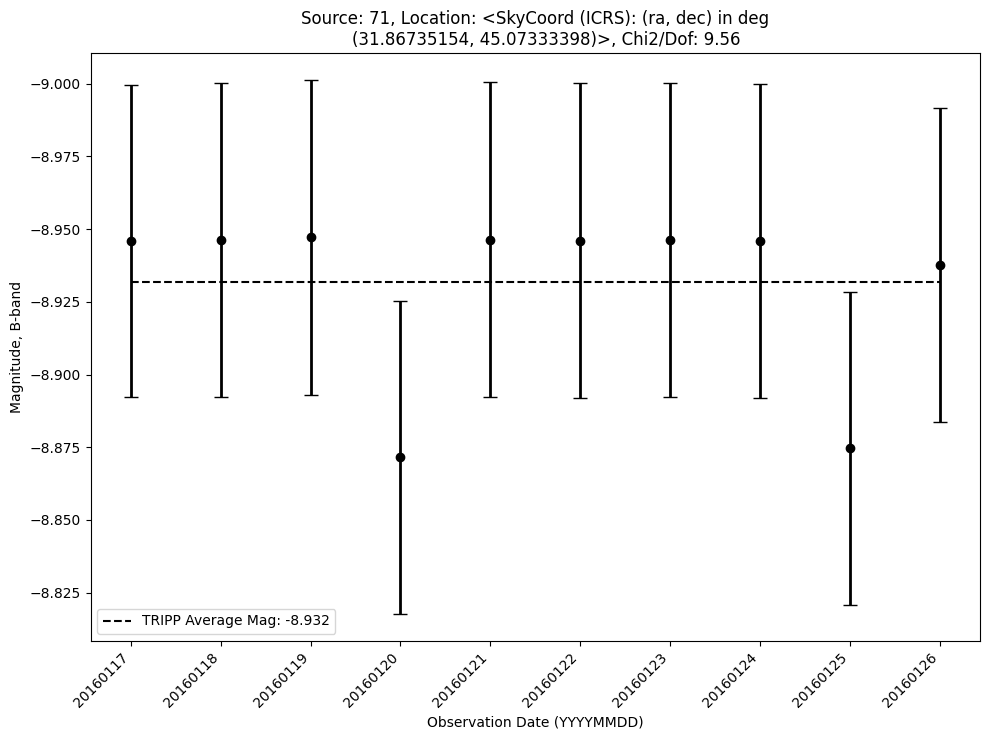

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.8982986, 45.07415463)>, Night_0_xy: (array(1881.47854935), array(1518.47583211)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.563544266972751, cal_mag_avg: -7.563544266972751, flagged: False, ID: 72, Chi2: None
None
[0.15391639973945648, 0.15515874466848623, 0.1549183001468355, 0.15378964899670272, 0.15438140218950663, 0.1521376553978812, 0.1526691919529367, 0.15330522223032916, 0.15368493882221246, 0.1545740939829869]


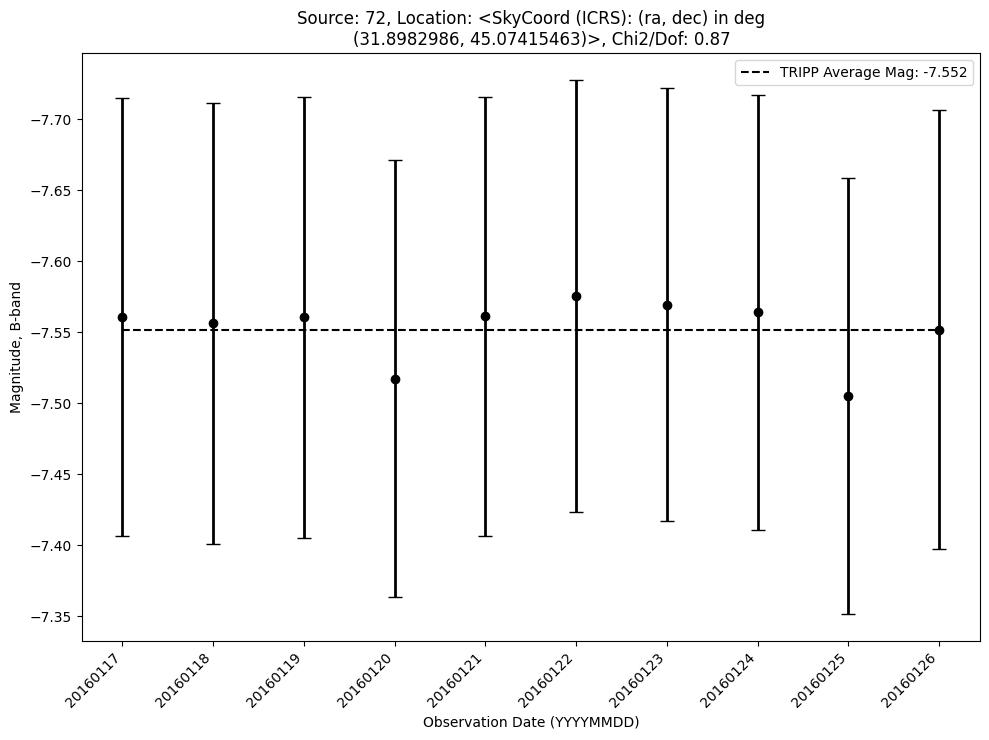

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.96487769, 45.07958731)>, Night_0_xy: (array(1584.51706686), array(1552.59505272)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.514517368336898, cal_mag_avg: -5.514517368336898, flagged: False, ID: 73, Chi2: None
None
[0.42097261293176735, 0.4330954987480556, 0.4168983013173093, 0.41217319273719855, 0.42028864263705457, 0.42340245902705553, 0.4282762972236942, 0.4288802850626099, 0.424331806657553, 0.43039764760563304]


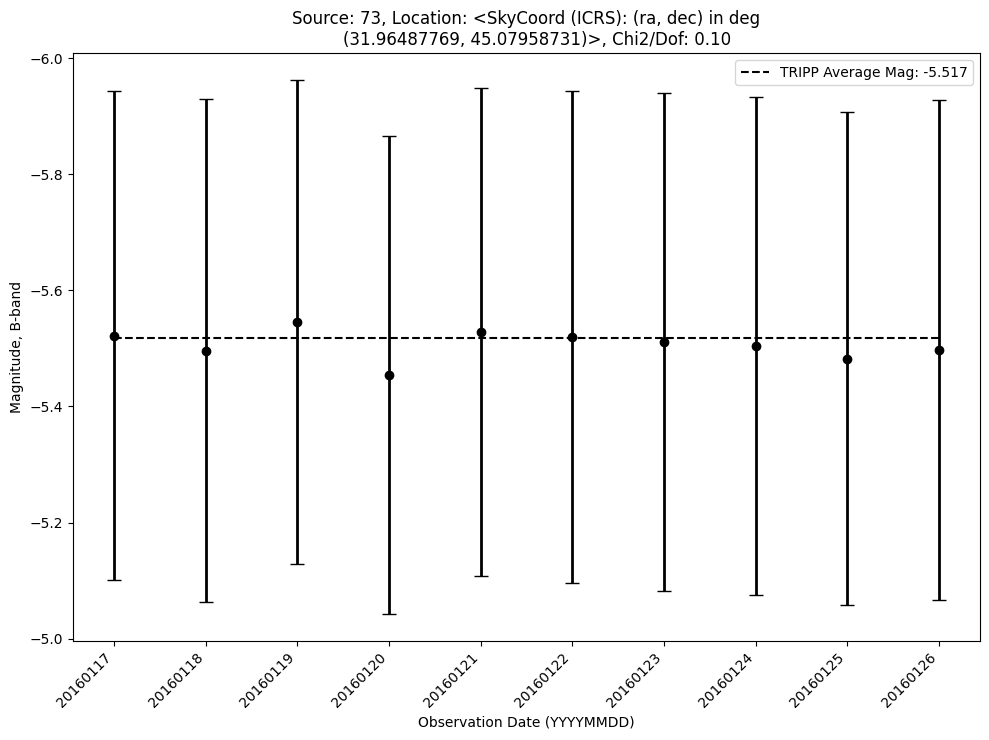

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.71754998, 45.07973953)>, Night_0_xy: (array(2687.5320924), array(1555.50359945)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.651295050291371, cal_mag_avg: -5.651295050291371, flagged: False, ID: 74, Chi2: None
None
[0.37813019941143167, 0.3685357105374715, 0.36958333238649543, 0.36667128851282227, 0.3697603548132047, 0.37209875166366296, 0.38558027377534654, 0.3775315928611391, 0.383490869440713, 0.3753297158794269]


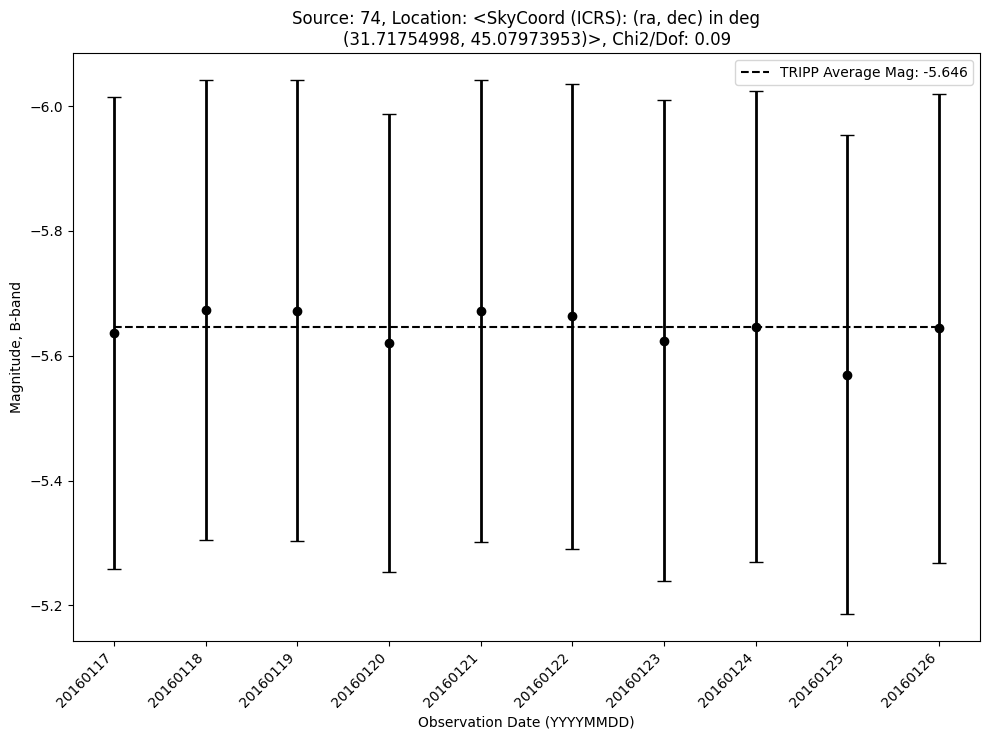

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.98977175, 45.08147563)>, Night_0_xy: (array(1473.49702336), array(1564.51209557)) rad: 15.0, ref_status: None, ref_mag: None, inst_mag_avg:-13.338163284525873, cal_mag_avg: -13.338163284525873, flagged: False, ID: 75, Chi2: None
None
[0.015530696197322995, 0.01550651496920059, 0.015497895322373533, 0.008279606985346931, 0.001088535772435958, 0.0010883962080977727, 0.0010885042275014657, 0.0010885439899883977, 0.00827630149531392, 0.015494252690126446]


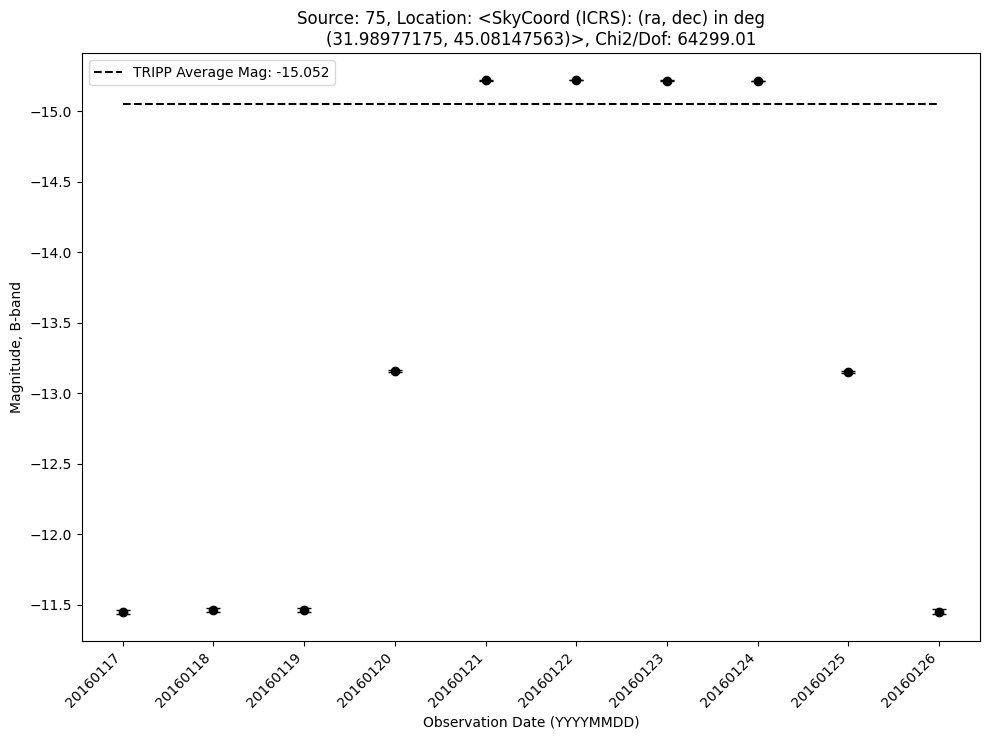

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.27993221, 45.08156697)>, Night_0_xy: (array(179.50010509), array(1567.500652)) rad: 15.0, ref_status: None, ref_mag: None, inst_mag_avg:-13.307505765707118, cal_mag_avg: -13.307505765707118, flagged: False, ID: 76, Chi2: None
None
[0.016103924623236697, 0.016091295032539303, 0.01609662772561148, 0.008555393367108186, 0.001099041235112232, 0.0010989751852930251, 0.0010989880843298378, 0.0010989900655972102, 0.008584935214119422, 0.016088011731673048]


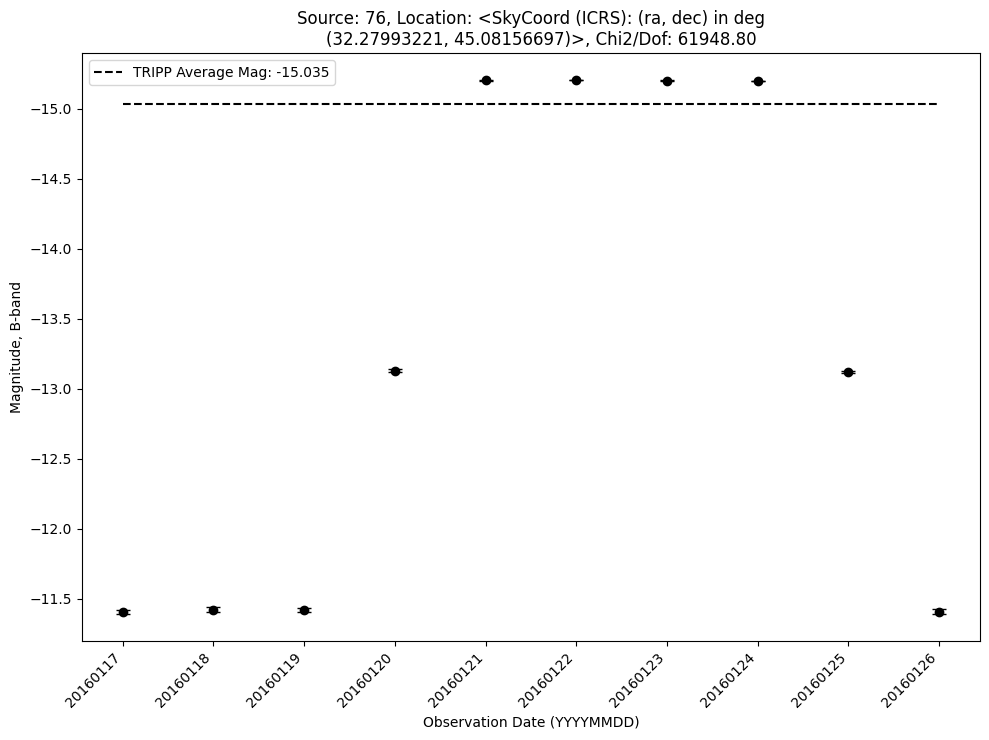

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.7803184, 45.08461654)>, Night_0_xy: (array(2407.52368372), array(1585.49245834)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.901563989084227, cal_mag_avg: -9.901563989084227, flagged: False, ID: 77, Chi2: None
None
[0.1542895351961256, 0.15258412999622048, 0.15641462395009187, 0.0778994494841047, 0.0036824957676736495, 0.0036820605381070372, 0.0036831639352975934, 0.0036821396603035073, 0.07533725025822817, 0.15453193787374014]


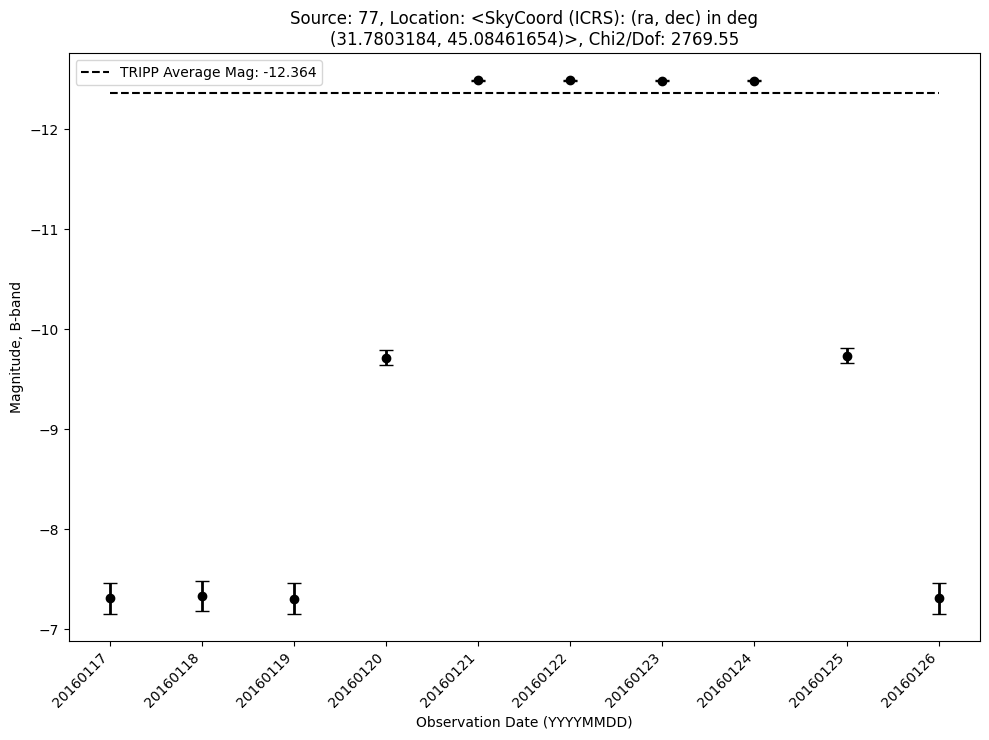

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.79019301, 45.08447417)>, Night_0_xy: (array(2363.49145076), array(1584.48504355)) rad: 7.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.217616117075318, cal_mag_avg: -9.217616117075318, flagged: False, ID: 78, Chi2: None
None
[0.046051650701528786, 0.04605593207964259, 0.04612402949812511, 0.046040317873849435, 0.045862429699996626, 0.046310601376116395, 0.04608875562555188, 0.046122015751243806, 0.046125926848067586, 0.04592330611988704]


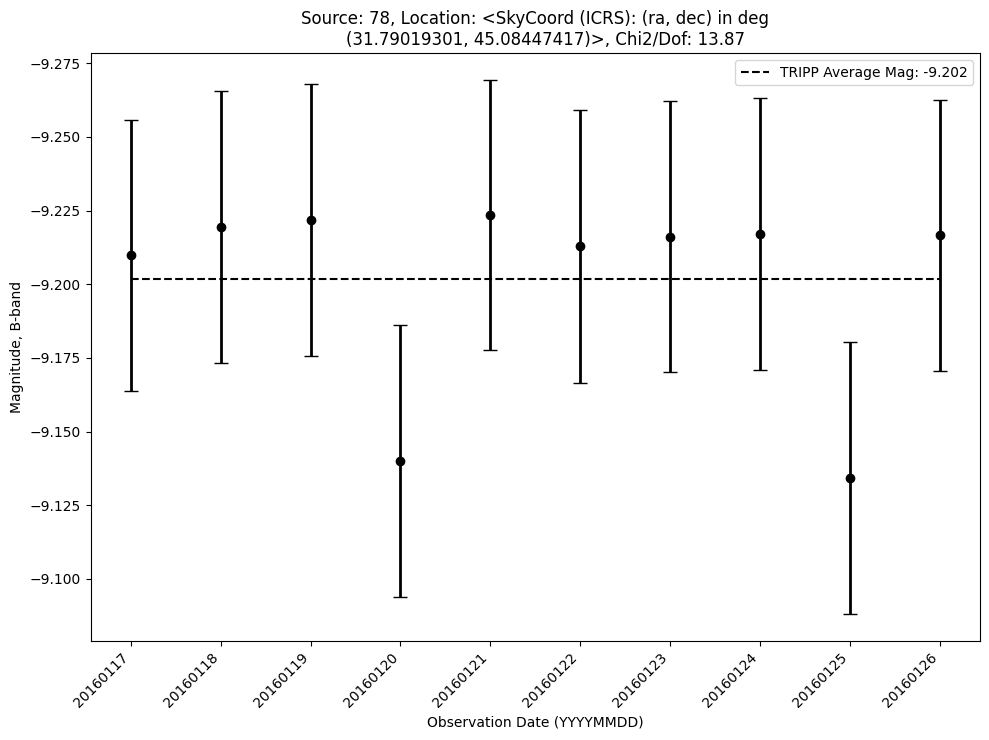

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.08843859, 45.08395953)>, Night_0_xy: (array(1033.50363946), array(1580.49930054)) rad: 15.0, ref_status: None, ref_mag: None, inst_mag_avg:-13.304753408649335, cal_mag_avg: -13.304753408649335, flagged: False, ID: 79, Chi2: None
None
[0.016168368428960925, 0.016152439124270206, 0.016144139936095557, 0.008603039851241473, 0.0010998935017122523, 0.0010999342140050345, 0.0010997188628349157, 0.0010999962577839277, 0.008599227665239555, 0.01615159649179404]


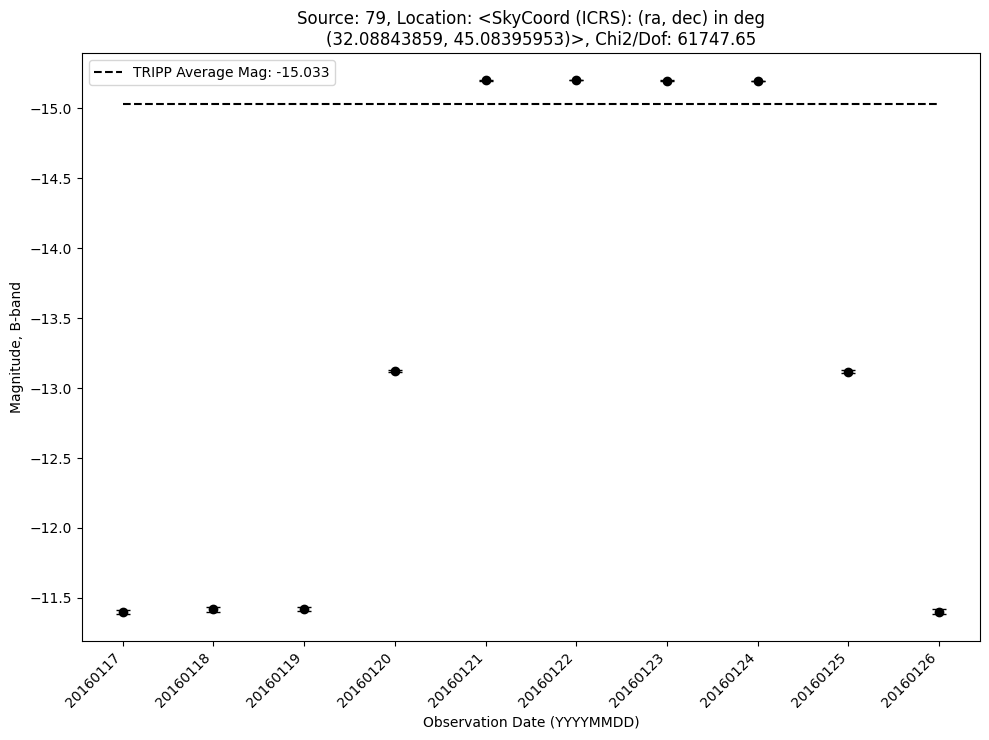

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.75018512, 45.10735921)>, Night_0_xy: (array(2541.48431781), array(1729.49419301)) rad: 15.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.548115252345182, cal_mag_avg: -11.548115252345182, flagged: False, ID: 80, Chi2: None
None
[0.014348437657082793, 0.014351074916039545, 0.014356189969180096, 0.014365970045799072, 0.014335471340950222, 0.014339711863605078, 0.014348230422418387, 0.014341562732087525, 0.01436298540232789, 0.014360584386066359]


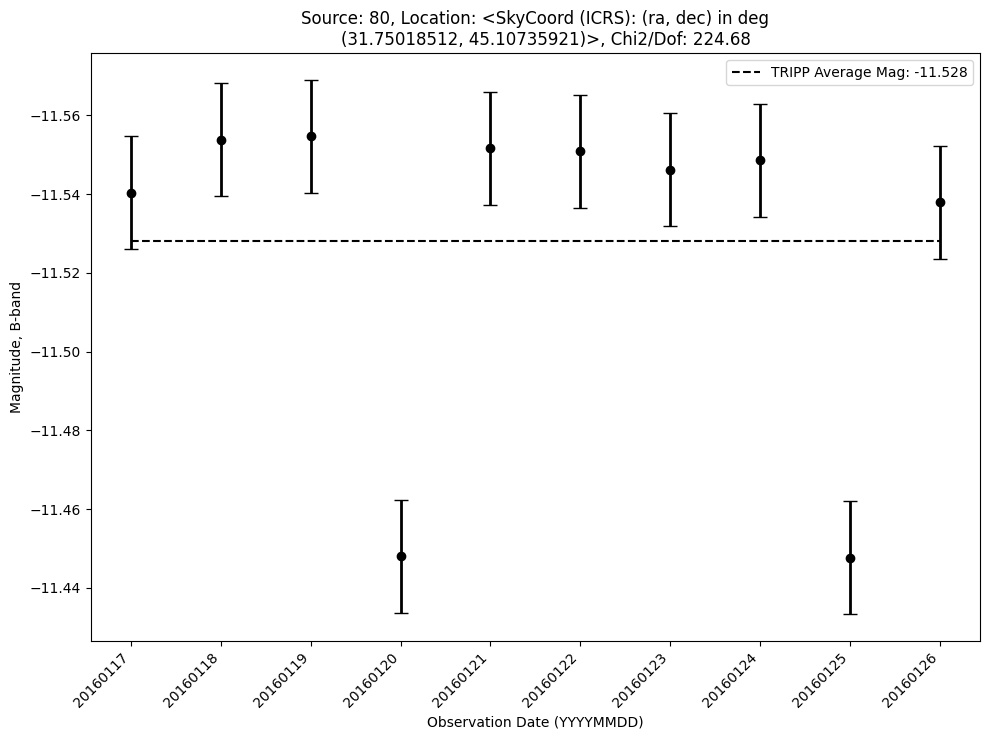

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.93772967, 45.11028155)>, Night_0_xy: (array(1705.47926274), array(1746.5030754)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.88139374231272, cal_mag_avg: -7.88139374231272, flagged: False, ID: 81, Chi2: None
None
[0.11484688080870294, 0.11620703441832236, 0.11643180836223871, 0.11592964293339131, 0.11517016678806893, 0.11442121145082546, 0.11512168951813462, 0.11523087515851027, 0.11433133001262882, 0.11578509427152636]


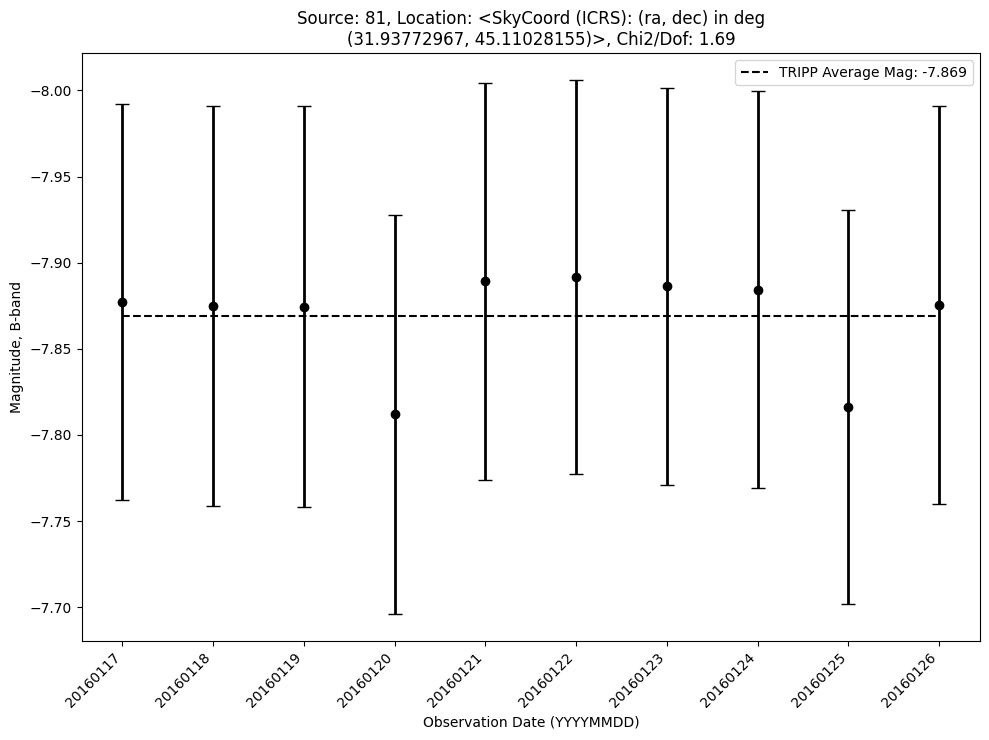

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.10821116, 45.1106887)>, Night_0_xy: (array(945.5885021), array(1749.44019682)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.303316669368806, cal_mag_avg: -9.303316669368806, flagged: False, ID: 82, Chi2: None
None
[0.24626382604748803, 0.24284964560740627, 0.2413213935553527, 0.11974083070568335, 0.004827602316307218, 0.004827826810830056, 0.004824944169379101, 0.004824728859187111, 0.11711163990864244, 0.24210193433496585]


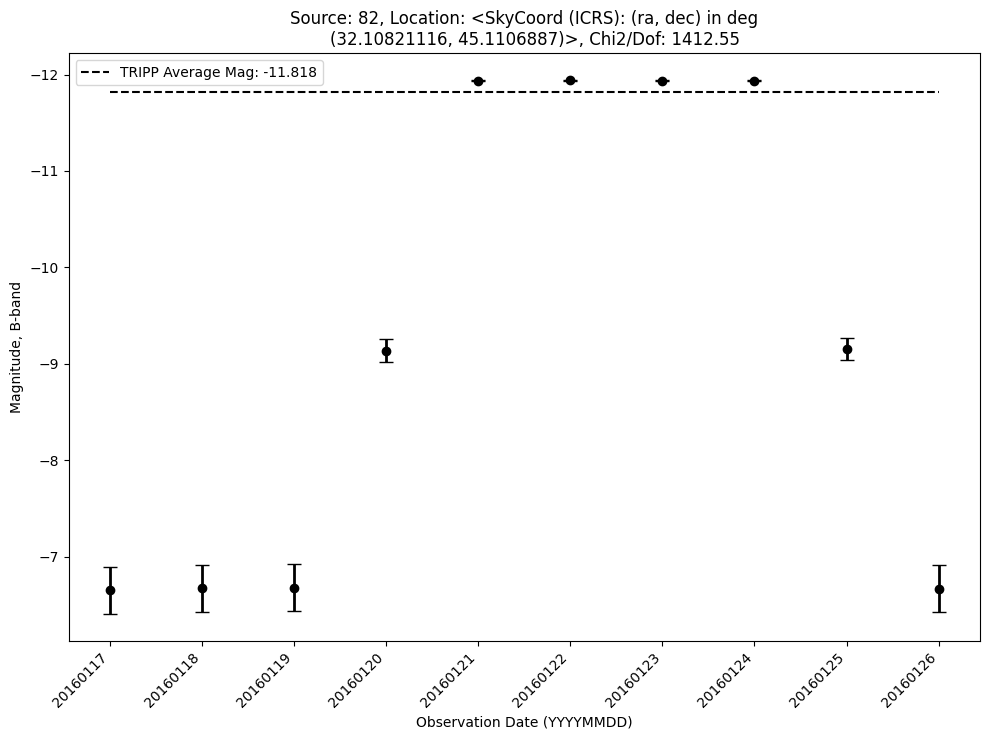

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.77522775, 45.12134145)>, Night_0_xy: (array(2429.62701684), array(1817.49796563)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.492028041271826, cal_mag_avg: -5.492028041271826, flagged: False, ID: 83, Chi2: None
None
[0.44467601758043274, 0.4307583304376752, 0.42387107343031116, 0.4194769028482909, 0.438521109699069, 0.43604594061991087, 0.424394561786527, 0.43769206583986564, 0.4436095769848571, 0.4289838078908]


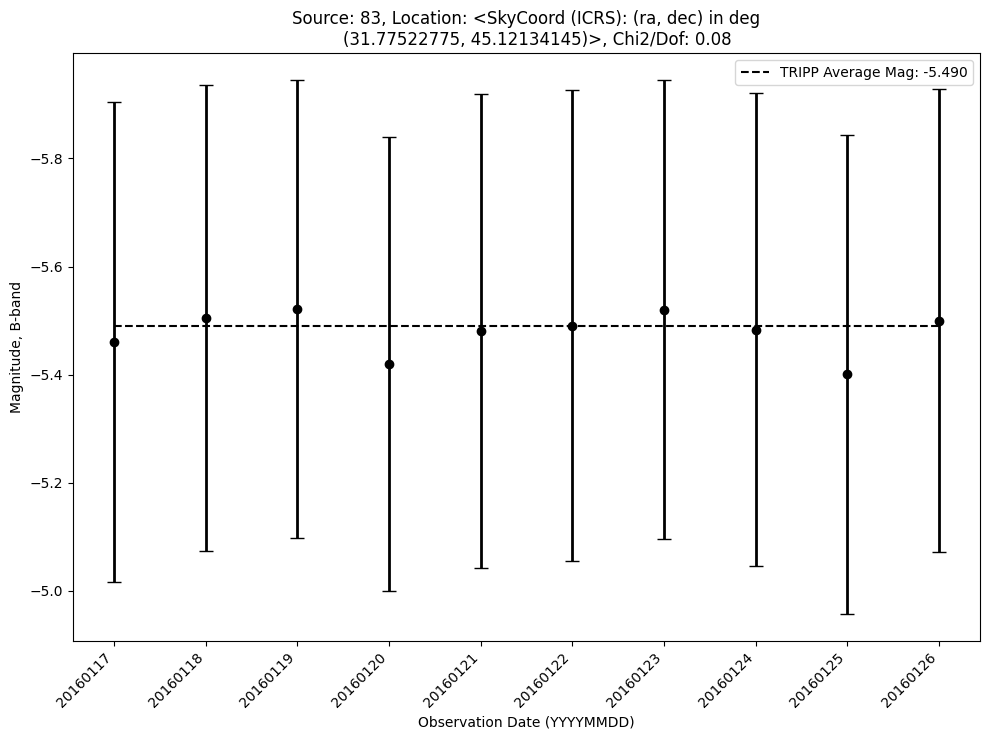

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.74135982, 45.12523402)>, Night_0_xy: (array(2580.48575972), array(1842.50415966)) rad: 18.0, ref_status: None, ref_mag: None, inst_mag_avg:-13.618017936378171, cal_mag_avg: -13.618017936378171, flagged: False, ID: 84, Chi2: None
None
[0.013709115322352337, 0.013714530004758134, 0.013732272098806729, 0.007375540499008458, 0.0010448516657518116, 0.0010450146484331881, 0.0010450036075302673, 0.0010448744155746531, 0.007362338895134881, 0.013712983136723762]


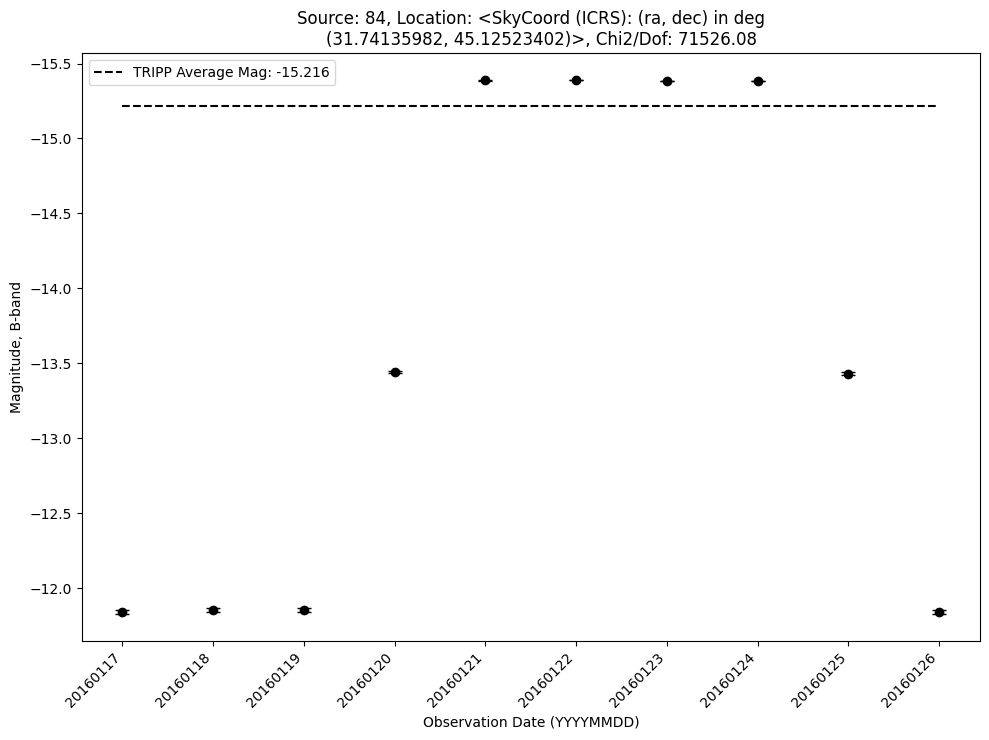

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.84009004, 45.12682609)>, Night_0_xy: (array(2140.50723628), array(1851.50739872)) rad: 11.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.458522856890133, cal_mag_avg: -10.458522856890133, flagged: False, ID: 85, Chi2: None
None
[0.027106580530965124, 0.027117060651027865, 0.02716140718654782, 0.027071111531291884, 0.027093580243419985, 0.027113030611254453, 0.027115277862307934, 0.027116087144454046, 0.02711444420894389, 0.02710236020394951]


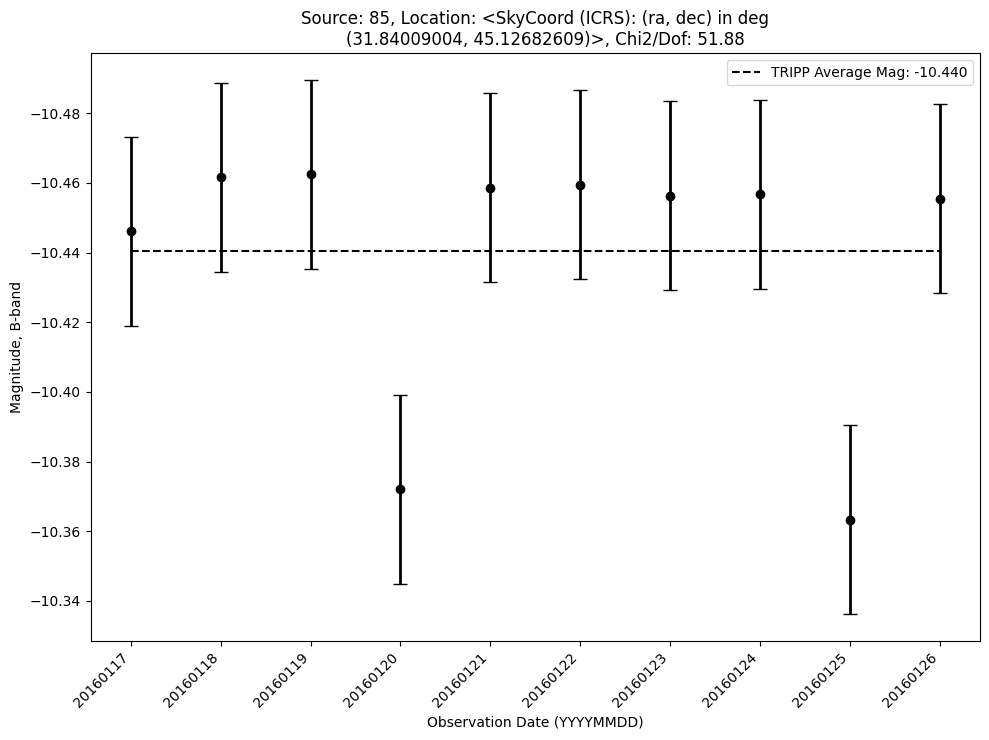

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.01379375, 45.13195623)>, Night_0_xy: (array(1366.48577102), array(1883.3617103)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-5.520797926310918, cal_mag_avg: -5.520797926310918, flagged: False, ID: 86, Chi2: None
None
[0.4193366879121674, 0.4325588727318226, 0.41951021168568203, 0.42179476638554836, 0.425105494364346, 0.41670502303609525, 0.4238313369706299, 0.4052613899830444, 0.4301804119452687, 0.4110998969286173]


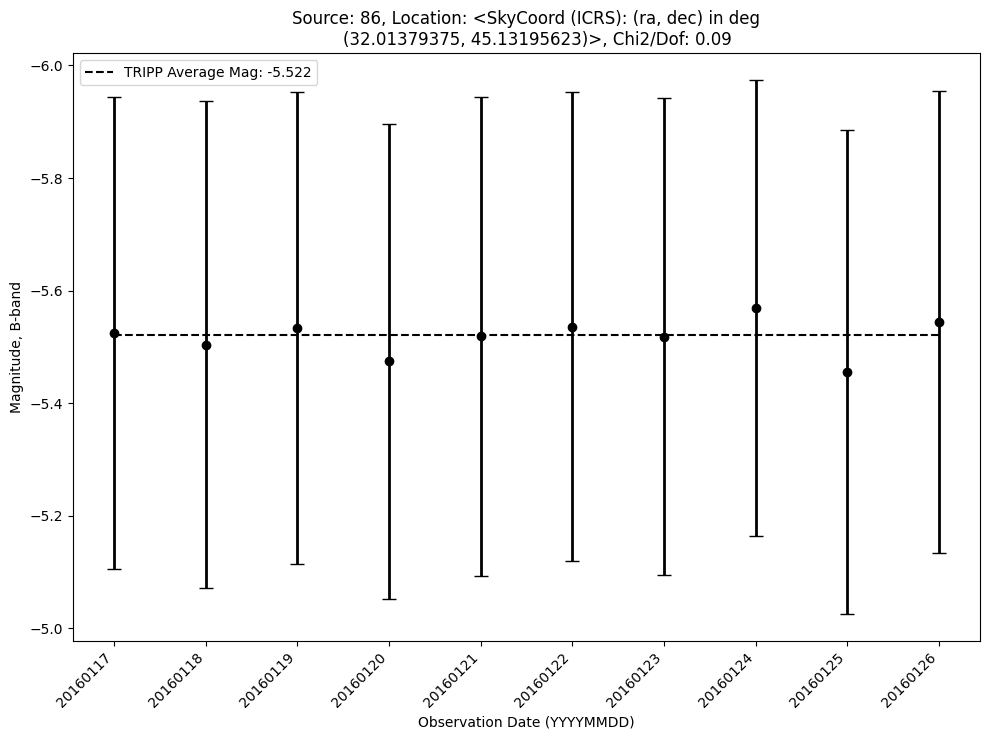

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.8923757, 45.12972741)>, Night_0_xy: (array(1907.49858359), array(1869.49212532)) rad: 19.5, ref_status: None, ref_mag: None, inst_mag_avg:-12.062188770445086, cal_mag_avg: -12.062188770445086, flagged: False, ID: 87, Chi2: None
None
[0.012560263443996002, 0.012572954438005692, 0.012571617423070863, 0.012569785408029954, 0.012572472675810794, 0.012571011631665229, 0.012564797846467581, 0.012581927502811226, 0.012577228310031663, 0.012578581193970432]


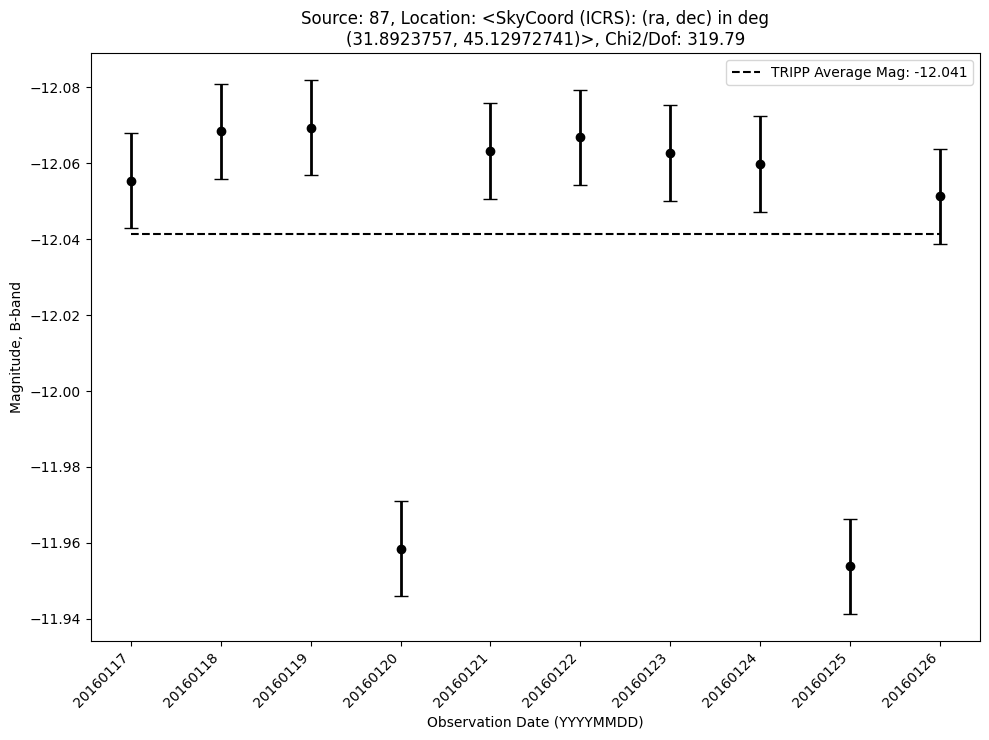

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.22565889, 45.13251716)>, Night_0_xy: (array(422.49709604), array(1888.48873543)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.556172805905407, cal_mag_avg: -6.556172805905407, flagged: False, ID: 88, Chi2: None
None
[0.23475168069132116, 0.2372142478286099, 0.23652385445949475, 0.23660497630304206, 0.23220650517060973, 0.23898583536111823, 0.23790690730928868, 0.23277727293628614, 0.22900947110514486, 0.2348712483742012]


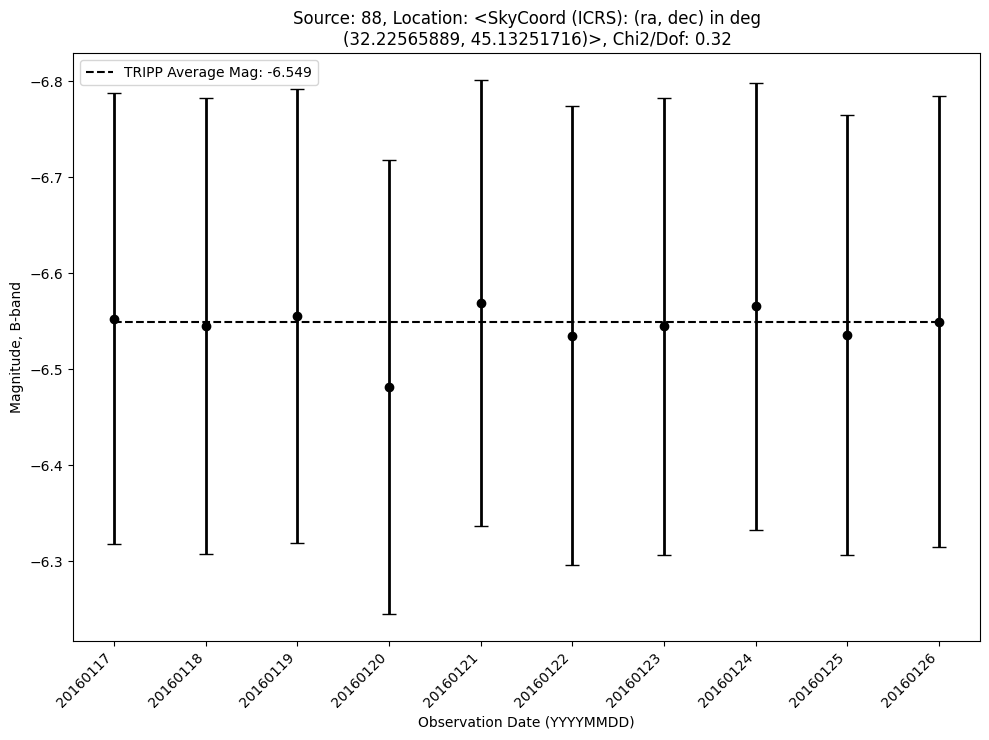

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.96079061, 45.13641228)>, Night_0_xy: (array(1602.64136079), array(1911.49590047)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-6.052850767077672, cal_mag_avg: -6.052850767077672, flagged: False, ID: 89, Chi2: None
None
[0.31442762516665734, 0.31148112791853066, 0.3184848103905368, 0.31677459000323166, 0.3198195659773022, 0.31271557705575936, 0.307033510108311, 0.3159466822733421, 0.31948505023186075, 0.31824005000412114]


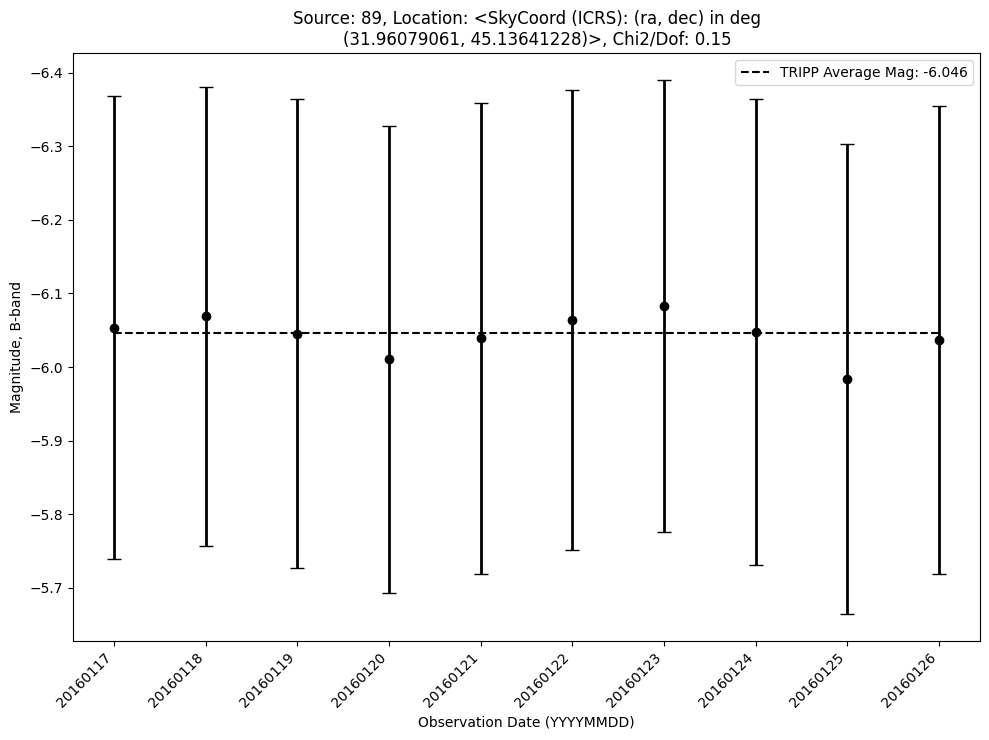

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.8016812, 45.13863606)>, Night_0_xy: (array(2311.49160264), array(1926.44256205)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.787233489826793, cal_mag_avg: -9.787233489826793, flagged: False, ID: 90, Chi2: None
None
[0.17402995708060925, 0.1712027401574824, 0.17108632703049914, 0.08484854835150962, 0.003890740620791177, 0.0038903322758245453, 0.003890332651325348, 0.003890027961607264, 0.08620694726445188, 0.1731978952626464]


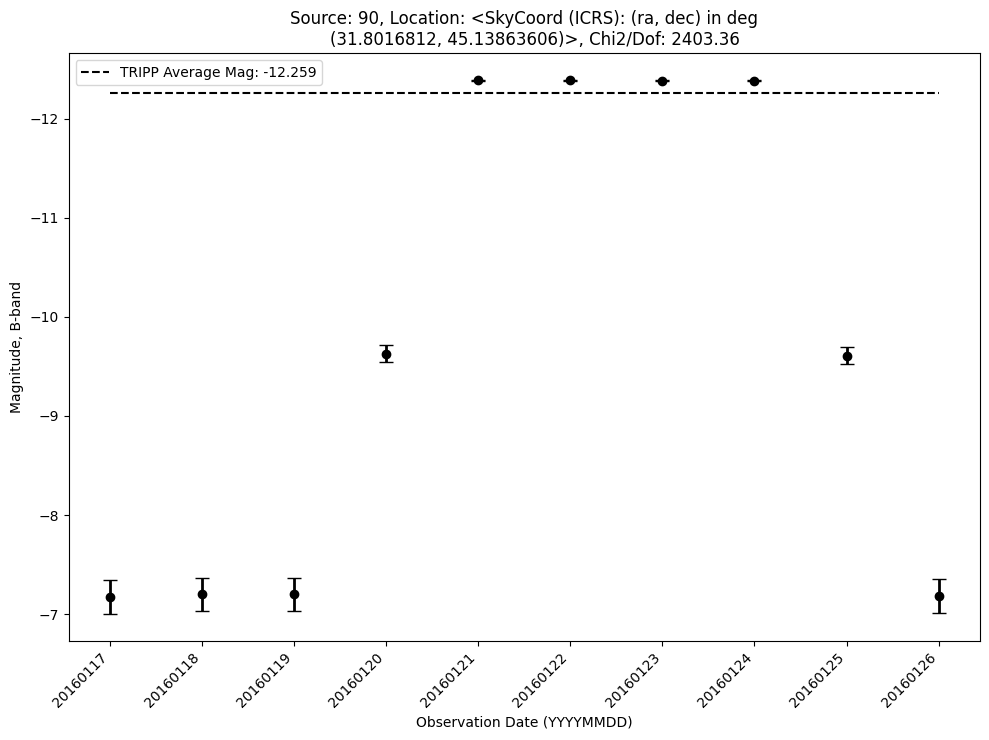

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.76105602, 45.13794012)>, Night_0_xy: (array(2492.49484022), array(1922.5009752)) rad: 14.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.294441917241306, cal_mag_avg: -11.294441917241306, flagged: False, ID: 91, Chi2: None
None
[0.01649350953933814, 0.016488321554706024, 0.01646758039395131, 0.016492139185186737, 0.016499517928197163, 0.01648607750801702, 0.016469150056620484, 0.016485004902031385, 0.016465827982937782, 0.016492105866588693]


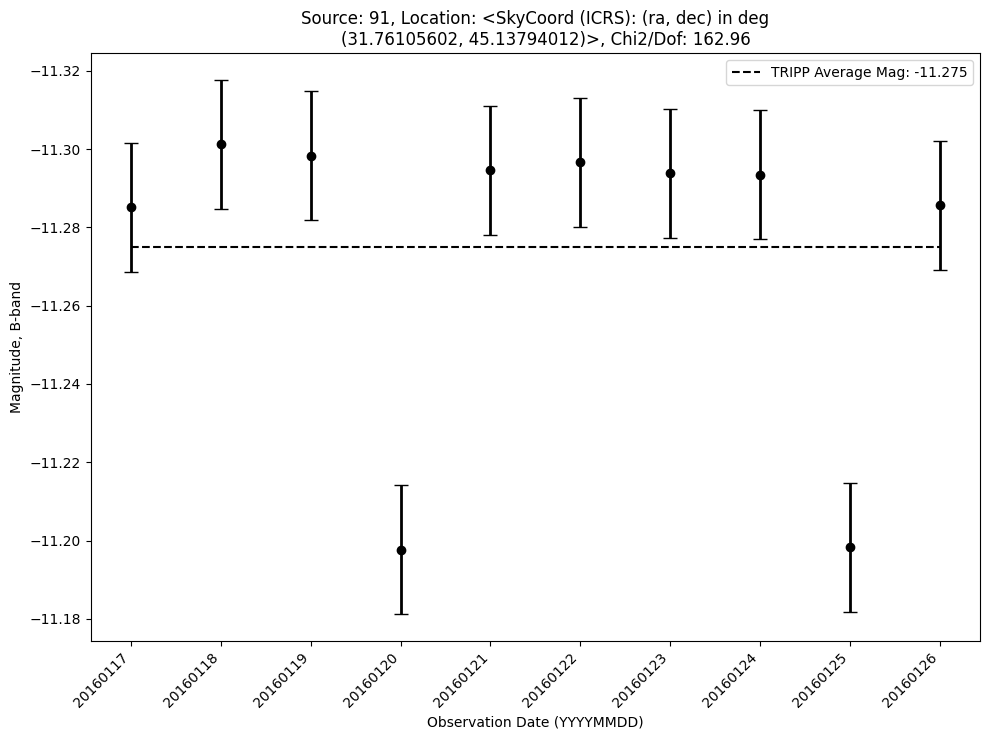

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.11995466, 45.14013572)>, Night_0_xy: (array(893.55588178), array(1935.50657094)) rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.551649541649774, cal_mag_avg: -7.551649541649774, flagged: False, ID: 92, Chi2: None
None
[0.14140354904739064, 0.14113649761934233, 0.1390612837855907, 0.1404693043449335, 0.13872548421869513, 0.13833891931308748, 0.13921173630567724, 0.13940652575010054, 0.1400332623061038, 0.13997504481939804]


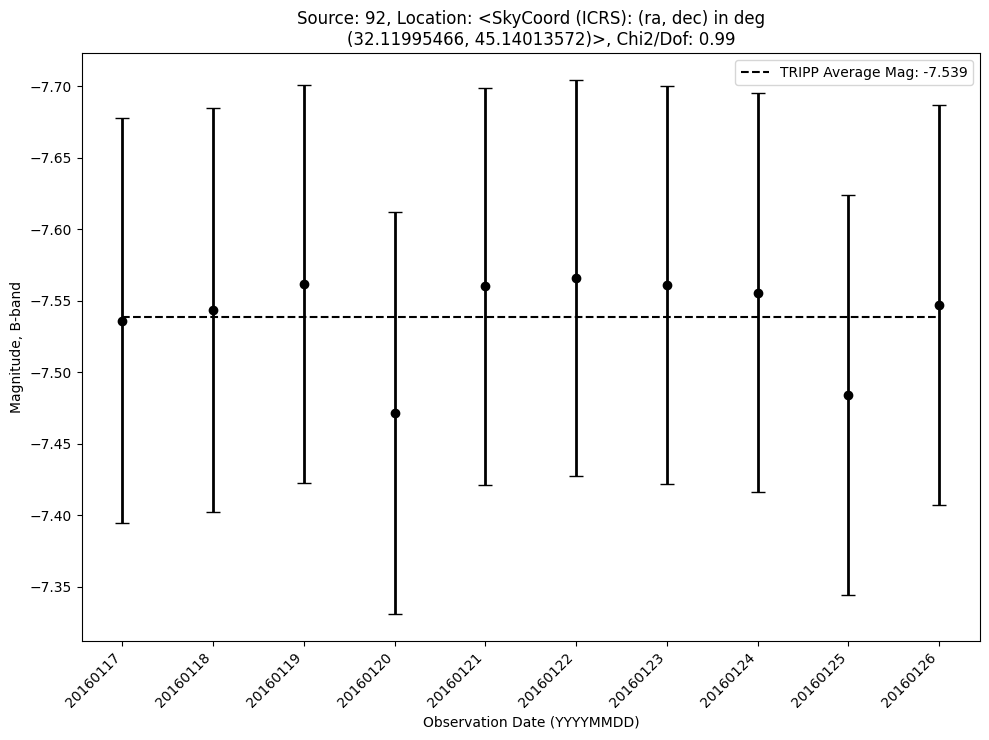

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.72354693, 45.14339914)>, Night_0_xy: (array(2659.49477731), array(1957.4789527)) rad: 12.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.564085764460087, cal_mag_avg: -10.564085764460087, flagged: False, ID: 93, Chi2: None
None
[0.025959309194911455, 0.026001105891317385, 0.02598031679474531, 0.025997644046952532, 0.02593365225616342, 0.025956490671604403, 0.025943909049256735, 0.025964999363693203, 0.025934361181884052, 0.025962470634440335]


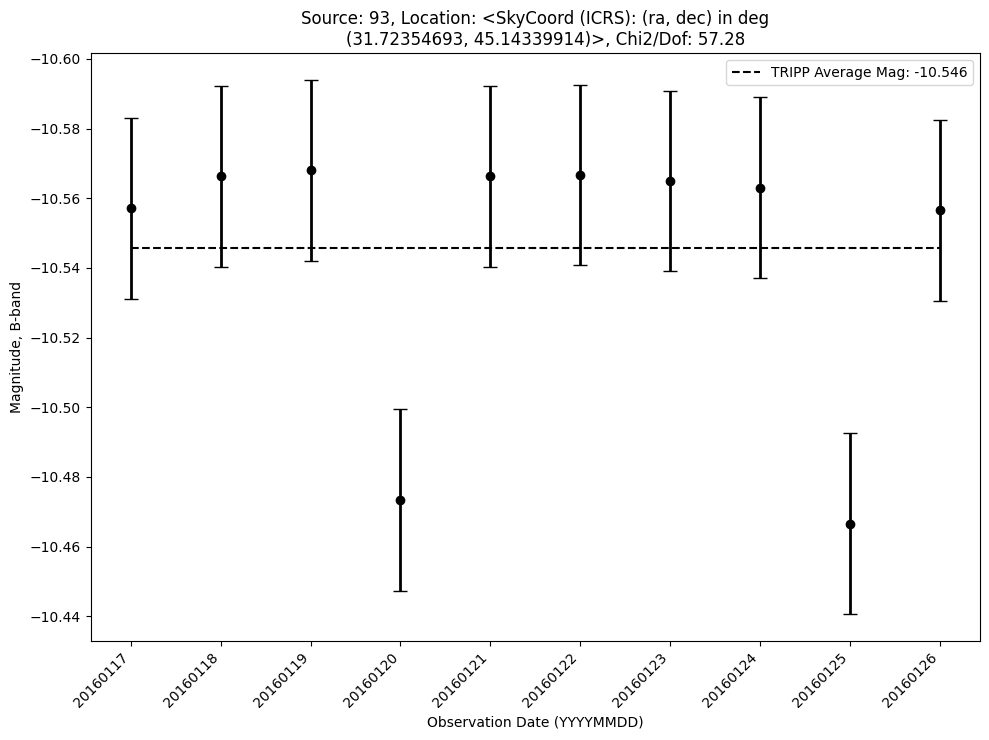

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.80164828, 45.14782633)>, Night_0_xy: (array(2311.5076028), array(1984.48707556)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.9527401448855155, cal_mag_avg: -6.9527401448855155, flagged: False, ID: 94, Chi2: None
None
[0.21394344720000014, 0.21074883149104182, 0.21441708720052421, 0.21586756148546346, 0.2139732168840695, 0.2128204053802437, 0.21520261908814545, 0.21421821716870304, 0.21666647176769976, 0.21637911949282768]


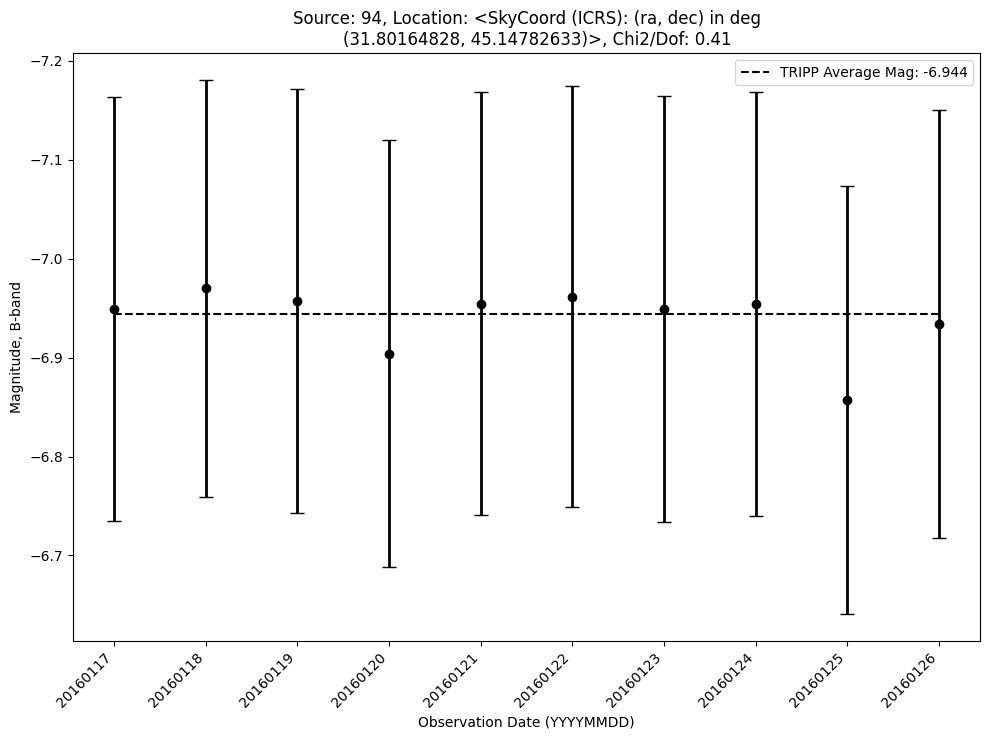

In [14]:
for source in Sources:
    if source.flagged != True:
        if len(Nights) > 1:
            print(source.get_info())
            night_array = np.array(night_array)
            source_mags = np.array(source.calibrated_mags/med_curve)
            source_errs = np.array(source.errors)
            median_mags = []
            median_errs = []
            mjd_times = []
            utc_times = []
            for night in range(np.max(night_array) + 1): # +1 avoids fencepost error in the night because range is exclusive.
                #Magnitudes
                index_array = np.where(night_array == night)[0]
                night_mags = source_mags[index_array]
                night_errs = source_errs[index_array]
                median_mags.append(np.median(night_mags))
                median_errs.append(np.median(night_errs))
                #Times
                mjd_array = np.array(Nights[night].mjd_times)
                utc_array = np.array(Nights[night].date)
                mjd_times.append(np.median(mjd_array))
                utc_times.append(utc_array[int(len(utc_array)/2)])
            print(median_errs)
            avg_mag = np.average(source.calibrated_mags/med_curve, weights= source.weights)
            Chis = []
            for i, m in enumerate(source.calibrated_mags):
                chi_i = (((m/med_curve[i]) - avg_mag)**2)/(source.errors[i]**2)
                Chis.append(chi_i)
            dof = len(source.calibrated_mags) - 1
            chi_dof = np.sum(Chis)/dof
            source.add_chi(chi_dof)
            dof_string =  "%.2f" % chi_dof
            plt.figure(figsize=(10,7.5))
            plt.title(f"Source: {source.source_id}, Location: {source.position}, Chi2/Dof: {dof_string}")
            plt.errorbar(mjd_times, median_mags, yerr=median_errs, elinewidth=2, capsize=5, linestyle="", marker="o", color="black")
            plt.xticks(mjd_times, utc_times, rotation=45, ha='right')
            plt.xlabel("Observation Date (YYYYMMDD)")
            plt.ylabel(f"Magnitude, {Nights[0].obs_filter}-band")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.plot(mjd_times, np.ones(len(mjd_times))*avg_mag, linestyle = '--', color = 'black', label = "TRIPP Average Mag: {}".format("%.3f" % avg_mag))
            if source.is_reference:
                plt.plot(mjd_times, np.ones(len(mjd_times))*source.ref_mag, linestyle = 'dashdot', color = f"{Nights[0].obs_filter}", label = "SDSS Mag: {}".format("%.3f" % source.ref_mag))
            plt.legend()
            #plt.savefig(f"/Users/lucaangeleri/Desktop/test/source{source.source_id}.png", dpi = 1000)
            plt.show()

        else: #single night
            print(source.get_info())
            r = np.arange(0, len(source.calibrated_mags))
            avg_mag = np.average(source.calibrated_mags/med_curve, weights=source.weights)
            #avg_mag = np.mean(source.calibrated_mags/med_curve)
            Chis = []
            for i, m in enumerate(source.calibrated_mags):
                chi_i = (((m / med_curve[i]) - avg_mag) ** 2) / (source.errors[i] ** 2)
                Chis.append(chi_i)
            dof = len(source.calibrated_mags) - 1
            chi_dof = np.sum(Chis) / dof
            source.add_chi(chi_dof)
            dof_string = "%.2f" % chi_dof
            plt.figure(figsize=(12, 9))
            plt.errorbar(r, source.calibrated_mags/med_curve, yerr=source.errors, elinewidth=1, capsize=2, markersize = 3, linestyle = 'none', marker = 'o', c = 'black')
            plt.plot(r, np.ones(len(r))*avg_mag, linestyle = '--', color = 'black', label = f"TRIPP Avg Mag:{avg_mag}")
            if source.is_reference:
                plt.plot(r, np.ones(len(r))*source.ref_mag, linestyle = 'dashdot', color = f"{Nights[0].obs_filter}", label = "SDSS Mag: {}".format("%.3f" % source.ref_mag))
            x_locs= []
            times = []
            for i in range(len(Nights[0].image_data))[::10]:
                x_locs.append(i)
                times.append(Nights[0].start_times[i])
            plt.xlabel("Observation Start Time, UTC (HH:MM:SS)")
            plt.ylabel(f"Magnitude {Nights[0].obs_filter}-band")
            plt.title(f"Source: {source.source_id}, Location: {source.position}, Chi2/Dof: {chi_dof}")
            plt.gca().invert_yaxis()
            plt.xticks(x_locs, times, rotation = 45)
            plt.legend()
            #plt.savefig("/Users/lucaangeleri/Desktop/test/sec32source{}.png".format(source.source_id), format = 'png', dpi = 500,  bbox_inches="tight")
            plt.show()

In [15]:
transient_candidates = []
for source in Sources:
    if source.flagged != True:
        if source.chi2 > 25:
            transient_candidates.append(source.get_info())

print(len(transient_candidates))

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.72125237, 44.86140571)>, Night_0_xy: (array(2675.49216501), array(176.49727642)) rad: 13.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.042548515364027, cal_mag_avg: -11.042548515364027, flagged: False, ID: 4, Chi2: 109.95171343036257
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (31.79853307, 44.86361497)>, Night_0_xy: (array(2329.493325), array(189.49576023)) rad: 19.5, ref_status: None, ref_mag: None, inst_mag_avg:-13.806146736212872, cal_mag_avg: -13.806146736212872, flagged: False, ID: 5, Chi2: 80247.86864310571
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.10928521, 44.86907568)>, Night_0_xy: (array(938.44299621), array(223.46836317)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.925459436651385, cal_mag_avg: -8.925459436651385, flagged: False, ID: 6, Chi2: 954.9019386401445
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (32.19286163, 44.87957196)>, Night_0_xy: (array(564.51316043), array(290.53027462)) r

In [16]:
header_row = ["Source_Position", "Reference_Source", "Reference_Magnitude", "Chi2/DoF", "Flagged", "Source_ID", "TRIPP_Calibrated_Mags" ]
with open('/Users/lucaangeleri/Desktop/output.csv', 'w') as stream:
    writer = csv.writer(stream)
    writer.writerow(header_row)
    writer.writerows([source for source in Sources if source.flagged != True and source.chi2>25])


FileNotFoundError: [Errno 2] No such file or directory: '/Users/lucaangeleri/Desktop/output.csv'

In [ ]:
for night in Nights:
    print(night.headers[0]['SITE'], night.headers[0]['TELID'])

In [ ]:
chis = []
for source in Sources:
    if not source.flagged:
        chis.append(source.chi2)
print(np.mean(chis), np.std(chis))

inst_mags = [source.inst_mags[counter] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        #inst_errs = [source.inst_mag_errs[counter] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        ref_mags = [source.ref_mag[0] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        #ref_mag_errs = [source.ref_mag_err[0] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        p0, cov0 = np.polyfit(inst_mags, ref_mags, deg = 1, cov = True)
        diffs = [s.ref_mag[0] - (s.inst_mags[counter]*p0[0] + p0[1]) for s in Sources if s.is_reference == True and s.ref_mag < mag_thresh and source.flagged == False]
        stdv = np.std(diffs)
        inst_mags_final = []
        sky_mags_final = []
        outlier_inst =[]
        outlier_sky =[]
        for diff in diffs: #rudementary sigma clipping to remove outliers from calibration model.
            if diff < stdv:
                i = diffs.index(diff)
                inst_mags_final.append(inst_mags[i])
                sky_mags_final.append(ref_mags[i])
            else:
                i = diffs.index(diff)
                outlier_inst.append(inst_mags[i])
                outlier_sky.append(ref_mags[i])
        if len(sky_mags_final) > 0:
            p1, cov1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1, cov = True)
            if abs(p1[0]-1) < abs(p0[1]-1):
                print("using second")
                slopes.append(p1[0])
                zeros.append(p1[1])
                slope_errs.append(np.sqrt(np.diag(cov1))[0])
                zero_errs.append(np.sqrt(np.diag(cov1))[1])
        else:
            slopes.append(p0[0])
            zeros.append(p0[1])
            slope_errs.append(np.sqrt(np.diag(cov0))[0])
            zero_errs.append(np.sqrt(np.diag(cov0))[1])
        counter += 1